# Imports + General

In [ ]:
# Install unrar
!apt-get install -y unrar

In [ ]:
# Define paths
# rar_file_path_test = '/kaggle/input/CASIA-HWDB/test.rar'  # Path to test RAR in /input
# rar_file_path_train = '/kaggle/input/CASIA-HWDB/train.rar'  # Path to train RAR in /input
# rar_file_path_model_stuff = '/kaggle/input/CASIA-HWDB/model_CASIA_HWDB_stuff.rar'  # Path to model stuff RAR in /input
# extraction_path_test = '/kaggle/working/test'  # Writable path test in /working
# extraction_path_train = '/kaggle/working/train'  # Writable path train in /working
# extraction_path_model_stuff = '/kaggle/working/model_CASIA_HWDB_stuff'  # Writable path model stuff in /working

# Unpack RAR files
# !unrar x {rar_file_path_test} {extraction_path_test}
# !unrar x {rar_file_path_train} {extraction_path_train}
# !unrar x {rar_file_path_model_stuff} {extraction_path_model_stuff}

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import pickle



import numpy as np

import pandas as pd

import random

import os



from tqdm import tqdm



import torchvision

import torchvision.models as models

from torchvision import transforms, datasets

import torch.utils.data as data

import torchvision.datasets

from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_fscore_support

from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights

import matplotlib.pyplot as plt

from PIL import ImageOps, Image



random.seed(0)

np.random.seed(0)

torch.manual_seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True

# device = 'cpu' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



# Paths to data

kkanji_150_path = "/kaggle/input/kkanji/kkanji2_150/kkanji2_150"

kkanji_200_path = "/kaggle/input/kkanji/kkanji2_200/kkanji2_200"

kkanji_300_path = "/kaggle/input/kkanji/kkanji2_300/kkanji2_300"

In [29]:
file_path = "/kaggle/working/train_test_indices_150.pkl"

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print(f"File not found: {file_path}")

Deleted: /kaggle/working/train_test_indices_150.pkl


In [4]:
print(os.cpu_count()) 

4


In [4]:
test_last_epoch = np.load("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff/last_epoch.npy")
print(test_last_epoch)

11

In [ ]:
# Define the path for the new directory
directory_path = '/kaggle/working/model_CASIA_HWDB_stuff'

# Create the directory
os.makedirs(directory_path, exist_ok=True)
print(f"Directory created at: {directory_path}")

In [5]:
dir_pathes = ['/kaggle/working/model_150_stuff', '/kaggle/working/model_200_stuff', '/kaggle/working/model_300_stuff'
              ,'/kaggle/working/model_augmented_150_stuff', '/kaggle/working/model_augmented_200_stuff', '/kaggle/working/model_augmented_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_all_150_stuff', '/kaggle/working/model_pretrained_unfreeze_all_200_stuff', '/kaggle/working/model_pretrained_unfreeze_all_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_last_150_stuff', '/kaggle/working/model_pretrained_unfreeze_last_200_stuff', '/kaggle/working/model_pretrained_unfreeze_last_300_stuff']

for dir_path in dir_pathes:
    # Create the directory
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory created at: {dir_path}")

Directory created at: /kaggle/working/model_150_stuff
Directory created at: /kaggle/working/model_200_stuff
Directory created at: /kaggle/working/model_300_stuff
Directory created at: /kaggle/working/model_augmented_150_stuff
Directory created at: /kaggle/working/model_augmented_200_stuff
Directory created at: /kaggle/working/model_augmented_300_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_150_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_200_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_all_300_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_150_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_200_stuff
Directory created at: /kaggle/working/model_pretrained_unfreeze_last_300_stuff


# PreactBasicBlock

In [6]:
class PreactBasicBlock(nn.Module):

    expansion = 1



    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,

                 base_width=64, dilation=1, norm_layer=None):

        super(PreactBasicBlock, self).__init__()



        if norm_layer is None:

            norm_layer = nn.BatchNorm2d



        if groups != 1 or base_width != 64:

            raise ValueError('BasicBlock only supports groups=1 and base_width=64')



        if dilation > 1:

            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")



        # Both self.conv1 and self.downsample layers downsample the input when stride != 1



        self.bn1 = nn.BatchNorm2d(inplanes)

        self.relu1 = nn.ReLU(inplace=True)

        self.conv1 = conv3x3(inplanes, planes, stride)



        self.bn2 = nn.BatchNorm2d(planes)

        self.relu2 = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)

        

        self.downsample = downsample

        self.stride = stride



    def forward(self, x):

        identity = x



        out = self.bn1(x)

        out = self.relu1(out)

        out = self.conv1(out)



        out = self.bn2(out)

        out = self.relu2(out)

        out = self.conv2(out)



        if self.downsample is not None:

            identity = self.downsample(x)



        out += identity



        return out

    

    # Check what is model params and conv3x3. Also normlayer is not used.

# Cycle func

In [7]:
def are_weigths_unequal(old_weigths, new_weigths):

    return bool(len([1 for w1, w2 in zip(old_weigths, new_weigths) if not torch.all(w1.eq(w2))]))



def cycle(model, loader, criterion, train=False, optimizer=None, freeze_base=False):

    overall_loss = []

    overall_accuracy = []

    dataloader_iterator = iter(loader)



    if train:

        model.train()

    else:

        model.eval()

    if freeze_base:

        for param in model.parameters():

            param.requires_grad = False



        for param in model.fc.parameters():

            param.requires_grad = True



    model_weigths = list(model.state_dict().values())



    for batch_id in tqdm(range(len(loader))):   

        try:

            X_batch, y_batch = next(dataloader_iterator)

        except:

            dataloader_iterator = iter(loader)

            X_batch, y_batch = next(dataloader_iterator)



        # if batch_id == 2:

        #     if train:

        #         assert are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Model is not training"

                

        #     else:

        #         assert not are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Weigths are chaning while validating"



        #     del model_weigths

    

        X_batch = X_batch.to(device)

        y_batch = y_batch.to(device)



        if train:

            optimizer.zero_grad()

            preds = model(X_batch)



            # print("Preds require grad: ", preds.requires_grad)



            loss_value = criterion(preds, y_batch)



            # print("Loss value require grad: ", loss_value.requires_grad)

            if batch_id % 100 == 0:
                print("Batch is processing:", batch_id)
            loss_value.backward()



            # Check weights

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (before step): ", new_model_weights[0].requires_grad)



            # for param in model.parameters():

            #     print(param.grad.data.sum())

    

            optimizer.step()



            # for param in model.parameters():

            #     print(param.grad.data.sum())



            # Check weights again after optimizer step

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (after step): ", new_model_weights[0].requires_grad)



        else:

            with torch.no_grad():

                preds = model(X_batch)

                loss_value = criterion(preds, y_batch).mean()



        overall_loss.append(loss_value.mean())



        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()

        overall_accuracy.append(accuracy)



    mean_loss = sum(overall_loss) / len(loader)

    mean_accuracy = sum(overall_accuracy) / len(loader)

    

    return mean_loss.item(), mean_accuracy.item()

In [ ]:
w1 = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])]

w2 = [torch.tensor([1, 2, 3]), torch.tensor([4, 6, 6])]

assert are_weigths_unequal(w1, w2), "Weigths are equal"

# Dataloaders

In [8]:
# Dataset initialization



def get_dataloaders(batch_size: int = 16, classamount: int = 150, train_test_indices_path: str = None):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Grayscale(num_output_channels=3),

                transforms.Resize(64),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    if classamount == 150:

        # Load dataset 150

        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=my_transform)



    elif classamount == 200:

        # Load dataset 200

        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=my_transform)



    elif classamount == 300:

        # Load dataset 300

        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=my_transform)


    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
                
    else:
    
        train_indices, test_indices = train_test_split(
        
            list(range(len(full_dataset))),
        
            test_size=0.3,
        
            stratify=[label for _, label in full_dataset.samples]
        
        )
        
        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    
    train_dataset = data.Subset(full_dataset, train_indices)

    test_dataset = data.Subset(full_dataset, test_indices)



    # Calculate class weights for the training set

    class_counts = [0] * len(full_dataset.classes)

    for idx in train_indices:

        _, label = full_dataset.samples[idx]

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



    return trainloader, testloader, full_dataset

# Dataloaders CASIA-HWDB

In [103]:
# Dataset CASIA-HWDB initialization



def invert_image(image):

    if isinstance(image, Image.Image):

        return ImageOps.invert(image)

    else:

        raise TypeError("Input should be a PIL Image")



def get_dataloaders_CASIA_HWDB(batch_size: int = 4096):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Resize(64),  # Resize the smaller edge to 64 while preserving aspect ratio

                transforms.CenterCrop((64, 64)),  # Center crop to 64x64

                transforms.Lambda(invert_image), # invert colors

                transforms.Grayscale(num_output_channels=3),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    # Load dataset

    train_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/train/train", transform=my_transform)

    test_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/test/test", transform=my_transform)



    # Calculate class weights for the training set

    class_counts = [0] * len(train_dataset.classes)

    for _, label in train_dataset.samples:

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[label] for _, label in train_dataset.samples]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



    return trainloader, testloader, train_dataset

# Dataloaders augmented

In [9]:
def get_dataloaders_augmented(batch_size: int = 16, classamount: int = 150, train_test_indices_path: str = None):
    # Define transformations for training and testing
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(64, scale=(0.95, 1.05)),
        transforms.RandomAffine(degrees=0, shear=0.05),
        transforms.Resize(64),  # Ensure the image is 64x64
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    if classamount == 150:
        # Load dataset 150
        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=None)
    elif classamount == 200:
        # Load dataset 200
        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=None)
    elif classamount == 300:
        # Load dataset 300
        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=None)

    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
    else:
        train_indices, test_indices = train_test_split(
            list(range(len(full_dataset))),
            test_size=0.3,
            stratify=[label for _, label in full_dataset.samples]
        )

        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    train_dataset = data.Subset(full_dataset, train_indices)
    test_dataset = data.Subset(full_dataset, test_indices)

    # Apply transformations
    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform

    # Calculate class weights for the training set
    class_counts = [0] * len(full_dataset.classes)
    for idx in train_indices:
        _, label = full_dataset.samples[idx]
        class_counts[label] += 1

    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]

    # Create a WeightedRandomSampler for the training set
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset

# Testing models

In [10]:
# Testing loop

def testing_model(class_amount: int = 150, model_suff_path: str = None, train_test_indices_path: str = None):



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False) # 'resnet18'

    model.fc = nn.Linear(model.fc.in_features, class_amount)



    if model_suff_path is not None:

        if os.path.exists(f"{model_suff_path}/model.pth"):

            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))



    else:

        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):

            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))



    criterion = nn.CrossEntropyLoss()


    # For CASIA-HWDB
    # trainloader, testloader, original_dataset = get_dataloaders_CASIA_HWDB(batch_size=4096)

    # For kkanji
    trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, classamount=class_amount, train_test_indices_path=train_test_indices_path)

    model = model.to(device)
    
    test_loss, test_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion)



    print('Test: loss', test_loss, 'accuracy', test_accuracy)



    #Accuracy for each class

    class_correct = list(0. for i in range(class_amount))



    class_total = list(0. for i in range(class_amount))



    model.eval()



    with torch.no_grad():

        for data in testloader:

            images, labels = data

            images = images.to(device)

            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()

            for i in range(len(labels)):

                label = labels[i]

                class_correct[label] += c[i].item()

                class_total[label] += 1



    # Print accuracy for each class using class names

    class_correct_dict = {}

    class_total_dict = {}



    for i in range(class_amount):

        class_correct_dict[original_dataset.classes[i]] = class_correct[i] / class_total[i]

        class_total_dict[original_dataset.classes[i]] = class_total[i]



    class_correct_dict = dict(sorted(class_correct_dict.items(), key=lambda item: item[1], reverse=True))



    for key, value in class_correct_dict.items():

        print(key, value, class_total_dict[key])



# Getting stuff for training

In [11]:
def getting_stuff_for_training(classamount: int = 150, pathes: dict = None, lr: float = 1e-3, scheduler_step_size: int = 10, scheduler_gamma: float = 0.1, pretrained = False):    

    stuff = {}

    last_epoch = 0

    if os.path.exists(pathes["last_epoch"]):

        last_epoch = np.load(pathes["last_epoch"])

    stuff["last_epoch"] = last_epoch



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, progress=False) # 'resnet18'

    if pretrained:
        
        model.fc = nn.Linear(model.fc.in_features, 6764)

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    if classamount == 150:

        model.fc = nn.Linear(model.fc.in_features, 150)



    elif classamount == 200:

        model.fc = nn.Linear(model.fc.in_features, 200)



    elif classamount == 300:

        model.fc = nn.Linear(model.fc.in_features, 300)



    elif classamount == 6764:

        model.fc = nn.Linear(model.fc.in_features, 6764)

    if not pretrained:

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    # if weights is not None:

    #     for param in model.parameters():

    #         param.requires_grad = False



    #     for param in model.fc.parameters():

    #         param.requires_grad = True

    model = model.to(device)
    
    stuff["model"] = model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.)

    if os.path.exists(pathes["optimizer"]):

        optimizer.load_state_dict(torch.load(pathes["optimizer"]))

    stuff["optimizer"] = optimizer



    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    if os.path.exists(pathes["scheduler"]):

        scheduler.load_state_dict(torch.load(pathes["scheduler"]))

    stuff["scheduler"] = scheduler



    train_loss_history = []

    if os.path.exists(pathes["train_loss_history"]):

        train_loss_history = list(np.load(pathes["train_loss_history"]))

    stuff["train_loss_history"] = train_loss_history



    train_accuracy_history = []

    if os.path.exists(pathes["train_accuracy_history"]):

        train_accuracy_history = list(np.load(pathes["train_accuracy_history"]))

    stuff["train_accuracy_history"] = train_accuracy_history



    val_loss_history = []

    if os.path.exists(pathes["val_loss_history"]):

        val_loss_history = list(np.load(pathes["val_loss_history"]))

    stuff["val_loss_history"] = val_loss_history



    val_accuracy_history = []

    if os.path.exists(pathes["val_accuracy_history"]):

        val_accuracy_history = list(np.load(pathes["val_accuracy_history"]))

    stuff["val_accuracy_history"] = val_accuracy_history



    max_val_accuracy = 0

    if os.path.exists(pathes["max_val_accuracy"]):

        max_val_accuracy = np.load(pathes["max_val_accuracy"])

    stuff["max_val_accuracy"] = max_val_accuracy



    early_stopping = 5

    if os.path.exists(pathes["early_stopping"]):

        early_stopping = np.load(pathes["early_stopping"])

    stuff["early_stopping"] = early_stopping

    

    return stuff

# Plot func

In [12]:
def custom_plot(train_data : list = None, val_data : list = None, title: str = None,  ylabel: str = None):

    plt.plot(train_data, label="train")

    plt.plot(val_data, label="validation")

    plt.xlabel('Epochs')

    plt.ylabel(ylabel)

    plt.legend()

    plt.title(title)

    return

# Create pathes vocabulary

In [13]:
def create_pathes_vocabulary(path : str = None):
    pathes = {"last_epoch": f"{path}/last_epoch.npy", "model": f"{path}/model.pth", "optimizer": f"{path}/optimizer.pth", 
    "scheduler": f"{path}/scheduler.pth", "train_loss_history": f"{path}/train_loss_history.npy", "train_accuracy_history": f"{path}/train_accuracy_history.npy", 
    "val_loss_history": f"{path}/val_loss_history.npy", "val_accuracy_history": f"{path}/val_accuracy_history.npy", 
    "max_val_accuracy": f"{path}/max_val_accuracy.npy", "early_stopping": f"{path}/early_stopping.npy"}

    return pathes
    

# Train loop

In [14]:
def train_loop(trainloader, testloader, stuff : dict = None, criterion=nn.CrossEntropyLoss(), save_path : str = None, epochs : int = 100, model_name : str = None, freeze_base : bool = False):

    last_epoch = stuff["last_epoch"]

    epochs += last_epoch 



    model = stuff["model"]

    optimizer = stuff["optimizer"]

    scheduler = stuff["scheduler"]



    train_loss_history = stuff["train_loss_history"]

    train_accuracy_history = stuff["train_accuracy_history"]



    val_loss_history = stuff["val_loss_history"]

    val_accuracy_history = stuff["val_accuracy_history"]



    max_val_accuracy = stuff["max_val_accuracy"]

    early_stopping = stuff["early_stopping"]

    for epoch in tqdm(range(last_epoch, epochs)):

        train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer, freeze_base=freeze_base) #train(model, trainloader, criterion, optimizer, batch_size)

        train_loss_history.append(train_loss)

        train_accuracy_history.append(train_accuracy)



        val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)

        val_loss_history.append(val_loss)

        val_accuracy_history.append(val_accuracy)



        scheduler.step()



        print('Epoch:', epoch+1)

        print('Train: loss', train_loss, 'accuracy', train_accuracy)

        print('Validation: loss', val_loss, 'accuracy', val_accuracy)



        if val_accuracy > max_val_accuracy:

            max_val_accuracy = val_accuracy

            early_stopping = 5



            # Save the model

            torch.save(model.state_dict(), f'{save_path}/model.pth')



            # Save the optimizer

            torch.save(optimizer.state_dict(), f'{save_path}/optimizer.pth')



            # Save the scheduler

            torch.save(scheduler.state_dict(), f'{save_path}/scheduler.pth')



            # Save the loss history

            np.save(f'{save_path}/train_loss_history.npy', train_loss_history)

            np.save(f'{save_path}/val_loss_history.npy', val_loss_history)



            # Save the accuracy history

            np.save(f'{save_path}/train_accuracy_history.npy', train_accuracy_history)

            np.save(f'{save_path}/val_accuracy_history.npy', val_accuracy_history)



            # Save the last epoch

            np.save(f'{save_path}/last_epoch.npy', epoch+1)



            # Save max validation accuracy

            np.save(f'{save_path}/max_val_accuracy.npy', max_val_accuracy)



            # Save early stopping

            np.save(f'{save_path}/early_stopping.npy', early_stopping)



        else:

            early_stopping -= 1



        if early_stopping == 0:

            break

    

    print(f'Best validation accuracy for {model_name}:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

# Testing models with metrics

In [101]:
def testing_models_metrics(class_amount: int = 300, model_suff_path: str = None, train_test_indices_path: str = None, casia_hwdb: bool = False):

    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False)  # 'resnet18'
    model.fc = nn.Linear(model.fc.in_features, class_amount)

    # Load model weights
    if model_suff_path is not None:
        if os.path.exists(f"{model_suff_path}/model.pth"):
            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
    else:
        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):
            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))

    criterion = nn.CrossEntropyLoss()

    # Load dataset
    if not casia_hwdb:
        trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, classamount=class_amount, train_test_indices_path=train_test_indices_path)
    else:
        trainloader, testloader, original_dataset = get_dataloaders_CASIA_HWDB(batch_size=4096)
    
    model = model.to(device)

    # Test loss and accuracy
    test_loss, test_accuracy = cycle(model, testloader, criterion)
    print('Test: loss', test_loss, 'accuracy', test_accuracy)

    # Accuracy for each class
    class_correct = [0. for _ in range(class_amount)]
    class_total = [0. for _ in range(class_amount)]
    all_labels = []
    all_predictions = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Save predictions and labels for mAP and mAR calculations
            all_probs.append(outputs.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Calculate per-class accuracy
    class_accuracy = {original_dataset.classes[i]: class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                      for i in range(class_amount)}

    print("Per-class accuracy:")
    for key, value in sorted(class_accuracy.items(), key=lambda item: item[1], reverse=True):
        print(f"{key}: {value:.5f} ")

    # Convert collected data to numpy arrays
    all_probs = np.vstack(all_probs)  # Predicted probabilities for each class
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Compute mAP
    ap_per_class = []
    for i in range(class_amount):
        true_labels = (all_labels == i).astype(int)
        
        # Skip invalid or empty classes
        if np.sum(true_labels) > 0 and not np.isnan(true_labels).any():
            # Ensure probabilities are valid
            class_probs = np.nan_to_num(all_probs[:, i], nan=0.0)
            ap = average_precision_score(true_labels, class_probs)
            ap_per_class.append(ap)
        else:
            ap_per_class.append(0)  # No instances or invalid data for this class
    
    mAP = np.mean(ap_per_class)
    print(f"Mean Average Precision (mAP): {mAP:.5f}")


    # Compute mAR
    precision, recall, _, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None, zero_division=0)
    mAR = np.mean(recall)
    mAP_without_probs = np.mean(precision)
    print(f"Mean Average Precision (mAP withput probs): {mAP_without_probs:.5f}")
    print(f"Mean Average Recall (mAR): {mAR:.5f}")

    # Compute Mean Average Accuracy (MAA)
    maa = np.mean(list(class_accuracy.values()))
    print(f"Mean Average Accuracy (MAA): {maa:.5f}")

    


# 150 classes logic

In [16]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [17]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_150_stuff", model_name="150 classes")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:49<00:00,  3.81s/it]

100%|██████████| 6/6 [00:40<00:00,  6.74s/it]


Epoch: 1
Train: loss 2.63325572013855 accuracy 0.48919472098350525
Validation: loss 8.965192794799805 accuracy 0.06017694249749184


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:37<00:00,  2.89s/it]

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch: 2
Train: loss 0.5067117214202881 accuracy 0.8797423839569092
Validation: loss 2.698166847229004 accuracy 0.41273602843284607


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:32<00:00,  2.49s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 3
Train: loss 0.20761042833328247 accuracy 0.9495687484741211
Validation: loss 0.30100947618484497 accuracy 0.9248886108398438


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.37s/it]

100%|██████████| 6/6 [00:15<00:00,  2.57s/it]


Epoch: 4
Train: loss 0.10736755281686783 accuracy 0.9763303399085999
Validation: loss 0.23777660727500916 accuracy 0.9418333172798157


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.32s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 5
Train: loss 0.06319741904735565 accuracy 0.9866469502449036
Validation: loss 0.21896398067474365 accuracy 0.946681559085846


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.25s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 6
Train: loss 0.04066978022456169 accuracy 0.9926506280899048
Validation: loss 0.20128284394741058 accuracy 0.9484944343566895


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.23s/it]

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Epoch: 7
Train: loss 0.027124980464577675 accuracy 0.995523989200592
Validation: loss 0.1880597174167633 accuracy 0.9534872174263


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:31<00:00,  2.40s/it]

  8%|▊         | 8/100 [07:06<1:13:55, 48.21s/it]

Epoch: 8
Train: loss 0.016447629779577255 accuracy 0.9972829222679138
Validation: loss 0.19527527689933777 accuracy 0.9531903266906738



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


Epoch: 9
Train: loss 0.01727266050875187 accuracy 0.9968824982643127
Validation: loss 0.17665955424308777 accuracy 0.9594852328300476


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Epoch: 10
Train: loss 0.011386055499315262 accuracy 0.9982534646987915
Validation: loss 0.15846523642539978 accuracy 0.9635767936706543


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


Epoch: 11
Train: loss 0.007219456601887941 accuracy 0.9988104701042175
Validation: loss 0.1523851752281189 accuracy 0.9654304385185242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


Epoch: 12
Train: loss 0.0049342080019414425 accuracy 0.999436616897583
Validation: loss 0.15097030997276306 accuracy 0.9660754203796387


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


Epoch: 13
Train: loss 0.004898890852928162 accuracy 0.9993614554405212
Validation: loss 0.15074628591537476 accuracy 0.9662849307060242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 14%|█▍        | 14/100 [11:42<1:05:51, 45.95s/it]

Epoch: 14
Train: loss 0.0037454187404364347 accuracy 0.9996243715286255
Validation: loss 0.14938700199127197 accuracy 0.9662442207336426



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:16<00:00,  2.81s/it]


Epoch: 15
Train: loss 0.004037078935652971 accuracy 0.9994741678237915
Validation: loss 0.1485585868358612 accuracy 0.966447651386261


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 16
Train: loss 0.003388147335499525 accuracy 0.999436616897583
Validation: loss 0.14780175685882568 accuracy 0.9674589037895203


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


Epoch: 17
Train: loss 0.0033192492555826902 accuracy 0.9996055960655212
Validation: loss 0.1472894549369812 accuracy 0.9676969051361084


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 18
Train: loss 0.00389129389077425 accuracy 0.999336302280426
Validation: loss 0.14701297879219055 accuracy 0.9678129553794861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.19s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 19
Train: loss 0.0044151353649795055 accuracy 0.9992048740386963
Validation: loss 0.14704936742782593 accuracy 0.9680977463722229


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 20%|██        | 20/100 [16:13<1:00:14, 45.18s/it]

Epoch: 20
Train: loss 0.004005665425211191 accuracy 0.9992424249649048
Validation: loss 0.14690940082073212 accuracy 0.9680631160736084



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 21%|██        | 21/100 [16:58<59:20, 45.07s/it]  

Epoch: 21
Train: loss 0.0028554657474160194 accuracy 0.9996619820594788
Validation: loss 0.14742527902126312 accuracy 0.9679064750671387



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch: 22
Train: loss 0.002710070228204131 accuracy 0.999680757522583
Validation: loss 0.14721044898033142 accuracy 0.96822589635849


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.23s/it]

 23%|██▎       | 23/100 [18:29<57:52, 45.10s/it]

Epoch: 23
Train: loss 0.0026069951709359884 accuracy 0.9997370839118958
Validation: loss 0.14695701003074646 accuracy 0.9681444764137268



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 24%|██▍       | 24/100 [19:14<57:13, 45.18s/it]

Epoch: 24
Train: loss 0.0026413409505039454 accuracy 0.9996243715286255
Validation: loss 0.14706838130950928 accuracy 0.96798175573349



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


Epoch: 25
Train: loss 0.0023309688549488783 accuracy 0.9997934103012085
Validation: loss 0.14701524376869202 accuracy 0.9683072566986084


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 26%|██▌       | 26/100 [20:43<55:24, 44.93s/it]

Epoch: 26
Train: loss 0.003432038938626647 accuracy 0.9994677901268005
Validation: loss 0.14706623554229736 accuracy 0.9681791663169861



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 27
Train: loss 0.0030224707443267107 accuracy 0.9995304942131042
Validation: loss 0.146939218044281 accuracy 0.9683418869972229


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


Epoch: 28
Train: loss 0.0026882365345954895 accuracy 0.9996619820594788
Validation: loss 0.14700619876384735 accuracy 0.9683825969696045


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.19s/it]

 29%|██▉       | 29/100 [22:56<52:41, 44.53s/it]

Epoch: 29
Train: loss 0.003545210463926196 accuracy 0.9993926286697388
Validation: loss 0.14648957550525665 accuracy 0.9683825969696045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Epoch: 30
Train: loss 0.0030880426056683064 accuracy 0.9992987513542175
Validation: loss 0.1464250534772873 accuracy 0.9685046672821045


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 31%|███       | 31/100 [24:26<51:16, 44.58s/it]

Epoch: 31
Train: loss 0.0028310948982834816 accuracy 0.9996243715286255
Validation: loss 0.1467486321926117 accuracy 0.9683825969696045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Epoch: 32
Train: loss 0.0024298091884702444 accuracy 0.999755859375
Validation: loss 0.14666709303855896 accuracy 0.9685453772544861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

 33%|███▎      | 33/100 [25:55<49:54, 44.69s/it]

Epoch: 33
Train: loss 0.0030997470021247864 accuracy 0.9996432065963745
Validation: loss 0.14689196646213531 accuracy 0.9683418869972229



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.25s/it]

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Epoch: 34
Train: loss 0.0023019686341285706 accuracy 0.9997934103012085
Validation: loss 0.1465066820383072 accuracy 0.9687020778656006


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

 35%|███▌      | 35/100 [27:26<48:43, 44.97s/it]

Epoch: 35
Train: loss 0.0025225202552974224 accuracy 0.9996619820594788
Validation: loss 0.14661158621311188 accuracy 0.9683418869972229



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 36%|███▌      | 36/100 [28:11<47:50, 44.85s/it]

Epoch: 36
Train: loss 0.0029444750398397446 accuracy 0.9995680451393127
Validation: loss 0.14653979241847992 accuracy 0.9682605266571045



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.38s/it]

 37%|███▋      | 37/100 [28:57<47:36, 45.33s/it]

Epoch: 37
Train: loss 0.0027811971958726645 accuracy 0.9995680451393127
Validation: loss 0.14639955759048462 accuracy 0.968539297580719



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 38%|███▊      | 38/100 [29:42<46:37, 45.11s/it]

Epoch: 38
Train: loss 0.002402952639386058 accuracy 0.9997370839118958
Validation: loss 0.14664918184280396 accuracy 0.9687020778656006



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 38%|███▊      | 38/100 [30:26<49:40, 48.07s/it]

Epoch: 39
Train: loss 0.002642907202243805 accuracy 0.9996432065963745
Validation: loss 0.146537184715271 accuracy 0.9684233069419861
Best validation accuracy for 150 classes: 0.9687020778656006 Epoch 34


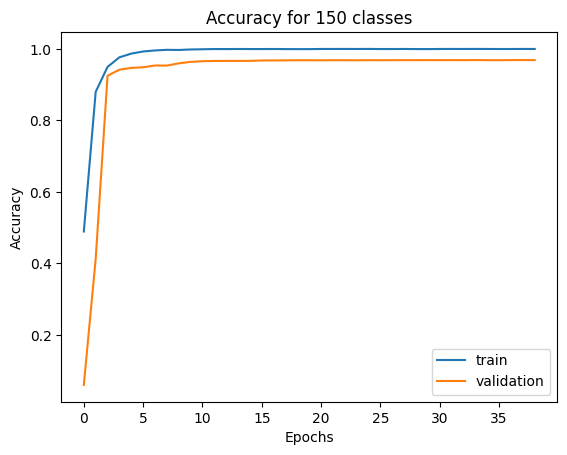

In [18]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes", "Accuracy")

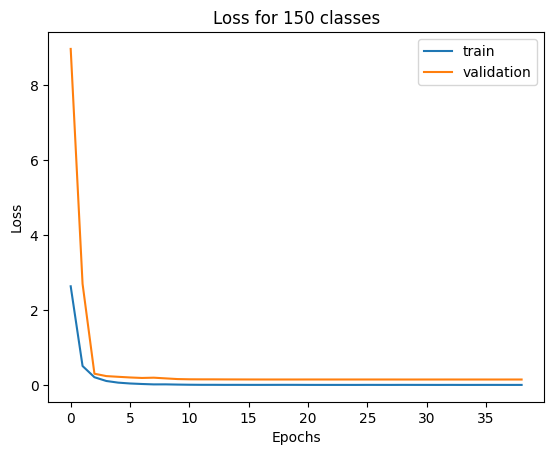

In [19]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes", "Loss")

In [20]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.1465066820383072 accuracy 0.9687020778656006


U+6C17 1.0 66.0
U+716E 1.0 73.0
U+7D19 1.0 79.0
U+8695 1.0 156.0
U+4E00 0.9981132075471698 530.0
U+662F 0.9959349593495935 246.0
U+5C71 0.9939024390243902 164.0
U+5341 0.9937888198757764 161.0
U+6C41 0.9936708860759493 158.0
U+4E0B 0.9933333333333333 150.0
U+4ED5 0.9927536231884058 138.0
U+751F 0.9921875 128.0
U+5BB6 0.9913793103448276 116.0
U+6238 0.9911504424778761 113.0
U+56FD 0.9901477832512315 203.0
U+5FA1 0.9895287958115183 191.0
U+5F15 0.9894736842105263 95.0
U+5FC3 0.9891304347826086 184.0
U+6CBB 0.9891304347826086 92.0
U+5C0F 0.9888475836431226 269.0
U+6851 0.9886363636363636 88.0
U+65B9 0.9885057471264368 261.0
U+9053 0.9879518072289156 83.0
U+898B 0.9875 320.0
U+4E2D 0.9873417721518988 237.0
U+624B 0.9872611464968153 157.0
U+53CA 0.987012987012987 77.0
U+5DE6 0.9868421052631579 76.0
U+795E 0.9868421052631579 76.0
U+4E91 0.9867924528301887 530.0
U+4F55 0.9862385321100917 218.0
U+7537 0.9857142857142858 70.0
U+7406 0.9855072463768116 69.0
U+4EAC 0.9850746268656716 67.0
U+5869 

In [31]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.1465066820383072 accuracy 0.9687020778656006


Per-class accuracy:
U+6C17: 1.00000 
U+716E: 1.00000 
U+7D19: 1.00000 
U+8695: 1.00000 
U+4E00: 0.99811 
U+662F: 0.99593 
U+5C71: 0.99390 
U+5341: 0.99379 
U+6C41: 0.99367 
U+4E0B: 0.99333 
U+4ED5: 0.99275 
U+751F: 0.99219 
U+5BB6: 0.99138 
U+6238: 0.99115 
U+56FD: 0.99015 
U+5FA1: 0.98953 
U+5F15: 0.98947 
U+5FC3: 0.98913 
U+6CBB: 0.98913 
U+5C0F: 0.98885 
U+6851: 0.98864 
U+65B9: 0.98851 
U+9053: 0.98795 
U+898B: 0.98750 
U+4E2D: 0.98734 
U+624B: 0.98726 
U+53CA: 0.98701 
U+5DE6: 0.98684 
U+795E: 0.98684 
U+4E91: 0.98679 
U+4F55: 0.98624 
U+7537: 0.98571 
U+7406: 0.98551 
U+4EAC: 0.98507 
U+5869: 0.98507 
U+79C1: 0.98462 
U+53E4: 0.98438 
U+53C8: 0.98391 
U+6216: 0.98333 
U+660E: 0.98333 
U+5375: 0.98305 
U+6728: 0.98291 
U+6C34: 0.98266 
U+5C45: 0.98261 
U+5165: 0.98148 
U+9CE5: 0.98113 
U+5927: 0.98101 
U+4EBA: 0.98097 
U+4E0A: 0.98077 
U+6B64: 0.98039 
U+4ECA: 0.97990 
U+592B: 0.97980 
U+4E16: 0.97945 
U+5207: 0.97872 
U+6240: 0.97872 
U+4E8B: 0.97809 
U+6708: 0.97744 
U+5408: 0.9

# 200 classes logic

In [23]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [24]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_200_stuff", model_name="200 classes")

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [01:06<00:00,  4.73s/it]

100%|██████████| 6/6 [00:44<00:00,  7.36s/it]


Epoch: 1
Train: loss 2.842667579650879 accuracy 0.4677119255065918
Validation: loss 8.99754810333252 accuracy 0.05659918114542961


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:49<00:00,  3.55s/it]

100%|██████████| 6/6 [00:19<00:00,  3.27s/it]


Epoch: 2
Train: loss 0.49482646584510803 accuracy 0.887907862663269
Validation: loss 1.6490609645843506 accuracy 0.5906016826629639


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:47<00:00,  3.38s/it]

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


Epoch: 3
Train: loss 0.17815609276294708 accuracy 0.961059033870697
Validation: loss 0.40197980403900146 accuracy 0.8995451927185059


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:42<00:00,  3.04s/it]

100%|██████████| 6/6 [00:18<00:00,  3.11s/it]


Epoch: 4
Train: loss 0.07528932392597198 accuracy 0.9849551916122437
Validation: loss 0.22447383403778076 accuracy 0.9422566890716553


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:39<00:00,  2.82s/it]

100%|██████████| 6/6 [00:17<00:00,  2.98s/it]


Epoch: 5
Train: loss 0.03884803503751755 accuracy 0.9929065108299255
Validation: loss 0.21481391787528992 accuracy 0.9453819394111633


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:41<00:00,  3.00s/it]

100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


Epoch: 6
Train: loss 0.02331683225929737 accuracy 0.996042788028717
Validation: loss 0.1953483670949936 accuracy 0.9509093165397644


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:39<00:00,  2.79s/it]

  7%|▋         | 7/100 [08:08<1:37:34, 62.96s/it]

Epoch: 7
Train: loss 0.017179833725094795 accuracy 0.9971598982810974
Validation: loss 0.19613346457481384 accuracy 0.9507372975349426



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:40<00:00,  2.87s/it]

100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


Epoch: 8
Train: loss 0.01002850104123354 accuracy 0.9985874891281128
Validation: loss 0.18666261434555054 accuracy 0.9545071721076965


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:37<00:00,  2.70s/it]

100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


Epoch: 9
Train: loss 0.007184064481407404 accuracy 0.9989714622497559
Validation: loss 0.17576637864112854 accuracy 0.9575462341308594


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

 10%|█         | 10/100 [10:57<1:26:36, 57.73s/it]

Epoch: 10
Train: loss 0.005855635739862919 accuracy 0.999233067035675
Validation: loss 0.17774072289466858 accuracy 0.9571550488471985



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.50s/it]

100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


Epoch: 11
Train: loss 0.004561538342386484 accuracy 0.9993202090263367
Validation: loss 0.16938510537147522 accuracy 0.9594101309776306


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.44s/it]

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Epoch: 12
Train: loss 0.003884504083544016 accuracy 0.9993202090263367
Validation: loss 0.1675727665424347 accuracy 0.960164487361908


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Epoch: 13
Train: loss 0.003643185133114457 accuracy 0.9994593858718872
Validation: loss 0.16392844915390015 accuracy 0.9610032439231873


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


Epoch: 14
Train: loss 0.0033341438975185156 accuracy 0.9994942545890808
Validation: loss 0.16323751211166382 accuracy 0.961054801940918


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.52s/it]

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


Epoch: 15
Train: loss 0.0029210869688540697 accuracy 0.9995643496513367
Validation: loss 0.1634717583656311 accuracy 0.9613584876060486


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

 16%|█▌        | 16/100 [16:08<1:13:23, 52.43s/it]

Epoch: 16
Train: loss 0.00233668927103281 accuracy 0.9996861219406128
Validation: loss 0.1632230281829834 accuracy 0.9612066745758057



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.44s/it]

100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


Epoch: 17
Train: loss 0.0020235865376889706 accuracy 0.9997565150260925
Validation: loss 0.16300508379936218 accuracy 0.961513340473175


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:36<00:00,  2.59s/it]

100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


Epoch: 18
Train: loss 0.0023774958681315184 accuracy 0.9996515512466431
Validation: loss 0.162377268075943 accuracy 0.9618279337882996


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.40s/it]

 19%|█▉        | 19/100 [18:44<1:10:11, 52.00s/it]

Epoch: 19
Train: loss 0.002026608679443598 accuracy 0.999755859375
Validation: loss 0.162191241979599 accuracy 0.961806058883667



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.51s/it]

 20%|██        | 20/100 [19:36<1:09:14, 51.94s/it]

Epoch: 20
Train: loss 0.0021580541506409645 accuracy 0.9997038841247559
Validation: loss 0.16206158697605133 accuracy 0.9615728855133057



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.51s/it]

 21%|██        | 21/100 [20:27<1:08:21, 51.92s/it]

Epoch: 21
Train: loss 0.0020927386358380318 accuracy 0.9997035264968872
Validation: loss 0.16190755367279053 accuracy 0.9617168307304382



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.52s/it]

100%|██████████| 6/6 [00:17<00:00,  2.91s/it]


Epoch: 22
Train: loss 0.002161461627110839 accuracy 0.9997035264968872
Validation: loss 0.1619240790605545 accuracy 0.9619609713554382


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:36<00:00,  2.61s/it]

 23%|██▎       | 23/100 [22:15<1:07:59, 52.98s/it]

Epoch: 23
Train: loss 0.0026518008671700954 accuracy 0.9995298385620117
Validation: loss 0.1618112027645111 accuracy 0.961787223815918



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.55s/it]

 24%|██▍       | 24/100 [23:08<1:07:00, 52.90s/it]

Epoch: 24
Train: loss 0.0022129591088742018 accuracy 0.9996173977851868
Validation: loss 0.16188369691371918 accuracy 0.961787223815918



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

 25%|██▌       | 25/100 [24:01<1:06:06, 52.89s/it]

Epoch: 25
Train: loss 0.0020964031573385 accuracy 0.9996686577796936
Validation: loss 0.1618851125240326 accuracy 0.9618279337882996



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.50s/it]

 26%|██▌       | 26/100 [24:53<1:04:57, 52.67s/it]

Epoch: 26
Train: loss 0.0019140432123094797 accuracy 0.9997733235359192
Validation: loss 0.16192206740379333 accuracy 0.9617465138435364



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

 26%|██▌       | 26/100 [25:44<1:13:14, 59.39s/it]

Epoch: 27
Train: loss 0.0020324622746556997 accuracy 0.9996337890625
Validation: loss 0.1619689166545868 accuracy 0.9618170261383057
Best validation accuracy for 200 classes: 0.9619609713554382 Epoch 22


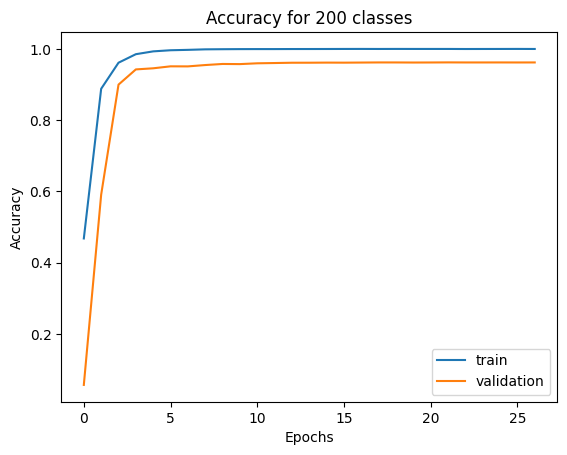

In [25]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes", "Accuracy")

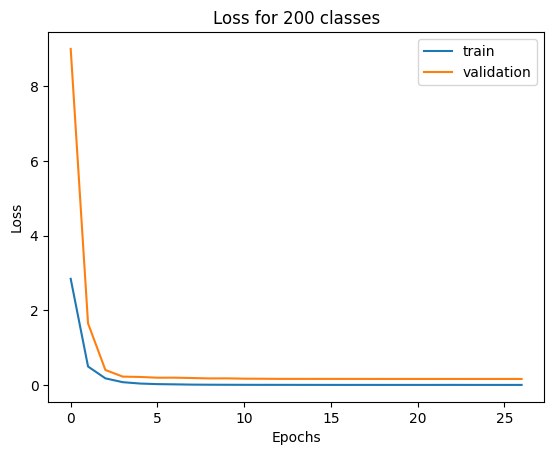

In [26]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes", "Loss")

In [27]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.1619240790605545 accuracy 0.9619609713554382


U+5341 1.0 161.0
U+5473 1.0 98.0
U+5869 1.0 67.0
U+5DDD 1.0 59.0
U+6C41 1.0 158.0
U+7537 1.0 70.0
U+8FD1 1.0 51.0
U+985E 1.0 46.0
U+4E91 0.9981132075471698 530.0
U+5C0F 0.9962825278810409 269.0
U+53C8 0.9954022988505747 435.0
U+5973 0.9953703703703703 216.0
U+4E00 0.9943396226415094 530.0
U+8EAB 0.9939759036144579 166.0
U+6B64 0.9934640522875817 306.0
U+4E16 0.9931506849315068 146.0
U+6C5F 0.9915966386554622 119.0
U+5C45 0.991304347826087 115.0
U+4F55 0.9908256880733946 218.0
U+5185 0.9905660377358491 106.0
U+5207 0.9893617021276596 94.0
U+524D 0.9887640449438202 178.0
U+4E0A 0.9884615384615385 260.0
U+4E8B 0.9880478087649402 502.0
U+9B5A 0.9879518072289156 83.0
U+662F 0.9878048780487805 246.0
U+5929 0.9873417721518988 79.0
U+795E 0.9868421052631579 76.0
U+5409 0.9863945578231292 147.0
U+7A2E 0.9863013698630136 73.0
U+4ED5 0.9855072463768116 138.0
U+4EAC 0.9850746268656716 67.0
U+898B 0.984375 320.0
U+713C 0.9841269841269841 63.0
U+901A 0.9841269841269841 63.0
U+7269 0.9833333333333333

In [32]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.1619240790605545 accuracy 0.9619609713554382


Per-class accuracy:
U+5341: 1.00000 
U+5473: 1.00000 
U+5869: 1.00000 
U+5DDD: 1.00000 
U+6C41: 1.00000 
U+7537: 1.00000 
U+8FD1: 1.00000 
U+985E: 1.00000 
U+4E91: 0.99811 
U+5C0F: 0.99628 
U+53C8: 0.99540 
U+5973: 0.99537 
U+4E00: 0.99434 
U+8EAB: 0.99398 
U+6B64: 0.99346 
U+4E16: 0.99315 
U+6C5F: 0.99160 
U+5C45: 0.99130 
U+4F55: 0.99083 
U+5185: 0.99057 
U+5207: 0.98936 
U+524D: 0.98876 
U+4E0A: 0.98846 
U+4E8B: 0.98805 
U+9B5A: 0.98795 
U+662F: 0.98780 
U+5929: 0.98734 
U+795E: 0.98684 
U+5409: 0.98639 
U+7A2E: 0.98630 
U+4ED5: 0.98551 
U+4EAC: 0.98507 
U+898B: 0.98438 
U+713C: 0.98413 
U+901A: 0.98413 
U+7269: 0.98333 
U+4E09: 0.98319 
U+65E5: 0.98188 
U+81EA: 0.98113 
U+805E: 0.98077 
U+5B50: 0.98065 
U+5176: 0.98007 
U+4E0B: 0.98000 
U+592B: 0.97980 
U+5148: 0.97959 
U+5F15: 0.97895 
U+5165: 0.97884 
U+7533: 0.97842 
U+7AF9: 0.97826 
U+5F97: 0.97778 
U+6851: 0.97727 
U+56DB: 0.97710 
U+540D: 0.97674 
U+9593: 0.97561 
U+4ECA: 0.97487 
U+7ACB: 0.97436 
U+8695: 0.97436 
U+91CE: 0.9

# 300 classes logic

In [33]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size=4096, classamount=300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [34]:
# Train loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_300_stuff", model_name="300 classes")

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [01:12<00:00,  4.51s/it]

100%|██████████| 7/7 [00:49<00:00,  7.12s/it]


Epoch: 1
Train: loss 3.111497402191162 accuracy 0.43464550375938416
Validation: loss 11.133265495300293 accuracy 0.01797623001039028


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:48<00:00,  3.05s/it]

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 2
Train: loss 0.5751000046730042 accuracy 0.8728674054145813
Validation: loss 1.1737384796142578 accuracy 0.7150728106498718


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:43<00:00,  2.72s/it]

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 3
Train: loss 0.1865488737821579 accuracy 0.9599968194961548
Validation: loss 0.3779318034648895 accuracy 0.9085144400596619


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:41<00:00,  2.59s/it]

100%|██████████| 7/7 [00:17<00:00,  2.50s/it]


Epoch: 4
Train: loss 0.07970504462718964 accuracy 0.9840790629386902
Validation: loss 0.3001698851585388 accuracy 0.9257879853248596


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:39<00:00,  2.48s/it]

100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 5
Train: loss 0.04294394329190254 accuracy 0.99204421043396
Validation: loss 0.29520881175994873 accuracy 0.9292818903923035


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:39<00:00,  2.44s/it]

100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Epoch: 6
Train: loss 0.029103808104991913 accuracy 0.9946088790893555
Validation: loss 0.2754414677619934 accuracy 0.9366081953048706


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 7
Train: loss 0.018924178555607796 accuracy 0.9966289401054382
Validation: loss 0.2540145814418793 accuracy 0.9410120248794556


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.39s/it]

100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


Epoch: 8
Train: loss 0.014327989891171455 accuracy 0.9977040886878967
Validation: loss 0.2535798251628876 accuracy 0.9413115382194519


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.39s/it]

100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 9
Train: loss 0.01141627412289381 accuracy 0.9981008172035217
Validation: loss 0.2476215362548828 accuracy 0.9438073039054871


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:40<00:00,  2.55s/it]

100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


Epoch: 10
Train: loss 0.007252922747284174 accuracy 0.9989095330238342
Validation: loss 0.23580479621887207 accuracy 0.9464631676673889


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.44s/it]

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 11
Train: loss 0.005775772035121918 accuracy 0.9993133544921875
Validation: loss 0.21891948580741882 accuracy 0.9507171511650085


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.38s/it]

100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 12
Train: loss 0.00449569895863533 accuracy 0.9994717836380005
Validation: loss 0.21489030122756958 accuracy 0.9516434669494629


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.37s/it]

100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Epoch: 13
Train: loss 0.003185533219948411 accuracy 0.999670147895813
Validation: loss 0.2147778421640396 accuracy 0.9519070982933044


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.33s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 14
Train: loss 0.0033130059018731117 accuracy 0.999548077583313
Validation: loss 0.2135731428861618 accuracy 0.9519727826118469


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.36s/it]

100%|██████████| 7/7 [00:16<00:00,  2.40s/it]


Epoch: 15
Train: loss 0.0029430738650262356 accuracy 0.999609112739563
Validation: loss 0.2124241441488266 accuracy 0.9523800015449524


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Epoch: 16
Train: loss 0.00238084327429533 accuracy 0.9997218251228333
Validation: loss 0.21238651871681213 accuracy 0.9524959325790405


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


Epoch: 17
Train: loss 0.003108740784227848 accuracy 0.9996455311775208
Validation: loss 0.21185868978500366 accuracy 0.9525389671325684


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 18
Train: loss 0.0028657664079219103 accuracy 0.9996185302734375
Validation: loss 0.212020143866539 accuracy 0.952674388885498


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.31s/it]

100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 19
Train: loss 0.0025619864463806152 accuracy 0.9996490478515625
Validation: loss 0.21195019781589508 accuracy 0.952833354473114


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:41<00:00,  2.60s/it]

 20%|██        | 20/100 [20:15<1:16:02, 57.03s/it]

Epoch: 20
Train: loss 0.001958999549970031 accuracy 0.999786376953125
Validation: loss 0.21082668006420135 accuracy 0.9526938796043396



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 21
Train: loss 0.0026357939932495356 accuracy 0.999664306640625
Validation: loss 0.21117910742759705 accuracy 0.9528528451919556


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

 22%|██▏       | 22/100 [22:05<1:12:34, 55.83s/it]

Epoch: 22
Train: loss 0.0024464826565235853 accuracy 0.999603271484375
Validation: loss 0.21115361154079437 accuracy 0.952833354473114



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch: 23
Train: loss 0.0020195278339087963 accuracy 0.9997828602790833
Validation: loss 0.2108411192893982 accuracy 0.9529882669448853


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

100%|██████████| 7/7 [00:16<00:00,  2.40s/it]


Epoch: 24
Train: loss 0.0023587788455188274 accuracy 0.9996795654296875
Validation: loss 0.21084080636501312 accuracy 0.9530231356620789


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 25
Train: loss 0.002047392074018717 accuracy 0.9997464418411255
Validation: loss 0.21086077392101288 accuracy 0.9533524513244629


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

100%|██████████| 7/7 [00:17<00:00,  2.54s/it]


Epoch: 26
Train: loss 0.0024514866527169943 accuracy 0.9996548891067505
Validation: loss 0.2106216847896576 accuracy 0.9533832669258118


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 27%|██▋       | 27/100 [26:39<1:07:01, 55.08s/it]

Epoch: 27
Train: loss 0.0021614120341837406 accuracy 0.9996913075447083
Validation: loss 0.21045558154582977 accuracy 0.9533134698867798



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch: 28
Train: loss 0.0015717239584773779 accuracy 0.9999237060546875
Validation: loss 0.2105979323387146 accuracy 0.9534181356430054


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

 29%|██▉       | 29/100 [28:28<1:04:46, 54.75s/it]

Epoch: 29
Train: loss 0.0019218104425817728 accuracy 0.9997769594192505
Validation: loss 0.210486501455307 accuracy 0.9534026980400085



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 30%|███       | 30/100 [29:22<1:03:36, 54.52s/it]

Epoch: 30
Train: loss 0.002274619648233056 accuracy 0.9996548891067505
Validation: loss 0.21044595539569855 accuracy 0.9533678293228149



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.33s/it]

100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch: 31
Train: loss 0.0019548109266906977 accuracy 0.9998074769973755
Validation: loss 0.2104557901620865 accuracy 0.9535422325134277


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 32%|███▏      | 32/100 [31:12<1:02:01, 54.73s/it]

Epoch: 32
Train: loss 0.0021423394791781902 accuracy 0.9997159242630005
Validation: loss 0.21042756736278534 accuracy 0.9535227417945862



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

 33%|███▎      | 33/100 [32:06<1:00:54, 54.54s/it]

Epoch: 33
Train: loss 0.0021302117966115475 accuracy 0.9997159242630005
Validation: loss 0.21038846671581268 accuracy 0.9532980918884277



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

 34%|███▍      | 34/100 [33:01<1:00:14, 54.76s/it]

Epoch: 34
Train: loss 0.0018038959242403507 accuracy 0.9998016357421875
Validation: loss 0.21036414802074432 accuracy 0.9534376263618469



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

 35%|███▌      | 35/100 [33:56<59:22, 54.80s/it]  

Epoch: 35
Train: loss 0.0018189321272075176 accuracy 0.999847412109375
Validation: loss 0.21043623983860016 accuracy 0.9535073637962341



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

 35%|███▌      | 35/100 [34:50<1:04:42, 59.73s/it]

Epoch: 36
Train: loss 0.001971730263903737 accuracy 0.9997464418411255
Validation: loss 0.2104378491640091 accuracy 0.953453004360199
Best validation accuracy for 300 classes: 0.9535422325134277 Epoch 31


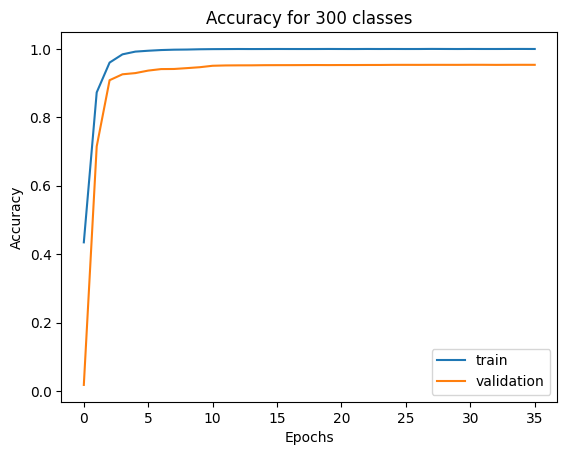

In [35]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes", "Accuracy")

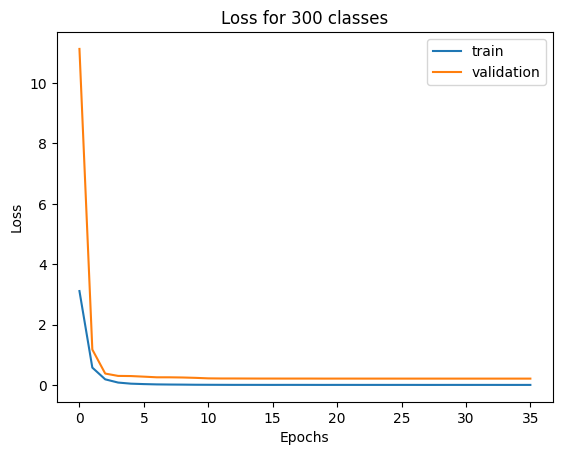

In [36]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes", "Loss")

In [37]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.2104557901620865 accuracy 0.9535422325134277


U+4F3C 1.0 34.0
U+5150 1.0 34.0
U+52A0 1.0 48.0
U+5411 1.0 33.0
U+547C 1.0 52.0
U+60C5 1.0 38.0
U+66FF 1.0 34.0
U+6851 1.0 88.0
U+6B63 1.0 37.0
U+6BCD 1.0 33.0
U+6CB9 1.0 40.0
U+713C 1.0 63.0
U+7537 1.0 70.0
U+757F 1.0 36.0
U+9060 1.0 39.0
U+91CC 1.0 43.0
U+4E00 0.9981132075471698 530.0
U+53C8 0.9954022988505747 435.0
U+4ECA 0.9949748743718593 199.0
U+4E91 0.9943396226415094 530.0
U+898B 0.99375 320.0
U+4E0B 0.9933333333333333 150.0
U+5C0F 0.9925650557620818 269.0
U+5165 0.9920634920634921 378.0
U+662F 0.991869918699187 246.0
U+6C5F 0.9915966386554622 119.0
U+601D 0.991304347826087 115.0
U+4F55 0.9908256880733946 218.0
U+5F15 0.9894736842105263 95.0
U+5207 0.9893617021276596 94.0
U+6CBB 0.9891304347826086 92.0
U+5341 0.9875776397515528 161.0
U+6C41 0.9873417721518988 158.0
U+98DF 0.9873417721518988 79.0
U+7D66 0.9872611464968153 157.0
U+516B 0.987012987012987 77.0
U+5DE6 0.9868421052631579 76.0
U+4E16 0.9863013698630136 146.0
U+4EAC 0.9850746268656716 67.0
U+9152 0.9846153846153847 130

In [38]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:16

Test: loss 0.2104557901620865 accuracy 0.9535422325134277


Per-class accuracy:
U+4F3C: 1.00000 
U+5150: 1.00000 
U+52A0: 1.00000 
U+5411: 1.00000 
U+547C: 1.00000 
U+60C5: 1.00000 
U+66FF: 1.00000 
U+6851: 1.00000 
U+6B63: 1.00000 
U+6BCD: 1.00000 
U+6CB9: 1.00000 
U+713C: 1.00000 
U+7537: 1.00000 
U+757F: 1.00000 
U+9060: 1.00000 
U+91CC: 1.00000 
U+4E00: 0.99811 
U+53C8: 0.99540 
U+4ECA: 0.99497 
U+4E91: 0.99434 
U+898B: 0.99375 
U+4E0B: 0.99333 
U+5C0F: 0.99257 
U+5165: 0.99206 
U+662F: 0.99187 
U+6C5F: 0.99160 
U+601D: 0.99130 
U+4F55: 0.99083 
U+5F15: 0.98947 
U+5207: 0.98936 
U+6CBB: 0.98913 
U+5341: 0.98758 
U+6C41: 0.98734 
U+98DF: 0.98734 
U+7D66: 0.98726 
U+516B: 0.98701 
U+5DE6: 0.98684 
U+4E16: 0.98630 
U+4EAC: 0.98507 
U+9152: 0.98462 
U+6771: 0.98413 
U+706B: 0.98361 
U+4E09: 0.98319 
U+5375: 0.98305 
U+6238: 0.98230 
U+767D: 0.98230 
U+8C46: 0.98214 
U+8D8A: 0.98182 
U+5C71: 0.98171 
U+6D77: 0.98077 
U+8695: 0.98077 
U+76BF: 0.98039 
U+4E5D: 0.98000 
U+4E8C: 0.98000 
U+6642: 0.98000 
U+5148: 0.97959 
U+5473: 0.97959 
U+95A2: 0.9

# Augmented, 150 classes logic

In [40]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_150_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [41]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_150_stuff", model_name="150 classes augmented")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.32s/it]

100%|██████████| 6/6 [00:16<00:00,  2.77s/it]


Epoch: 1
Train: loss 2.7205498218536377 accuracy 0.4714638292789459
Validation: loss 10.009317398071289 accuracy 0.042457450181245804


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.28s/it]

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Epoch: 2
Train: loss 0.5604984164237976 accuracy 0.8686822652816772
Validation: loss 2.3613369464874268 accuracy 0.45586705207824707


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


Epoch: 3
Train: loss 0.2117035686969757 accuracy 0.9500877857208252
Validation: loss 0.33427029848098755 accuracy 0.9180691838264465


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.28s/it]

100%|██████████| 6/6 [00:17<00:00,  3.00s/it]


Epoch: 4
Train: loss 0.11557576060295105 accuracy 0.9739764332771301
Validation: loss 0.2611124813556671 accuracy 0.9355989098548889


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:32<00:00,  2.47s/it]

100%|██████████| 6/6 [00:18<00:00,  3.02s/it]


Epoch: 5
Train: loss 0.0684625431895256 accuracy 0.9853200316429138
Validation: loss 0.21674606204032898 accuracy 0.9444375038146973


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:31<00:00,  2.41s/it]

100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


Epoch: 6
Train: loss 0.04447843134403229 accuracy 0.9897580742835999
Validation: loss 0.19043730199337006 accuracy 0.9539392590522766


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.31s/it]

  7%|▋         | 7/100 [05:34<1:14:19, 47.95s/it]

Epoch: 7
Train: loss 0.035410404205322266 accuracy 0.9929007291793823
Validation: loss 0.2076759785413742 accuracy 0.9490250945091248



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

  8%|▊         | 8/100 [06:20<1:12:38, 47.37s/it]

Epoch: 8
Train: loss 0.02532561868429184 accuracy 0.9956617951393127
Validation: loss 0.19898998737335205 accuracy 0.9490476250648499



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.31s/it]

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch: 9
Train: loss 0.014498240314424038 accuracy 0.9977651834487915
Validation: loss 0.18005160987377167 accuracy 0.9566490054130554


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch: 10
Train: loss 0.011219564825296402 accuracy 0.9985914826393127
Validation: loss 0.18239688873291016 accuracy 0.9571840167045593


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.29s/it]

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch: 11
Train: loss 0.0077711911872029305 accuracy 0.9989858865737915
Validation: loss 0.16368728876113892 accuracy 0.9628036618232727


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.24s/it]

100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


Epoch: 12
Train: loss 0.00518388394266367 accuracy 0.9992488026618958
Validation: loss 0.1568659543991089 accuracy 0.9644191861152649


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.28s/it]

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch: 13
Train: loss 0.004177649971097708 accuracy 0.9996055960655212
Validation: loss 0.15472730994224548 accuracy 0.9648200869560242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.29s/it]

100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


Epoch: 14
Train: loss 0.003615881782025099 accuracy 0.9996243715286255
Validation: loss 0.15347877144813538 accuracy 0.965349018573761


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.36s/it]

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Epoch: 15
Train: loss 0.003947049379348755 accuracy 0.9995304942131042
Validation: loss 0.15236157178878784 accuracy 0.96602863073349


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.31s/it]

100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


Epoch: 16
Train: loss 0.003153903177008033 accuracy 0.999680757522583
Validation: loss 0.15174183249473572 accuracy 0.9669870734214783


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.37s/it]

 17%|█▋        | 17/100 [13:25<1:07:02, 48.46s/it]

Epoch: 17
Train: loss 0.0035774598363786936 accuracy 0.9995492696762085
Validation: loss 0.1516479104757309 accuracy 0.966952383518219



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:33<00:00,  2.54s/it]

 18%|█▊        | 18/100 [14:17<1:07:27, 49.36s/it]

Epoch: 18
Train: loss 0.0035389955155551434 accuracy 0.9995680451393127
Validation: loss 0.15157964825630188 accuracy 0.9664354920387268



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:32<00:00,  2.48s/it]

 19%|█▉        | 19/100 [15:07<1:06:53, 49.55s/it]

Epoch: 19
Train: loss 0.0030211047269403934 accuracy 0.9996055960655212
Validation: loss 0.15052610635757446 accuracy 0.9667264819145203



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:31<00:00,  2.46s/it]

 20%|██        | 20/100 [15:55<1:05:37, 49.22s/it]

Epoch: 20
Train: loss 0.0024649829138070345 accuracy 0.9998121857643127
Validation: loss 0.15037265419960022 accuracy 0.9665290713310242



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:30<00:00,  2.33s/it]

 20%|██        | 20/100 [16:42<1:06:49, 50.12s/it]

Epoch: 21
Train: loss 0.002588666509836912 accuracy 0.9996995329856873
Validation: loss 0.15032196044921875 accuracy 0.9661688804626465
Best validation accuracy for 150 classes augmented: 0.9669870734214783 Epoch 16


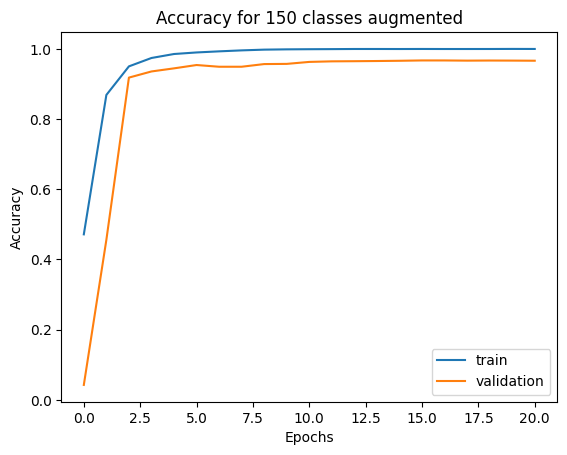

In [42]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes augmented", "Accuracy")

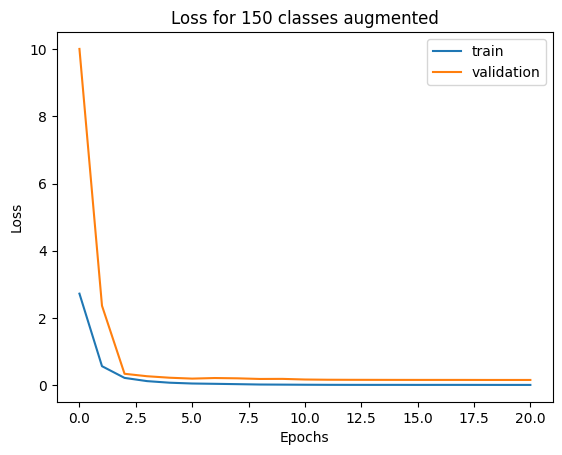

In [43]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes augmented", "Loss")

In [44]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_augmented_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.15174183249473572 accuracy 0.9669870734214783


U+4EAC 1.0 67.0
U+5207 1.0 94.0
U+716E 1.0 73.0
U+7406 1.0 69.0
U+7530 1.0 59.0
U+795E 1.0 76.0
U+8695 1.0 156.0
U+4E00 0.9981132075471698 530.0
U+662F 0.9959349593495935 246.0
U+4E0B 0.9933333333333333 150.0
U+4ED5 0.9927536231884058 138.0
U+56DB 0.9923664122137404 131.0
U+65B9 0.9923371647509579 261.0
U+6238 0.9911504424778761 113.0
U+4F55 0.9908256880733946 218.0
U+9CE5 0.9905660377358491 106.0
U+5473 0.9897959183673469 98.0
U+5F15 0.9894736842105263 95.0
U+548C 0.9893617021276596 94.0
U+5FC3 0.9891304347826086 184.0
U+6CBB 0.9891304347826086 92.0
U+5C0F 0.9888475836431226 269.0
U+6851 0.9886363636363636 88.0
U+53C8 0.9885057471264368 435.0
U+5341 0.9875776397515528 161.0
U+6C41 0.9873417721518988 158.0
U+7D19 0.9873417721518988 79.0
U+98DF 0.9873417721518988 79.0
U+516B 0.987012987012987 77.0
U+53CA 0.987012987012987 77.0
U+6211 0.9861111111111112 72.0
U+7269 0.9861111111111112 360.0
U+7537 0.9857142857142858 70.0
U+4ECA 0.9849246231155779 199.0
U+6C17 0.9848484848484849 66.0
U+53E

In [45]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_augmented_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.15174183249473572 accuracy 0.9669870734214783


Per-class accuracy:
U+4EAC: 1.00000 
U+5207: 1.00000 
U+716E: 1.00000 
U+7406: 1.00000 
U+7530: 1.00000 
U+795E: 1.00000 
U+8695: 1.00000 
U+4E00: 0.99811 
U+662F: 0.99593 
U+4E0B: 0.99333 
U+4ED5: 0.99275 
U+56DB: 0.99237 
U+65B9: 0.99234 
U+6238: 0.99115 
U+4F55: 0.99083 
U+9CE5: 0.99057 
U+5473: 0.98980 
U+5F15: 0.98947 
U+548C: 0.98936 
U+5FC3: 0.98913 
U+6CBB: 0.98913 
U+5C0F: 0.98885 
U+6851: 0.98864 
U+53C8: 0.98851 
U+5341: 0.98758 
U+6C41: 0.98734 
U+7D19: 0.98734 
U+98DF: 0.98734 
U+516B: 0.98701 
U+53CA: 0.98701 
U+6211: 0.98611 
U+7269: 0.98611 
U+7537: 0.98571 
U+4ECA: 0.98492 
U+6C17: 0.98485 
U+53E4: 0.98438 
U+751F: 0.98438 
U+898B: 0.98438 
U+5FA1: 0.98429 
U+8349: 0.98413 
U+4E8B: 0.98406 
U+6216: 0.98333 
U+5375: 0.98305 
U+5C45: 0.98261 
U+4E91: 0.98113 
U+4EBA: 0.98097 
U+624B: 0.98089 
U+56FD: 0.98030 
U+4E09: 0.97899 
U+6708: 0.97744 
U+540D: 0.97674 
U+5165: 0.97619 
U+5C71: 0.97561 
U+6642: 0.97500 
U+98A8: 0.97436 
U+5BB6: 0.97414 
U+82B1: 0.97414 
U+601D: 0.9

# Augmented, 200 classes logic

In [46]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_200_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [47]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_200_stuff", model_name="200 classes augmented")

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.55s/it]

100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


Epoch: 1
Train: loss 2.859039068222046 accuracy 0.4631339907646179
Validation: loss 13.815436363220215 accuracy 0.009190821088850498


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.52s/it]

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


Epoch: 2
Train: loss 0.5254006385803223 accuracy 0.883759081363678
Validation: loss 2.3876004219055176 accuracy 0.4419924020767212


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


Epoch: 3
Train: loss 0.1806354969739914 accuracy 0.9607595205307007
Validation: loss 0.41270673274993896 accuracy 0.8925547003746033


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:36<00:00,  2.58s/it]

100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


Epoch: 4
Train: loss 0.07795979827642441 accuracy 0.9841191172599792
Validation: loss 0.229486346244812 accuracy 0.9416747093200684


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Epoch: 5
Train: loss 0.03990214690566063 accuracy 0.9925393462181091
Validation: loss 0.19564221799373627 accuracy 0.9507482647895813


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:16<00:00,  2.77s/it]


Epoch: 6
Train: loss 0.02665841020643711 accuracy 0.9957118034362793
Validation: loss 0.19237492978572845 accuracy 0.9521427154541016


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

  7%|▋         | 7/100 [06:05<1:19:43, 51.43s/it]

Epoch: 7
Train: loss 0.01605038531124592 accuracy 0.9973164796829224
Validation: loss 0.20023146271705627 accuracy 0.9501129984855652



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Epoch: 8
Train: loss 0.01242141891270876 accuracy 0.998134434223175
Validation: loss 0.18338412046432495 accuracy 0.9555729031562805


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.48s/it]

  9%|▉         | 9/100 [07:47<1:17:36, 51.17s/it]

Epoch: 9
Train: loss 0.011226724833250046 accuracy 0.9981894493103027
Validation: loss 0.19191448390483856 accuracy 0.9536277651786804



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


Epoch: 10
Train: loss 0.00665355334058404 accuracy 0.9991632699966431
Validation: loss 0.18201977014541626 accuracy 0.9559141993522644


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

100%|██████████| 6/6 [00:17<00:00,  2.83s/it]


Epoch: 11
Train: loss 0.0050394246354699135 accuracy 0.999233067035675
Validation: loss 0.16738353669643402 accuracy 0.9598169922828674


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.55s/it]

100%|██████████| 6/6 [00:16<00:00,  2.82s/it]


Epoch: 12
Train: loss 0.0037422545719891787 accuracy 0.9995989203453064
Validation: loss 0.16403643786907196 accuracy 0.9608640670776367


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

100%|██████████| 6/6 [00:16<00:00,  2.72s/it]


Epoch: 13
Train: loss 0.003373644780367613 accuracy 0.9995643496513367
Validation: loss 0.1617567539215088 accuracy 0.9611755013465881


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


Epoch: 14
Train: loss 0.003645353950560093 accuracy 0.9993900060653687
Validation: loss 0.1613694727420807 accuracy 0.961829662322998


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.48s/it]

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


Epoch: 15
Train: loss 0.0033040991984307766 accuracy 0.9994942545890808
Validation: loss 0.1606919914484024 accuracy 0.9618703722953796


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.53s/it]

 16%|█▌        | 16/100 [13:52<1:12:59, 52.14s/it]

Epoch: 16
Train: loss 0.0026703013572841883 accuracy 0.9996515512466431
Validation: loss 0.15988948941230774 accuracy 0.9617671370506287



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.50s/it]

 17%|█▋        | 17/100 [14:44<1:12:02, 52.07s/it]

Epoch: 17
Train: loss 0.002275476697832346 accuracy 0.9997383952140808
Validation: loss 0.1598590463399887 accuracy 0.9618563652038574



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.50s/it]

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]


Epoch: 18
Train: loss 0.002233245177194476 accuracy 0.9997209906578064
Validation: loss 0.15982794761657715 accuracy 0.9620112776756287


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.51s/it]

100%|██████████| 6/6 [00:17<00:00,  2.84s/it]


Epoch: 19
Train: loss 0.0023202509619295597 accuracy 0.9996686577796936
Validation: loss 0.1582397222518921 accuracy 0.9621630311012268


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:36<00:00,  2.61s/it]

 20%|██        | 20/100 [17:23<1:10:34, 52.93s/it]

Epoch: 20
Train: loss 0.002082291292026639 accuracy 0.9997209906578064
Validation: loss 0.15842393040657043 accuracy 0.961981475353241



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

 21%|██        | 21/100 [18:15<1:09:18, 52.64s/it]

Epoch: 21
Train: loss 0.0017476308858022094 accuracy 0.9997907280921936
Validation: loss 0.158633291721344 accuracy 0.9617858529090881



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.45s/it]

 22%|██▏       | 22/100 [19:07<1:07:53, 52.22s/it]

Epoch: 22
Train: loss 0.0018084809416905046 accuracy 0.9997907280921936
Validation: loss 0.15862545371055603 accuracy 0.961775004863739



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

 23%|██▎       | 23/100 [19:57<1:06:11, 51.58s/it]

Epoch: 23
Train: loss 0.002144366502761841 accuracy 0.9996864199638367
Validation: loss 0.15864960849285126 accuracy 0.9616935849189758



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

 23%|██▎       | 23/100 [20:47<1:09:37, 54.25s/it]

Epoch: 24
Train: loss 0.002059126039966941 accuracy 0.9997387528419495
Validation: loss 0.15848663449287415 accuracy 0.9618672728538513
Best validation accuracy for 200 classes augmented: 0.9621630311012268 Epoch 19


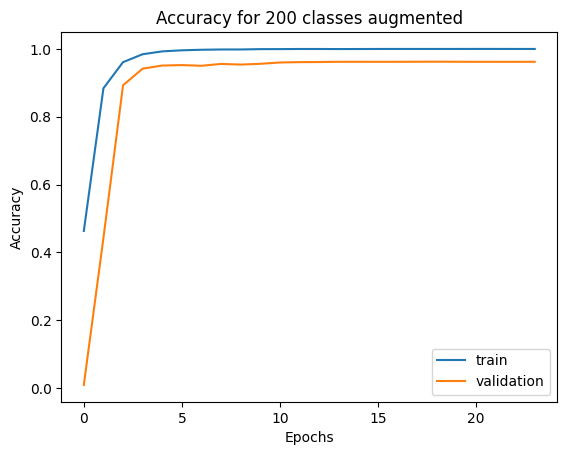

In [48]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes augmented", "Accuracy")

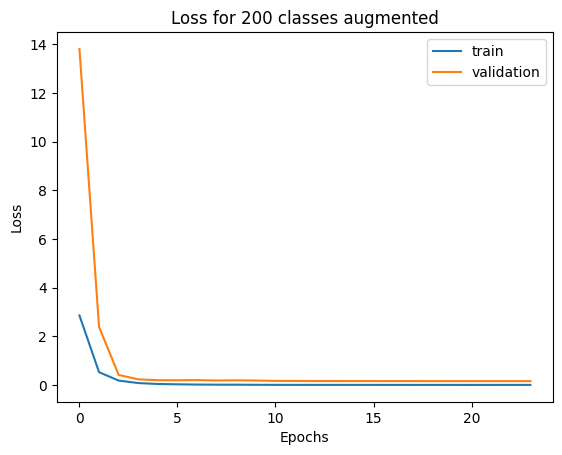

In [49]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes augmented", "Loss")

In [50]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_augmented_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.1582397222518921 accuracy 0.9621630311012268


U+5185 1.0 106.0
U+5341 1.0 161.0
U+6C41 1.0 158.0
U+7537 1.0 70.0
U+795E 1.0 76.0
U+4E91 0.9981132075471698 530.0
U+4E00 0.9962264150943396 530.0
U+662F 0.9959349593495935 246.0
U+4F55 0.9954128440366973 218.0
U+4E16 0.9931506849315068 146.0
U+5BB6 0.9913793103448276 116.0
U+6238 0.9911504424778761 113.0
U+53C8 0.9908045977011494 435.0
U+5473 0.9897959183673469 98.0
U+548C 0.9893617021276596 94.0
U+524D 0.9887640449438202 178.0
U+6851 0.9886363636363636 88.0
U+9B5A 0.9879518072289156 83.0
U+9593 0.9878048780487805 82.0
U+5929 0.9873417721518988 79.0
U+4E0B 0.9866666666666667 150.0
U+5409 0.9863945578231292 147.0
U+7A2E 0.9863013698630136 73.0
U+5973 0.9861111111111112 216.0
U+7269 0.9861111111111112 360.0
U+7406 0.9855072463768116 69.0
U+5C0F 0.9851301115241635 269.0
U+4EAC 0.9850746268656716 67.0
U+592A 0.9848484848484849 66.0
U+898B 0.984375 320.0
U+713C 0.9841269841269841 63.0
U+6B64 0.9836601307189542 306.0
U+6216 0.9833333333333333 60.0
U+4E09 0.9831932773109243 238.0
U+6C5F 0.98

In [51]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_augmented_200_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.1582397222518921 accuracy 0.9621630311012268


Per-class accuracy:
U+5185: 1.00000 
U+5341: 1.00000 
U+6C41: 1.00000 
U+7537: 1.00000 
U+795E: 1.00000 
U+4E91: 0.99811 
U+4E00: 0.99623 
U+662F: 0.99593 
U+4F55: 0.99541 
U+4E16: 0.99315 
U+5BB6: 0.99138 
U+6238: 0.99115 
U+53C8: 0.99080 
U+5473: 0.98980 
U+548C: 0.98936 
U+524D: 0.98876 
U+6851: 0.98864 
U+9B5A: 0.98795 
U+9593: 0.98780 
U+5929: 0.98734 
U+4E0B: 0.98667 
U+5409: 0.98639 
U+7A2E: 0.98630 
U+5973: 0.98611 
U+7269: 0.98611 
U+7406: 0.98551 
U+5C0F: 0.98513 
U+4EAC: 0.98507 
U+592A: 0.98485 
U+898B: 0.98438 
U+713C: 0.98413 
U+6B64: 0.98366 
U+6216: 0.98333 
U+4E09: 0.98319 
U+6C5F: 0.98319 
U+5DDD: 0.98305 
U+98A8: 0.98291 
U+5C45: 0.98261 
U+6625: 0.98246 
U+4E8B: 0.98207 
U+65E5: 0.98188 
U+7DCF: 0.98182 
U+5927: 0.98101 
U+6D77: 0.98077 
U+805E: 0.98077 
U+8695: 0.98077 
U+5B50: 0.98065 
U+5F80: 0.98039 
U+6CD5: 0.98039 
U+8FD1: 0.98039 
U+5176: 0.98007 
U+592B: 0.97980 
U+5965: 0.97917 
U+5F15: 0.97895 
U+4ED5: 0.97826 
U+6CBB: 0.97826 
U+4E0A: 0.97692 
U+540D: 0.9

# Augmented, 300 classes logic

In [52]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_300_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [53]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_300_stuff", model_name="300 classes augmented")

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch: 1
Train: loss 3.091287612915039 accuracy 0.43775445222854614
Validation: loss 9.969184875488281 accuracy 0.057516951113939285


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 2
Train: loss 0.5521287322044373 accuracy 0.8787972331047058
Validation: loss 1.3769539594650269 accuracy 0.6637752652168274


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


Epoch: 3
Train: loss 0.17905180156230927 accuracy 0.9610004425048828
Validation: loss 0.3988066613674164 accuracy 0.9030519723892212


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 4
Train: loss 0.08030658215284348 accuracy 0.9838325381278992
Validation: loss 0.32023316621780396 accuracy 0.9219771027565002


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Epoch: 5
Train: loss 0.04398009553551674 accuracy 0.9921897649765015
Validation: loss 0.27253156900405884 accuracy 0.9326691031455994


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch: 6
Train: loss 0.02461988478899002 accuracy 0.995553731918335
Validation: loss 0.25697773694992065 accuracy 0.9386505484580994


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

  7%|▋         | 7/100 [06:20<1:23:55, 54.14s/it]

Epoch: 7
Train: loss 0.01691202074289322 accuracy 0.9973625540733337
Validation: loss 0.25917673110961914 accuracy 0.9385839104652405



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch: 8
Train: loss 0.012817530892789364 accuracy 0.998213529586792
Validation: loss 0.24049358069896698 accuracy 0.9449418783187866


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

  9%|▉         | 9/100 [08:08<1:22:09, 54.17s/it]

Epoch: 9
Train: loss 0.010824022814631462 accuracy 0.998133659362793
Validation: loss 0.2503622770309448 accuracy 0.9422808885574341



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 10%|█         | 10/100 [09:02<1:21:07, 54.09s/it]

Epoch: 10
Train: loss 0.008442793972790241 accuracy 0.9985128045082092
Validation: loss 0.2553088665008545 accuracy 0.9416653513908386



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 11
Train: loss 0.006294408813118935 accuracy 0.9990504384040833
Validation: loss 0.22043153643608093 accuracy 0.9504124522209167


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.36s/it]

100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


Epoch: 12
Train: loss 0.00457419641315937 accuracy 0.9993098378181458
Validation: loss 0.21651104092597961 accuracy 0.9516096115112305


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 13
Train: loss 0.004022975452244282 accuracy 0.9993825554847717
Validation: loss 0.21381482481956482 accuracy 0.9520086646080017


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

100%|██████████| 7/7 [00:16<00:00,  2.43s/it]


Epoch: 14
Train: loss 0.0032853581942617893 accuracy 0.999578595161438
Validation: loss 0.21326111257076263 accuracy 0.9527021050453186


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


Epoch: 15
Train: loss 0.003014011774212122 accuracy 0.9996302723884583
Validation: loss 0.21188443899154663 accuracy 0.9529339075088501


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch: 16
Train: loss 0.0032205162569880486 accuracy 0.9995574951171875
Validation: loss 0.21171659231185913 accuracy 0.9529687762260437


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


Epoch: 17
Train: loss 0.0022640153765678406 accuracy 0.9997523427009583
Validation: loss 0.21088935434818268 accuracy 0.9532396197319031


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:38<00:00,  2.42s/it]

 18%|█▊        | 18/100 [16:19<1:14:50, 54.77s/it]

Epoch: 18
Train: loss 0.0029529077000916004 accuracy 0.999609112739563
Validation: loss 0.21067434549331665 accuracy 0.9531236886978149



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

 19%|█▉        | 19/100 [17:13<1:13:22, 54.36s/it]

Epoch: 19
Train: loss 0.002549972850829363 accuracy 0.999670147895813
Validation: loss 0.21112434566020966 accuracy 0.9529072046279907



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch: 20
Train: loss 0.003057904774323106 accuracy 0.9995234608650208
Validation: loss 0.21069124341011047 accuracy 0.9534335136413574


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

 21%|██        | 21/100 [19:01<1:11:19, 54.17s/it]

Epoch: 21
Train: loss 0.002064999658614397 accuracy 0.9997100830078125
Validation: loss 0.21066515147686005 accuracy 0.9531780481338501



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.36s/it]

 22%|██▏       | 22/100 [19:56<1:10:52, 54.52s/it]

Epoch: 22
Train: loss 0.0022450806573033333 accuracy 0.9996971487998962
Validation: loss 0.21043376624584198 accuracy 0.9533022046089172



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 23
Train: loss 0.0020327973179519176 accuracy 0.9997464418411255
Validation: loss 0.21032525599002838 accuracy 0.9534376263618469


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:35<00:00,  2.24s/it]

100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Epoch: 24
Train: loss 0.002654687501490116 accuracy 0.999609112739563
Validation: loss 0.21024559438228607 accuracy 0.9536468386650085


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:35<00:00,  2.25s/it]

 25%|██▌       | 25/100 [22:38<1:07:35, 54.07s/it]

Epoch: 25
Train: loss 0.00211353343911469 accuracy 0.99969482421875
Validation: loss 0.21014101803302765 accuracy 0.9534026980400085



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 26%|██▌       | 26/100 [23:32<1:06:37, 54.03s/it]

Epoch: 26
Train: loss 0.002604117151349783 accuracy 0.999578595161438
Validation: loss 0.21005061268806458 accuracy 0.953453004360199



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 27%|██▋       | 27/100 [24:26<1:05:31, 53.86s/it]

Epoch: 27
Train: loss 0.0018972820835188031 accuracy 0.9997769594192505
Validation: loss 0.20981989800930023 accuracy 0.9535227417945862



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch: 28
Train: loss 0.0025206836871802807 accuracy 0.999609112739563
Validation: loss 0.20982243120670319 accuracy 0.9536930322647095


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:35<00:00,  2.25s/it]

 29%|██▉       | 29/100 [26:13<1:03:32, 53.70s/it]

Epoch: 29
Train: loss 0.0023545296862721443 accuracy 0.9996337890625
Validation: loss 0.20985010266304016 accuracy 0.9536776542663574



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 30%|███       | 30/100 [27:07<1:02:44, 53.78s/it]

Epoch: 30
Train: loss 0.0019926854874938726 accuracy 0.9997464418411255
Validation: loss 0.20997217297554016 accuracy 0.9534878730773926



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

 31%|███       | 31/100 [28:01<1:01:50, 53.77s/it]

Epoch: 31
Train: loss 0.0023040331434458494 accuracy 0.9996854066848755
Validation: loss 0.20998558402061462 accuracy 0.9536274075508118



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.40s/it]


Epoch: 32
Train: loss 0.0025559458881616592 accuracy 0.999670147895813
Validation: loss 0.20980818569660187 accuracy 0.953712522983551


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

 33%|███▎      | 33/100 [29:48<59:57, 53.70s/it]  

Epoch: 33
Train: loss 0.0022683811839669943 accuracy 0.9996548891067505
Validation: loss 0.20988646149635315 accuracy 0.9536274075508118



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

 34%|███▍      | 34/100 [30:42<59:04, 53.71s/it]

Epoch: 34
Train: loss 0.002069925656542182 accuracy 0.999700665473938
Validation: loss 0.20972219109535217 accuracy 0.9536386132240295



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

 35%|███▌      | 35/100 [31:36<58:16, 53.79s/it]

Epoch: 35
Train: loss 0.0024545849300920963 accuracy 0.9996185302734375
Validation: loss 0.20996053516864777 accuracy 0.9535381197929382



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

 36%|███▌      | 36/100 [32:30<57:20, 53.75s/it]

Epoch: 36
Train: loss 0.002232189755886793 accuracy 0.9996243715286255
Validation: loss 0.20982278883457184 accuracy 0.9535730481147766



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


Epoch: 37
Train: loss 0.002096537034958601 accuracy 0.999700665473938
Validation: loss 0.2097877562046051 accuracy 0.9537628293037415


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

 38%|███▊      | 38/100 [34:17<55:29, 53.70s/it]

Epoch: 38
Train: loss 0.002162136370316148 accuracy 0.9997711181640625
Validation: loss 0.20977351069450378 accuracy 0.9536930322647095



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch: 39
Train: loss 0.002179967937991023 accuracy 0.9996760487556458
Validation: loss 0.2097466140985489 accuracy 0.9539371728897095


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

 40%|████      | 40/100 [36:04<53:37, 53.62s/it]

Epoch: 40
Train: loss 0.0018546339124441147 accuracy 0.999792218208313
Validation: loss 0.20978060364723206 accuracy 0.9538325667381287



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 41%|████      | 41/100 [36:58<52:50, 53.73s/it]

Epoch: 41
Train: loss 0.0020936995279043913 accuracy 0.999755859375
Validation: loss 0.2097545713186264 accuracy 0.9538325667381287



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:17<00:00,  2.47s/it]


Epoch: 42
Train: loss 0.0025339098647236824 accuracy 0.9996185302734375
Validation: loss 0.20973680913448334 accuracy 0.9539874196052551


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.33s/it]

 43%|████▎     | 43/100 [38:48<51:33, 54.27s/it]

Epoch: 43
Train: loss 0.0023751321714371443 accuracy 0.9996150135993958
Validation: loss 0.20984967052936554 accuracy 0.9537628293037415



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.31s/it]

 44%|████▍     | 44/100 [39:42<50:39, 54.28s/it]

Epoch: 44
Train: loss 0.0017085608560591936 accuracy 0.9998321533203125
Validation: loss 0.20984096825122833 accuracy 0.9538478851318359



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

 45%|████▌     | 45/100 [40:36<49:38, 54.16s/it]

Epoch: 45
Train: loss 0.0023428727872669697 accuracy 0.9996548891067505
Validation: loss 0.20982953906059265 accuracy 0.9535576105117798



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

 46%|████▌     | 46/100 [41:29<48:28, 53.85s/it]

Epoch: 46
Train: loss 0.0020482258405536413 accuracy 0.9997711181640625
Validation: loss 0.20979608595371246 accuracy 0.9537976980209351



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

 46%|████▌     | 46/100 [42:23<49:45, 55.29s/it]

Epoch: 47
Train: loss 0.0021802447736263275 accuracy 0.999755859375
Validation: loss 0.20977504551410675 accuracy 0.9536232948303223
Best validation accuracy for 300 classes augmented: 0.9539874196052551 Epoch 42


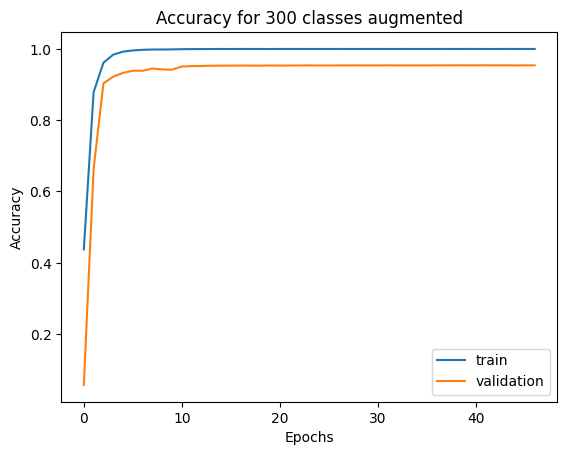

In [54]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes augmented", "Accuracy")

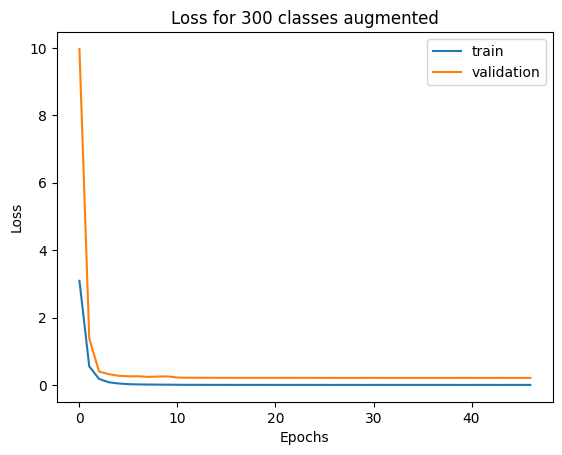

In [55]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes augmented", "Loss")

In [56]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_augmented_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.20973680913448334 accuracy 0.9539874196052551


U+4F3C 1.0 34.0
U+4FE1 1.0 37.0
U+5150 1.0 34.0
U+66FF 1.0 34.0
U+6851 1.0 88.0
U+6B63 1.0 37.0
U+6BCD 1.0 33.0
U+6C41 1.0 158.0
U+6CB9 1.0 40.0
U+7537 1.0 70.0
U+757F 1.0 36.0
U+795E 1.0 76.0
U+8338 1.0 33.0
U+89D2 1.0 35.0
U+9060 1.0 39.0
U+91CC 1.0 43.0
U+4E00 0.9981132075471698 530.0
U+5C0F 0.9962825278810409 269.0
U+4E91 0.9943396226415094 530.0
U+898B 0.99375 320.0
U+53C8 0.993103448275862 435.0
U+4E09 0.9915966386554622 238.0
U+6C5F 0.9915966386554622 119.0
U+6238 0.9911504424778761 113.0
U+767D 0.9911504424778761 113.0
U+5165 0.9894179894179894 378.0
U+5FC3 0.9891304347826086 184.0
U+662F 0.9878048780487805 246.0
U+4E0B 0.9866666666666667 150.0
U+4F55 0.9862385321100917 218.0
U+4EAC 0.9850746268656716 67.0
U+4E8C 0.985 200.0
U+6642 0.985 200.0
U+4ECA 0.9849246231155779 199.0
U+751F 0.984375 128.0
U+713C 0.9841269841269841 63.0
U+5F8C 0.984 125.0
U+5B50 0.9838709677419355 310.0
U+706B 0.9836065573770492 61.0
U+5375 0.9830508474576272 59.0
U+5DDD 0.9830508474576272 59.0
U+61F8 0.

In [57]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_augmented_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:17

Test: loss 0.20973680913448334 accuracy 0.9539874196052551


Per-class accuracy:
U+4F3C: 1.00000 
U+4FE1: 1.00000 
U+5150: 1.00000 
U+66FF: 1.00000 
U+6851: 1.00000 
U+6B63: 1.00000 
U+6BCD: 1.00000 
U+6C41: 1.00000 
U+6CB9: 1.00000 
U+7537: 1.00000 
U+757F: 1.00000 
U+795E: 1.00000 
U+8338: 1.00000 
U+89D2: 1.00000 
U+9060: 1.00000 
U+91CC: 1.00000 
U+4E00: 0.99811 
U+5C0F: 0.99628 
U+4E91: 0.99434 
U+898B: 0.99375 
U+53C8: 0.99310 
U+4E09: 0.99160 
U+6C5F: 0.99160 
U+6238: 0.99115 
U+767D: 0.99115 
U+5165: 0.98942 
U+5FC3: 0.98913 
U+662F: 0.98780 
U+4E0B: 0.98667 
U+4F55: 0.98624 
U+4EAC: 0.98507 
U+4E8C: 0.98500 
U+6642: 0.98500 
U+4ECA: 0.98492 
U+751F: 0.98438 
U+713C: 0.98413 
U+5F8C: 0.98400 
U+5B50: 0.98387 
U+706B: 0.98361 
U+5375: 0.98305 
U+5DDD: 0.98305 
U+61F8: 0.98214 
U+8D8A: 0.98182 
U+5973: 0.98148 
U+7D66: 0.98089 
U+5F62: 0.98039 
U+5F80: 0.98039 
U+76BF: 0.98039 
U+5148: 0.97959 
U+5409: 0.97959 
U+5473: 0.97959 
U+52A0: 0.97917 
U+5F15: 0.97895 
U+4EBA: 0.97886 
U+5207: 0.97872 
U+548C: 0.97872 
U+4ED5: 0.97826 
U+6CBB: 0.9

# Pretrained CASIA-HWDB unfreeze all, 150 classes logic

In [58]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [59]:
# Training loop 

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", model_name="150 classes unfreeze all")

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.26s/it]

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Epoch: 1
Train: loss 1.6196539402008057 accuracy 0.6929385662078857
Validation: loss 0.5179017782211304 accuracy 0.8623032569885254


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 2
Train: loss 0.15429461002349854 accuracy 0.959702730178833
Validation: loss 0.16181954741477966 accuracy 0.961129367351532


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


Epoch: 3
Train: loss 0.07650423049926758 accuracy 0.9822835922241211
Validation: loss 0.12369538843631744 accuracy 0.9705573916435242


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Epoch: 4
Train: loss 0.042165011167526245 accuracy 0.9901336431503296
Validation: loss 0.11490973830223083 accuracy 0.9712491035461426


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Epoch: 5
Train: loss 0.03081018477678299 accuracy 0.9933949708938599
Validation: loss 0.10927145183086395 accuracy 0.9739918112754822


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

  6%|▌         | 6/100 [04:32<1:10:46, 45.17s/it]

Epoch: 6
Train: loss 0.018546191975474358 accuracy 0.9962939620018005
Validation: loss 0.11234723776578903 accuracy 0.9738125801086426



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


Epoch: 7
Train: loss 0.012225866317749023 accuracy 0.9980280995368958
Validation: loss 0.10608655214309692 accuracy 0.9756661057472229


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Epoch: 8
Train: loss 0.00921714585274458 accuracy 0.9985914826393127
Validation: loss 0.10143875330686569 accuracy 0.9761950969696045


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


Epoch: 9
Train: loss 0.006763546261936426 accuracy 0.9988104701042175
Validation: loss 0.10041363537311554 accuracy 0.9775785803794861


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 10
Train: loss 0.00578070804476738 accuracy 0.9991549253463745
Validation: loss 0.0995977371931076 accuracy 0.977816641330719


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.25s/it]

100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Epoch: 11
Train: loss 0.004488954320549965 accuracy 0.999436616897583
Validation: loss 0.0995052307844162 accuracy 0.9782989025115967


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 12
Train: loss 0.004170869942754507 accuracy 0.9992236495018005
Validation: loss 0.09900596737861633 accuracy 0.9784677028656006


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.19s/it]

100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


Epoch: 13
Train: loss 0.005628481041640043 accuracy 0.9990358352661133
Validation: loss 0.09910672158002853 accuracy 0.9786304831504822


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Epoch: 14
Train: loss 0.004922699648886919 accuracy 0.999342679977417
Validation: loss 0.09859808534383774 accuracy 0.9789499640464783


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Epoch: 15
Train: loss 0.004902235232293606 accuracy 0.9993802309036255
Validation: loss 0.09832551330327988 accuracy 0.9792287349700928


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.22s/it]

100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


Epoch: 16
Train: loss 0.003334410022944212 accuracy 0.9995492696762085
Validation: loss 0.09818311035633087 accuracy 0.9793915152549744


  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.18s/it]

 17%|█▋        | 17/100 [12:51<1:02:24, 45.11s/it]

Epoch: 17
Train: loss 0.0029792182613164186 accuracy 0.999586820602417
Validation: loss 0.09783729910850525 accuracy 0.9789906144142151



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:29<00:00,  2.23s/it]

 18%|█▊        | 18/100 [13:36<1:01:36, 45.08s/it]

Epoch: 18
Train: loss 0.0022379388101398945 accuracy 0.999830961227417
Validation: loss 0.09750372171401978 accuracy 0.9789906144142151



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 19%|█▉        | 19/100 [14:21<1:00:41, 44.95s/it]

Epoch: 19
Train: loss 0.0027371400501579046 accuracy 0.999680757522583
Validation: loss 0.09714047610759735 accuracy 0.9790313243865967



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.21s/it]

 20%|██        | 20/100 [15:06<59:53, 44.92s/it]  

Epoch: 20
Train: loss 0.0029200196731835604 accuracy 0.9996619820594788
Validation: loss 0.09692570567131042 accuracy 0.9790720343589783



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:28<00:00,  2.20s/it]

 20%|██        | 20/100 [15:50<1:03:23, 47.54s/it]

Epoch: 21
Train: loss 0.0032114877831190825 accuracy 0.999586820602417
Validation: loss 0.09693223237991333 accuracy 0.9790720343589783
Best validation accuracy for 150 classes unfreeze all: 0.9793915152549744 Epoch 16


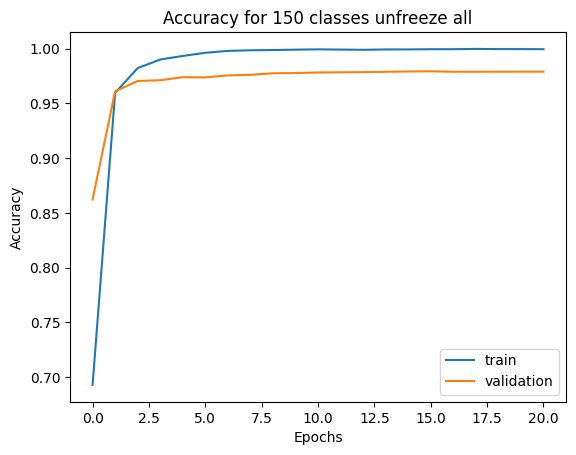

In [61]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze all", "Accuracy")

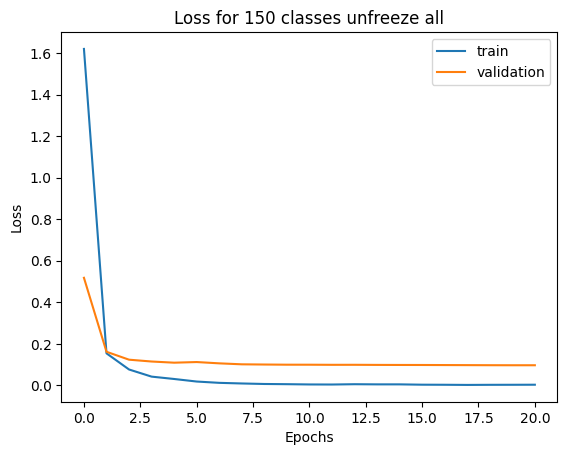

In [62]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze all", "Loss")

In [63]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.09818311035633087 accuracy 0.9793915152549744


U+4F55 1.0 218.0
U+5207 1.0 94.0
U+5375 1.0 59.0
U+53CA 1.0 77.0
U+5F15 1.0 95.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+662F 1.0 246.0
U+6851 1.0 88.0
U+6CBB 1.0 92.0
U+716E 1.0 73.0
U+7406 1.0 69.0
U+751F 1.0 128.0
U+767D 1.0 113.0
U+795E 1.0 76.0
U+79C1 1.0 65.0
U+7D19 1.0 79.0
U+7D66 1.0 157.0
U+8695 1.0 156.0
U+8A9E 1.0 61.0
U+901A 1.0 63.0
U+9053 1.0 83.0
U+9593 1.0 82.0
U+4E00 0.9981132075471698 530.0
U+5C0F 0.9962825278810409 269.0
U+5FC3 0.9945652173913043 184.0
U+5341 0.9937888198757764 161.0
U+898B 0.99375 320.0
U+4E0B 0.9933333333333333 150.0
U+53C8 0.993103448275862 435.0
U+4ED5 0.9927536231884058 138.0
U+5DDE 0.9920634920634921 126.0
U+5F8C 0.992 125.0
U+6728 0.9914529914529915 117.0
U+591C 0.9913793103448276 116.0
U+5C45 0.991304347826087 115.0
U+601D 0.991304347826087 115.0
U+8272 0.9910714285714286 112.0
U+9CE5 0.9905660377358491 106.0
U+6B64 0.9901960784313726 306.0
U+6642 0.99 200.0
U+4ECA 0.9899497487437185 199.0
U+5473 0.9897959183673469 98.0
U+897F 0.9895833333333334 9

In [64]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.09818311035633087 accuracy 0.9793915152549744


Per-class accuracy:
U+4F55: 1.00000 
U+5207: 1.00000 
U+5375: 1.00000 
U+53CA: 1.00000 
U+5F15: 1.00000 
U+6216: 1.00000 
U+6238: 1.00000 
U+662F: 1.00000 
U+6851: 1.00000 
U+6CBB: 1.00000 
U+716E: 1.00000 
U+7406: 1.00000 
U+751F: 1.00000 
U+767D: 1.00000 
U+795E: 1.00000 
U+79C1: 1.00000 
U+7D19: 1.00000 
U+7D66: 1.00000 
U+8695: 1.00000 
U+8A9E: 1.00000 
U+901A: 1.00000 
U+9053: 1.00000 
U+9593: 1.00000 
U+4E00: 0.99811 
U+5C0F: 0.99628 
U+5FC3: 0.99457 
U+5341: 0.99379 
U+898B: 0.99375 
U+4E0B: 0.99333 
U+53C8: 0.99310 
U+4ED5: 0.99275 
U+5DDE: 0.99206 
U+5F8C: 0.99200 
U+6728: 0.99145 
U+591C: 0.99138 
U+5C45: 0.99130 
U+601D: 0.99130 
U+8272: 0.99107 
U+9CE5: 0.99057 
U+6B64: 0.99020 
U+6642: 0.99000 
U+4ECA: 0.98995 
U+5473: 0.98980 
U+897F: 0.98958 
U+5FA1: 0.98953 
U+8449: 0.98947 
U+5165: 0.98942 
U+6240: 0.98936 
U+65E5: 0.98913 
U+7269: 0.98889 
U+524D: 0.98876 
U+5408: 0.98857 
U+4E8B: 0.98805 
U+9B5A: 0.98795 
U+5C4B: 0.98780 
U+5C71: 0.98780 
U+5916: 0.98750 
U+4E2D: 0.9

# Pretrained CASIA-HWDB unfreeze all, 200 classes logic

In [65]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [66]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", model_name="200 classes unfreeze all")

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.48s/it]

100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


Epoch: 1
Train: loss 1.8588873147964478 accuracy 0.6594646573066711
Validation: loss 0.4600337743759155 accuracy 0.8807312846183777


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.43s/it]

100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Epoch: 2
Train: loss 0.16711066663265228 accuracy 0.9610103964805603
Validation: loss 0.1702336072921753 accuracy 0.9570596814155579


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.38s/it]

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Epoch: 3
Train: loss 0.07580292224884033 accuracy 0.9826046824455261
Validation: loss 0.12361501157283783 accuracy 0.9673225283622742


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Epoch: 4
Train: loss 0.04131980612874031 accuracy 0.9915291666984558
Validation: loss 0.10774607956409454 accuracy 0.9722552299499512


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Epoch: 5
Train: loss 0.025032173842191696 accuracy 0.9953794479370117
Validation: loss 0.10051921010017395 accuracy 0.9754522442817688


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.37s/it]

100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


Epoch: 6
Train: loss 0.016615014523267746 accuracy 0.9972470998764038
Validation: loss 0.09455946087837219 accuracy 0.976320743560791


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


Epoch: 7
Train: loss 0.010865987278521061 accuracy 0.9980824589729309
Validation: loss 0.09288393706083298 accuracy 0.9767215251922607


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.42s/it]

100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Epoch: 8
Train: loss 0.00736243324354291 accuracy 0.9990066885948181
Validation: loss 0.0903937816619873 accuracy 0.9773975014686584


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

  9%|▉         | 9/100 [07:35<1:16:20, 50.33s/it]

Epoch: 9
Train: loss 0.007193958852440119 accuracy 0.9990240931510925
Validation: loss 0.09017260372638702 accuracy 0.977242648601532



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:15<00:00,  2.67s/it]


Epoch: 10
Train: loss 0.005926334299147129 accuracy 0.9991992115974426
Validation: loss 0.09091924130916595 accuracy 0.9782113432884216


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.36s/it]

100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Epoch: 11
Train: loss 0.004635144956409931 accuracy 0.9992856979370117
Validation: loss 0.0880197212100029 accuracy 0.9788326621055603


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.37s/it]

100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Epoch: 12
Train: loss 0.002868082607164979 accuracy 0.9997038841247559
Validation: loss 0.08743228763341904 accuracy 0.9790579676628113


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:34<00:00,  2.46s/it]

 13%|█▎        | 13/100 [10:57<1:13:17, 50.55s/it]

Epoch: 13
Train: loss 0.004070935305207968 accuracy 0.9995120763778687
Validation: loss 0.08712794631719589 accuracy 0.9790282249450684



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


Epoch: 14
Train: loss 0.003955985885113478 accuracy 0.9994946122169495
Validation: loss 0.08701084554195404 accuracy 0.979161262512207


  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.39s/it]

 15%|█▌        | 15/100 [12:37<1:11:10, 50.25s/it]

Epoch: 15
Train: loss 0.0031145892571657896 accuracy 0.9995473027229309
Validation: loss 0.08719076216220856 accuracy 0.979039192199707



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.40s/it]

 16%|█▌        | 16/100 [13:27<1:10:15, 50.18s/it]

Epoch: 16
Train: loss 0.002898645354434848 accuracy 0.9996686577796936
Validation: loss 0.08702054619789124 accuracy 0.9790907502174377



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.35s/it]

 17%|█▋        | 17/100 [14:16<1:09:10, 50.00s/it]

Epoch: 17
Train: loss 0.002945484360679984 accuracy 0.9996519088745117
Validation: loss 0.08696099370718002 accuracy 0.9789984822273254



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:33<00:00,  2.38s/it]

 18%|█▊        | 18/100 [15:07<1:08:23, 50.05s/it]

Epoch: 18
Train: loss 0.004076382145285606 accuracy 0.9994077682495117
Validation: loss 0.08704826235771179 accuracy 0.9791095852851868



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.52s/it]

 18%|█▊        | 18/100 [15:59<1:12:50, 53.29s/it]

Epoch: 19
Train: loss 0.0036245088558644056 accuracy 0.9994778633117676
Validation: loss 0.08694308996200562 accuracy 0.9790876507759094
Best validation accuracy for 200 classes unfreeze all: 0.979161262512207 Epoch 14


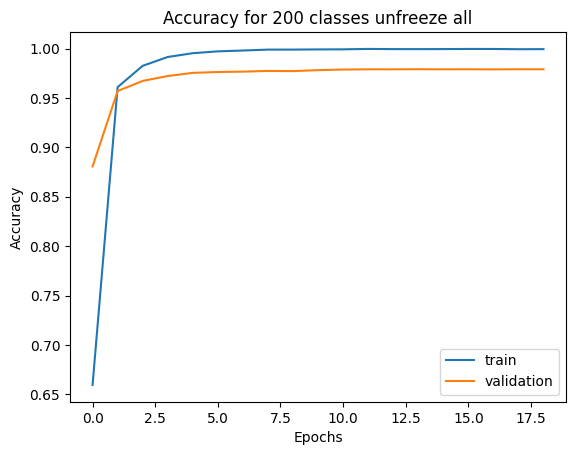

In [67]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze all", "Accuracy")

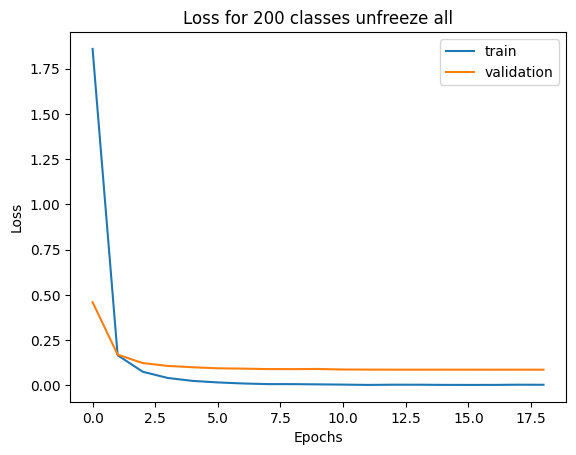

In [68]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze all", "Loss")

In [69]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.08701084554195404 accuracy 0.979161262512207


U+4E03 1.0 77.0
U+4E16 1.0 146.0
U+4EAC 1.0 67.0
U+4ED5 1.0 138.0
U+4ED8 1.0 86.0
U+4F55 1.0 218.0
U+5185 1.0 106.0
U+5207 1.0 94.0
U+52A0 1.0 48.0
U+5341 1.0 161.0
U+5375 1.0 59.0
U+5473 1.0 98.0
U+547C 1.0 52.0
U+5730 1.0 55.0
U+592A 1.0 66.0
U+5965 1.0 48.0
U+5973 1.0 216.0
U+5DDD 1.0 59.0
U+5F97 1.0 45.0
U+61F8 1.0 56.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+6771 1.0 126.0
U+6851 1.0 88.0
U+6B64 1.0 306.0
U+6C5F 1.0 119.0
U+6CD5 1.0 51.0
U+6D77 1.0 52.0
U+713C 1.0 63.0
U+714E 1.0 59.0
U+7537 1.0 70.0
U+77E5 1.0 50.0
U+795E 1.0 76.0
U+7A2E 1.0 73.0
U+7B2C 1.0 61.0
U+7DCF 1.0 55.0
U+80FD 1.0 53.0
U+8EAB 1.0 166.0
U+8FD1 1.0 51.0
U+901A 1.0 63.0
U+985E 1.0 46.0
U+9CE5 1.0 106.0
U+4E8B 0.99800796812749 502.0
U+4E00 0.9962264150943396 530.0
U+4E91 0.9962264150943396 530.0
U+6642 0.995 200.0
U+524D 0.9943820224719101 178.0
U+5408 0.9942857142857143 175.0
U+898B 0.99375 320.0
U+8695 0.9935897435897436 156.0
U+4E0B 0.9933333333333333 150.0
U+5409 0.9931972789115646 147.0
U+7533 0.9928057553956

In [71]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:16

Test: loss 0.08701084554195404 accuracy 0.979161262512207


Per-class accuracy:
U+4E03: 1.00000 
U+4E16: 1.00000 
U+4EAC: 1.00000 
U+4ED5: 1.00000 
U+4ED8: 1.00000 
U+4F55: 1.00000 
U+5185: 1.00000 
U+5207: 1.00000 
U+52A0: 1.00000 
U+5341: 1.00000 
U+5375: 1.00000 
U+5473: 1.00000 
U+547C: 1.00000 
U+5730: 1.00000 
U+592A: 1.00000 
U+5965: 1.00000 
U+5973: 1.00000 
U+5DDD: 1.00000 
U+5F97: 1.00000 
U+61F8: 1.00000 
U+6216: 1.00000 
U+6238: 1.00000 
U+6771: 1.00000 
U+6851: 1.00000 
U+6B64: 1.00000 
U+6C5F: 1.00000 
U+6CD5: 1.00000 
U+6D77: 1.00000 
U+713C: 1.00000 
U+714E: 1.00000 
U+7537: 1.00000 
U+77E5: 1.00000 
U+795E: 1.00000 
U+7A2E: 1.00000 
U+7B2C: 1.00000 
U+7DCF: 1.00000 
U+80FD: 1.00000 
U+8EAB: 1.00000 
U+8FD1: 1.00000 
U+901A: 1.00000 
U+985E: 1.00000 
U+9CE5: 1.00000 
U+4E8B: 0.99801 
U+4E00: 0.99623 
U+4E91: 0.99623 
U+6642: 0.99500 
U+524D: 0.99438 
U+5408: 0.99429 
U+898B: 0.99375 
U+8695: 0.99359 
U+4E0B: 0.99333 
U+5409: 0.99320 
U+7533: 0.99281 
U+5BB6: 0.99138 
U+5C45: 0.99130 
U+601D: 0.99130 
U+6625: 0.99123 
U+767D: 0.9

# Pretrained CASIA-HWDB unfreeze all, 300 classes logic

In [72]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [73]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", model_name="300 classes unfreeze all")

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

100%|██████████| 7/7 [00:17<00:00,  2.46s/it]


Epoch: 1
Train: loss 1.934455394744873 accuracy 0.6619699001312256
Validation: loss 0.5921974182128906 accuracy 0.8465525507926941


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.30s/it]

100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch: 2
Train: loss 0.16855400800704956 accuracy 0.9612269997596741
Validation: loss 0.19229646027088165 accuracy 0.9533699750900269


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

100%|██████████| 7/7 [00:16<00:00,  2.35s/it]


Epoch: 3
Train: loss 0.0665094256401062 accuracy 0.9854581952095032
Validation: loss 0.1479918211698532 accuracy 0.965342104434967


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch: 4
Train: loss 0.036980871111154556 accuracy 0.9922508001327515
Validation: loss 0.13369718194007874 accuracy 0.9691149592399597


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:39<00:00,  2.50s/it]

100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


Epoch: 5
Train: loss 0.0242351982742548 accuracy 0.995578408241272
Validation: loss 0.12423038482666016 accuracy 0.9713738560676575


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:40<00:00,  2.52s/it]

100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


Epoch: 6
Train: loss 0.016274401918053627 accuracy 0.997381329536438
Validation: loss 0.11692191660404205 accuracy 0.9738717079162598


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

  7%|▋         | 7/100 [06:28<1:26:34, 55.86s/it]

Epoch: 7
Train: loss 0.011283822357654572 accuracy 0.9983485341072083
Validation: loss 0.11677195876836777 accuracy 0.9735854864120483



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Epoch: 8
Train: loss 0.008360259234905243 accuracy 0.9987511038780212
Validation: loss 0.1150980293750763 accuracy 0.975100576877594


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

  9%|▉         | 9/100 [08:16<1:23:01, 54.74s/it]

Epoch: 9
Train: loss 0.007798771373927593 accuracy 0.9988614320755005
Validation: loss 0.11604882776737213 accuracy 0.9744420051574707



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

100%|██████████| 7/7 [00:16<00:00,  2.42s/it]


Epoch: 10
Train: loss 0.00486940098926425 accuracy 0.999364972114563
Validation: loss 0.11433321237564087 accuracy 0.9751119017601013


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.37s/it]

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch: 11
Train: loss 0.004618969280272722 accuracy 0.999334454536438
Validation: loss 0.11306614428758621 accuracy 0.9760032892227173


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:16<00:00,  2.33s/it]


Epoch: 12
Train: loss 0.004064022563397884 accuracy 0.9994166493415833
Validation: loss 0.1125345230102539 accuracy 0.9760422706604004


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

 13%|█▎        | 13/100 [11:54<1:19:09, 54.60s/it]

Epoch: 13
Train: loss 0.003908255137503147 accuracy 0.999517560005188
Validation: loss 0.1125541552901268 accuracy 0.9760074019432068



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

 14%|█▍        | 14/100 [12:50<1:18:35, 54.83s/it]

Epoch: 14
Train: loss 0.0035307256039232016 accuracy 0.999609112739563
Validation: loss 0.11261998116970062 accuracy 0.9757827520370483



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

 15%|█▌        | 15/100 [13:44<1:17:28, 54.68s/it]

Epoch: 15
Train: loss 0.0035799567122012377 accuracy 0.999578595161438
Validation: loss 0.11233074218034744 accuracy 0.9759222269058228



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.36s/it]

 16%|█▌        | 16/100 [14:39<1:16:31, 54.66s/it]

Epoch: 16
Train: loss 0.0036730021238327026 accuracy 0.9995844960212708
Validation: loss 0.11201372742652893 accuracy 0.9760227799415588



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Epoch: 17
Train: loss 0.0030533408280462027 accuracy 0.9996337890625
Validation: loss 0.11213942617177963 accuracy 0.9760689735412598


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.26s/it]

100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


Epoch: 18
Train: loss 0.003082568757236004 accuracy 0.9996548891067505
Validation: loss 0.11212808638811111 accuracy 0.9761582016944885


  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.27s/it]

 19%|█▉        | 19/100 [17:20<1:13:07, 54.16s/it]

Epoch: 19
Train: loss 0.0028990223072469234 accuracy 0.999639630317688
Validation: loss 0.11171356588602066 accuracy 0.9758678674697876



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:36<00:00,  2.29s/it]

 20%|██        | 20/100 [18:15<1:12:15, 54.19s/it]

Epoch: 20
Train: loss 0.0029633946251124144 accuracy 0.9996795654296875
Validation: loss 0.11152492463588715 accuracy 0.9758678674697876



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:39<00:00,  2.49s/it]

 21%|██        | 21/100 [19:12<1:12:38, 55.18s/it]

Epoch: 21
Train: loss 0.002932447474449873 accuracy 0.9996185302734375
Validation: loss 0.1115090474486351 accuracy 0.9760617613792419



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:40<00:00,  2.50s/it]

 22%|██▏       | 22/100 [20:10<1:12:51, 56.05s/it]

Epoch: 22
Train: loss 0.002345748245716095 accuracy 0.9997711181640625
Validation: loss 0.11152321845293045 accuracy 0.9760074019432068



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:37<00:00,  2.34s/it]

 22%|██▏       | 22/100 [21:05<1:14:45, 57.51s/it]

Epoch: 23
Train: loss 0.0031321297865360975 accuracy 0.9995880126953125
Validation: loss 0.11159087717533112 accuracy 0.9759376645088196
Best validation accuracy for 300 classes unfreeze all: 0.9761582016944885 Epoch 18


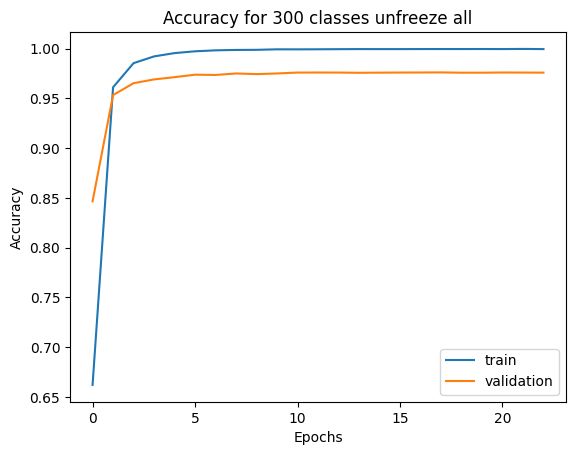

In [74]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze all", "Accuracy")

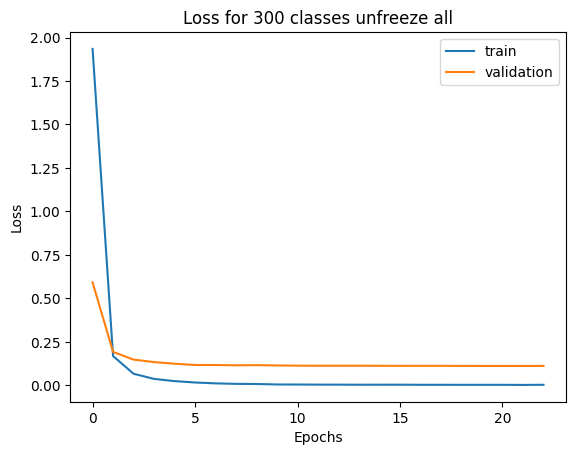

In [75]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze all", "Loss")

In [76]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.11212808638811111 accuracy 0.9761582016944885


U+4E00 1.0 530.0
U+4ECA 1.0 199.0
U+4EE3 1.0 40.0
U+4F3C 1.0 34.0
U+4F46 1.0 39.0
U+4FE1 1.0 37.0
U+5148 1.0 49.0
U+5207 1.0 94.0
U+52A0 1.0 48.0
U+52E2 1.0 36.0
U+5347 1.0 35.0
U+5357 1.0 40.0
U+53CA 1.0 77.0
U+53E4 1.0 64.0
U+5411 1.0 33.0
U+541B 1.0 33.0
U+547C 1.0 52.0
U+55B0 1.0 32.0
U+5965 1.0 48.0
U+5BBF 1.0 39.0
U+5C0F 1.0 269.0
U+5C3E 1.0 39.0
U+5C45 1.0 115.0
U+5C71 1.0 164.0
U+5DDD 1.0 59.0
U+5E72 1.0 33.0
U+5F7C 1.0 43.0
U+601D 1.0 115.0
U+6238 1.0 113.0
U+6298 1.0 32.0
U+66FF 1.0 34.0
U+6B63 1.0 37.0
U+6BCD 1.0 33.0
U+6CB9 1.0 40.0
U+6CBB 1.0 92.0
U+6CD5 1.0 51.0
U+6D25 1.0 35.0
U+6D77 1.0 52.0
U+713C 1.0 63.0
U+714E 1.0 59.0
U+7236 1.0 36.0
U+7389 1.0 61.0
U+7537 1.0 70.0
U+757F 1.0 36.0
U+76BF 1.0 51.0
U+77F3 1.0 33.0
U+79F0 1.0 34.0
U+7AF9 1.0 46.0
U+7B2C 1.0 61.0
U+7D30 1.0 34.0
U+7FA9 1.0 43.0
U+8005 1.0 68.0
U+80FD 1.0 53.0
U+8179 1.0 37.0
U+8449 1.0 95.0
U+8584 1.0 41.0
U+898B 1.0 320.0
U+89AA 1.0 40.0
U+89D2 1.0 35.0
U+8D64 1.0 33.0
U+8D77 1.0 37.0
U+901A 1.0 63.0


In [77]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:17

Test: loss 0.11212808638811111 accuracy 0.9761582016944885


Per-class accuracy:
U+4E00: 1.00000 
U+4ECA: 1.00000 
U+4EE3: 1.00000 
U+4F3C: 1.00000 
U+4F46: 1.00000 
U+4FE1: 1.00000 
U+5148: 1.00000 
U+5207: 1.00000 
U+52A0: 1.00000 
U+52E2: 1.00000 
U+5347: 1.00000 
U+5357: 1.00000 
U+53CA: 1.00000 
U+53E4: 1.00000 
U+5411: 1.00000 
U+541B: 1.00000 
U+547C: 1.00000 
U+55B0: 1.00000 
U+5965: 1.00000 
U+5BBF: 1.00000 
U+5C0F: 1.00000 
U+5C3E: 1.00000 
U+5C45: 1.00000 
U+5C71: 1.00000 
U+5DDD: 1.00000 
U+5E72: 1.00000 
U+5F7C: 1.00000 
U+601D: 1.00000 
U+6238: 1.00000 
U+6298: 1.00000 
U+66FF: 1.00000 
U+6B63: 1.00000 
U+6BCD: 1.00000 
U+6CB9: 1.00000 
U+6CBB: 1.00000 
U+6CD5: 1.00000 
U+6D25: 1.00000 
U+6D77: 1.00000 
U+713C: 1.00000 
U+714E: 1.00000 
U+7236: 1.00000 
U+7389: 1.00000 
U+7537: 1.00000 
U+757F: 1.00000 
U+76BF: 1.00000 
U+77F3: 1.00000 
U+79F0: 1.00000 
U+7AF9: 1.00000 
U+7B2C: 1.00000 
U+7D30: 1.00000 
U+7FA9: 1.00000 
U+8005: 1.00000 
U+80FD: 1.00000 
U+8179: 1.00000 
U+8449: 1.00000 
U+8584: 1.00000 
U+898B: 1.00000 
U+89AA: 1.0

# Pretrained CASIA-HWDB unfreeze last, 150 classes logic

In [78]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [79]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", model_name="150 classes unfreeze last", freeze_base=True)

  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

  1%|          | 1/100 [00:43<1:11:09, 43.12s/it]

Epoch: 1
Train: loss 3.394101858139038 accuracy 0.3391985595226288
Validation: loss 1.567493200302124 accuracy 0.7143257260322571



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.00s/it]

  2%|▏         | 2/100 [01:25<1:09:59, 42.86s/it]

Epoch: 2
Train: loss 0.9424592852592468 accuracy 0.8227185606956482
Validation: loss 0.6399739980697632 accuracy 0.8663420677185059



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.02s/it]

  3%|▎         | 3/100 [02:08<1:09:28, 42.98s/it]

Epoch: 3
Train: loss 0.503714919090271 accuracy 0.895579993724823
Validation: loss 0.44775843620300293 accuracy 0.9001671671867371



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

  4%|▍         | 4/100 [02:51<1:08:45, 42.97s/it]

Epoch: 4
Train: loss 0.36627843976020813 accuracy 0.92177814245224
Validation: loss 0.3793269991874695 accuracy 0.9136219024658203



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.97s/it]

  5%|▌         | 5/100 [03:34<1:07:45, 42.80s/it]

Epoch: 5
Train: loss 0.3051879405975342 accuracy 0.9351495504379272
Validation: loss 0.34082937240600586 accuracy 0.9228101372718811



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

  6%|▌         | 6/100 [04:17<1:07:10, 42.88s/it]

Epoch: 6
Train: loss 0.2629621922969818 accuracy 0.9440085887908936
Validation: loss 0.316957950592041 accuracy 0.9285760521888733



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.07s/it]

  7%|▋         | 7/100 [05:01<1:07:19, 43.44s/it]

Epoch: 7
Train: loss 0.24111102521419525 accuracy 0.9507437944412231
Validation: loss 0.29477113485336304 accuracy 0.9327550530433655



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:27<00:00,  2.13s/it]

  8%|▊         | 8/100 [05:47<1:07:24, 43.96s/it]

Epoch: 8
Train: loss 0.20953305065631866 accuracy 0.957856297492981
Validation: loss 0.2825853228569031 accuracy 0.9347714781761169



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

  9%|▉         | 9/100 [06:30<1:06:28, 43.83s/it]

Epoch: 9
Train: loss 0.19658321142196655 accuracy 0.9607740640640259
Validation: loss 0.2729524075984955 accuracy 0.9364864826202393



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.05s/it]

 10%|█         | 10/100 [07:13<1:05:21, 43.57s/it]

Epoch: 10
Train: loss 0.18501150608062744 accuracy 0.9649239778518677
Validation: loss 0.26266777515411377 accuracy 0.9384275078773499



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

 11%|█         | 11/100 [07:56<1:04:18, 43.35s/it]

Epoch: 11
Train: loss 0.17315541207790375 accuracy 0.9670588970184326
Validation: loss 0.2613745927810669 accuracy 0.9384682178497314



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 12%|█▏        | 12/100 [08:38<1:03:00, 42.96s/it]

Epoch: 12
Train: loss 0.17497359216213226 accuracy 0.9658566117286682
Validation: loss 0.26089051365852356 accuracy 0.9384335875511169



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 13%|█▎        | 13/100 [09:21<1:02:06, 42.84s/it]

Epoch: 13
Train: loss 0.17925523221492767 accuracy 0.9642035365104675
Validation: loss 0.26041412353515625 accuracy 0.9379980564117432



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  2.00s/it]

 14%|█▍        | 14/100 [10:03<1:01:14, 42.72s/it]

Epoch: 14
Train: loss 0.16534414887428284 accuracy 0.9684678316116333
Validation: loss 0.2590535879135132 accuracy 0.9383235573768616



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.01s/it]

 15%|█▌        | 15/100 [10:46<1:00:33, 42.74s/it]

Epoch: 15
Train: loss 0.17316505312919617 accuracy 0.967133641242981
Validation: loss 0.25795018672943115 accuracy 0.9386084079742432



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 16%|█▌        | 16/100 [11:29<59:48, 42.72s/it]  

Epoch: 16
Train: loss 0.17634247243404388 accuracy 0.9654374718666077
Validation: loss 0.2572252154350281 accuracy 0.9391313195228577



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 17%|█▋        | 17/100 [12:11<58:57, 42.62s/it]

Epoch: 17
Train: loss 0.16515906155109406 accuracy 0.9678100943565369
Validation: loss 0.2563108205795288 accuracy 0.9394161701202393



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.00s/it]

 18%|█▊        | 18/100 [12:54<58:17, 42.66s/it]

Epoch: 18
Train: loss 0.16632497310638428 accuracy 0.9673901796340942
Validation: loss 0.25435465574264526 accuracy 0.9392594695091248



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.96s/it]

 19%|█▉        | 19/100 [13:36<57:31, 42.61s/it]

Epoch: 19
Train: loss 0.1675296574831009 accuracy 0.9682664275169373
Validation: loss 0.25466713309288025 accuracy 0.9394629001617432



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 20%|██        | 20/100 [14:19<56:56, 42.71s/it]

Epoch: 20
Train: loss 0.16451069712638855 accuracy 0.9682980179786682
Validation: loss 0.25319236516952515 accuracy 0.9397416710853577



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:26<00:00,  2.00s/it]

 21%|██        | 21/100 [15:02<56:11, 42.68s/it]

Epoch: 21
Train: loss 0.15518395602703094 accuracy 0.9711090326309204
Validation: loss 0.25345978140830994 accuracy 0.9399797916412354



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 22%|██▏       | 22/100 [15:44<55:24, 42.62s/it]

Epoch: 22
Train: loss 0.16097114980220795 accuracy 0.9675651788711548
Validation: loss 0.25327804684638977 accuracy 0.9395789504051208



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.98s/it]

 23%|██▎       | 23/100 [16:26<54:34, 42.52s/it]

Epoch: 23
Train: loss 0.16098172962665558 accuracy 0.9686108827590942
Validation: loss 0.2536492347717285 accuracy 0.9393754601478577



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  2.00s/it]

 24%|██▍       | 24/100 [17:09<53:50, 42.50s/it]

Epoch: 24
Train: loss 0.16327296197414398 accuracy 0.968072235584259
Validation: loss 0.2537536025047302 accuracy 0.9394629001617432



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 25%|██▌       | 25/100 [17:51<53:08, 42.51s/it]

Epoch: 25
Train: loss 0.15626004338264465 accuracy 0.9704393148422241
Validation: loss 0.25271788239479065 accuracy 0.9395382404327393



  0%|          | 0/13 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 13/13 [00:25<00:00,  1.99s/it]

 25%|██▌       | 25/100 [18:34<55:44, 44.59s/it]

Epoch: 26
Train: loss 0.1649194210767746 accuracy 0.9667072296142578
Validation: loss 0.2537384033203125 accuracy 0.9395382404327393
Best validation accuracy for 150 classes unfreeze last: 0.9399797916412354 Epoch 21


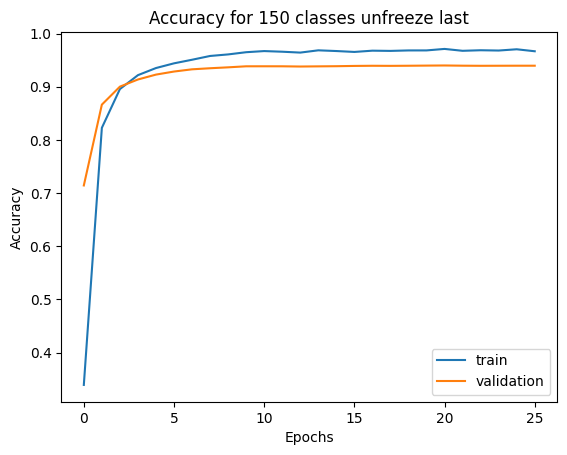

In [80]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze last", "Accuracy")

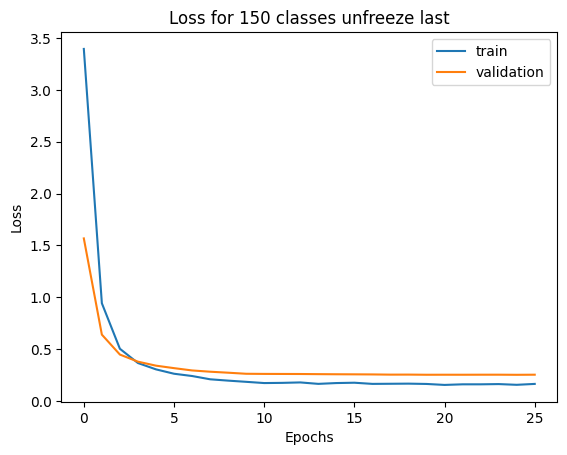

In [81]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze last", "Loss")

In [82]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.25345978140830994 accuracy 0.9399797916412354


U+5375 1.0 59.0
U+548C 1.0 94.0
U+601D 1.0 115.0
U+716E 1.0 73.0
U+7406 1.0 69.0
U+4E00 0.9943396226415094 530.0
U+8695 0.9935897435897436 156.0
U+4ED8 0.9883720930232558 86.0
U+6C41 0.9873417721518988 158.0
U+516B 0.987012987012987 77.0
U+7537 0.9857142857142858 70.0
U+6C17 0.9848484848484849 66.0
U+713C 0.9841269841269841 63.0
U+6238 0.9823008849557522 113.0
U+5C71 0.9817073170731707 164.0
U+4E16 0.9794520547945206 146.0
U+897F 0.9791666666666666 96.0
U+5F15 0.9789473684210527 95.0
U+5207 0.9787234042553191 94.0
U+6CBB 0.9782608695652174 92.0
U+9152 0.9769230769230769 130.0
U+9B5A 0.9759036144578314 83.0
U+898B 0.975 320.0
U+7D19 0.9746835443037974 79.0
U+624B 0.9745222929936306 157.0
U+591C 0.9741379310344828 116.0
U+53CA 0.974025974025974 77.0
U+5C45 0.9739130434782609 115.0
U+5DE6 0.9736842105263158 76.0
U+7A2E 0.9726027397260274 73.0
U+9577 0.9726027397260274 73.0
U+4ED5 0.9710144927536232 138.0
U+4EAC 0.9701492537313433 67.0
U+5869 0.9701492537313433 67.0
U+5473 0.96938775510204

In [83]:
testing_models_metrics(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_150.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:15

Test: loss 0.25345978140830994 accuracy 0.9399797916412354


Per-class accuracy:
U+5375: 1.00000 
U+548C: 1.00000 
U+601D: 1.00000 
U+716E: 1.00000 
U+7406: 1.00000 
U+4E00: 0.99434 
U+8695: 0.99359 
U+4ED8: 0.98837 
U+6C41: 0.98734 
U+516B: 0.98701 
U+7537: 0.98571 
U+6C17: 0.98485 
U+713C: 0.98413 
U+6238: 0.98230 
U+5C71: 0.98171 
U+4E16: 0.97945 
U+897F: 0.97917 
U+5F15: 0.97895 
U+5207: 0.97872 
U+6CBB: 0.97826 
U+9152: 0.97692 
U+9B5A: 0.97590 
U+898B: 0.97500 
U+7D19: 0.97468 
U+624B: 0.97452 
U+591C: 0.97414 
U+53CA: 0.97403 
U+5C45: 0.97391 
U+5DE6: 0.97368 
U+7A2E: 0.97260 
U+9577: 0.97260 
U+4ED5: 0.97101 
U+4EAC: 0.97015 
U+5869: 0.97015 
U+5473: 0.96939 
U+751F: 0.96875 
U+8449: 0.96842 
U+4F55: 0.96789 
U+90CE: 0.96774 
U+662F: 0.96748 
U+5C0F: 0.96654 
U+98A8: 0.96581 
U+6642: 0.96500 
U+4EBA: 0.96406 
U+5973: 0.96296 
U+5916: 0.96250 
U+5185: 0.96226 
U+98DF: 0.96203 
U+56DB: 0.96183 
U+91CE: 0.96154 
U+4E03: 0.96104 
U+795E: 0.96053 
U+5409: 0.95918 
U+53C8: 0.95862 
U+4E91: 0.95849 
U+6211: 0.95833 
U+7269: 0.95833 
U+8EAB: 0.9

# Pretrained CASIA-HWDB unfreeze last, 200 classes logic

In [87]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_200.pkl")

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [88]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", model_name="200 classes unfreeze last", freeze_base=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.28s/it]

  1%|          | 1/100 [00:48<1:20:30, 48.80s/it]

Epoch: 1
Train: loss 3.428868293762207 accuracy 0.36120447516441345
Validation: loss 1.5331928730010986 accuracy 0.7352284789085388



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.29s/it]

  2%|▏         | 2/100 [01:37<1:19:15, 48.52s/it]

Epoch: 2
Train: loss 0.9054881930351257 accuracy 0.8289331197738647
Validation: loss 0.647612452507019 accuracy 0.8637506365776062



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.27s/it]

  3%|▎         | 3/100 [02:25<1:18:19, 48.45s/it]

Epoch: 3
Train: loss 0.47066730260849 accuracy 0.9030190706253052
Validation: loss 0.4646010100841522 accuracy 0.8967406153678894



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.29s/it]

  4%|▍         | 4/100 [03:14<1:17:42, 48.56s/it]

Epoch: 4
Train: loss 0.3464803993701935 accuracy 0.928213894367218
Validation: loss 0.3927146792411804 accuracy 0.9114604592323303



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.23s/it]

  5%|▌         | 5/100 [04:02<1:16:33, 48.36s/it]

Epoch: 5
Train: loss 0.2884998023509979 accuracy 0.9421224594116211
Validation: loss 0.3551054894924164 accuracy 0.9183695912361145



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

  6%|▌         | 6/100 [04:50<1:15:49, 48.40s/it]

Epoch: 6
Train: loss 0.25223076343536377 accuracy 0.9503148794174194
Validation: loss 0.33107709884643555 accuracy 0.9233023524284363



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

  7%|▋         | 7/100 [05:38<1:14:47, 48.25s/it]

Epoch: 7
Train: loss 0.22130997478961945 accuracy 0.957062304019928
Validation: loss 0.31266096234321594 accuracy 0.9266200661659241



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.30s/it]

  8%|▊         | 8/100 [06:27<1:14:17, 48.45s/it]

Epoch: 8
Train: loss 0.19724316895008087 accuracy 0.963004469871521
Validation: loss 0.29897427558898926 accuracy 0.9287452697753906



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

  9%|▉         | 9/100 [07:15<1:13:26, 48.42s/it]

Epoch: 9
Train: loss 0.17900623381137848 accuracy 0.9677252769470215
Validation: loss 0.2892436683177948 accuracy 0.9306090474128723



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

 10%|█         | 10/100 [08:04<1:12:33, 48.37s/it]

Epoch: 10
Train: loss 0.1657438725233078 accuracy 0.9703027606010437
Validation: loss 0.2801423966884613 accuracy 0.9319470524787903



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

 11%|█         | 11/100 [08:52<1:11:49, 48.43s/it]

Epoch: 11
Train: loss 0.15697628259658813 accuracy 0.972293496131897
Validation: loss 0.2790536880493164 accuracy 0.9319252371788025



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.29s/it]

 12%|█▏        | 12/100 [09:41<1:11:04, 48.46s/it]

Epoch: 12
Train: loss 0.156977578997612 accuracy 0.9731084108352661
Validation: loss 0.27810975909233093 accuracy 0.9326794743537903



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

 13%|█▎        | 13/100 [10:29<1:10:01, 48.30s/it]

Epoch: 13
Train: loss 0.15341916680335999 accuracy 0.9738240838050842
Validation: loss 0.27749907970428467 accuracy 0.9324243664741516



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.27s/it]

 14%|█▍        | 14/100 [11:17<1:09:14, 48.31s/it]

Epoch: 14
Train: loss 0.15819436311721802 accuracy 0.973912239074707
Validation: loss 0.27621161937713623 accuracy 0.9326983094215393



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.24s/it]

 15%|█▌        | 15/100 [12:05<1:08:14, 48.17s/it]

Epoch: 15
Train: loss 0.1561778336763382 accuracy 0.9729363322257996
Validation: loss 0.275606244802475 accuracy 0.9326576590538025



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

 16%|█▌        | 16/100 [12:53<1:07:37, 48.31s/it]

Epoch: 16
Train: loss 0.15112042427062988 accuracy 0.9743281006813049
Validation: loss 0.2748394012451172 accuracy 0.9324243664741516



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

 17%|█▋        | 17/100 [13:42<1:06:43, 48.24s/it]

Epoch: 17
Train: loss 0.15127059817314148 accuracy 0.9748871922492981
Validation: loss 0.2738208472728729 accuracy 0.9329126477241516



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.27s/it]

 18%|█▊        | 18/100 [14:30<1:05:56, 48.25s/it]

Epoch: 18
Train: loss 0.153887078166008 accuracy 0.9733901023864746
Validation: loss 0.27259954810142517 accuracy 0.9332898259162903



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.25s/it]

 19%|█▉        | 19/100 [15:18<1:05:03, 48.20s/it]

Epoch: 19
Train: loss 0.14676490426063538 accuracy 0.9742274880409241
Validation: loss 0.2716059684753418 accuracy 0.9334307312965393



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

 20%|██        | 20/100 [16:06<1:04:17, 48.22s/it]

Epoch: 20
Train: loss 0.14569245278835297 accuracy 0.9746621251106262
Validation: loss 0.27110856771469116 accuracy 0.9336342215538025



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:31<00:00,  2.27s/it]

 21%|██        | 21/100 [16:55<1:03:53, 48.53s/it]

Epoch: 21
Train: loss 0.1435231864452362 accuracy 0.9755491614341736
Validation: loss 0.2708740532398224 accuracy 0.9337155818939209



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.33s/it]

 22%|██▏       | 22/100 [17:45<1:03:26, 48.80s/it]

Epoch: 22
Train: loss 0.14728355407714844 accuracy 0.9750789999961853
Validation: loss 0.27082228660583496 accuracy 0.9337671399116516



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.30s/it]

 23%|██▎       | 23/100 [18:33<1:02:33, 48.74s/it]

Epoch: 23
Train: loss 0.14398100972175598 accuracy 0.9758301973342896
Validation: loss 0.27019616961479187 accuracy 0.9338783621788025



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.31s/it]

 24%|██▍       | 24/100 [19:23<1:01:58, 48.92s/it]

Epoch: 24
Train: loss 0.14192131161689758 accuracy 0.9766997694969177
Validation: loss 0.2701018452644348 accuracy 0.9340519905090332



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:32<00:00,  2.32s/it]

 25%|██▌       | 25/100 [20:12<1:01:10, 48.94s/it]

Epoch: 25
Train: loss 0.1456376165151596 accuracy 0.9755631685256958
Validation: loss 0.27034470438957214 accuracy 0.9339706301689148



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:37<00:00,  2.65s/it]

 26%|██▌       | 26/100 [21:09<1:03:29, 51.49s/it]

Epoch: 26
Train: loss 0.14215092360973358 accuracy 0.9765642881393433
Validation: loss 0.27036356925964355 accuracy 0.9337671399116516



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:38<00:00,  2.72s/it]

 27%|██▋       | 27/100 [22:07<1:04:50, 53.29s/it]

Epoch: 27
Train: loss 0.14343476295471191 accuracy 0.9769770503044128
Validation: loss 0.2701939344406128 accuracy 0.9338078498840332



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.56s/it]

 28%|██▊       | 28/100 [23:01<1:04:08, 53.45s/it]

Epoch: 28
Train: loss 0.14461413025856018 accuracy 0.9758962392807007
Validation: loss 0.2701084017753601 accuracy 0.9339706301689148



  0%|          | 0/14 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 14/14 [00:35<00:00,  2.52s/it]

 28%|██▊       | 28/100 [23:54<1:01:29, 51.24s/it]

Epoch: 29
Train: loss 0.14141082763671875 accuracy 0.9769931435585022
Validation: loss 0.26947301626205444 accuracy 0.9339706301689148
Best validation accuracy for 200 classes unfreeze last: 0.9340519905090332 Epoch 24


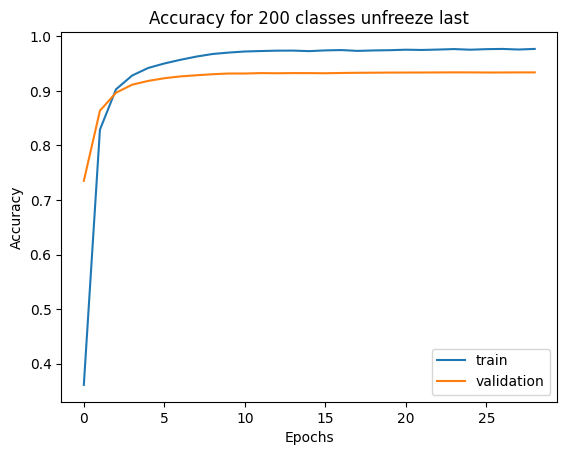

In [89]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze last", "Accuracy")

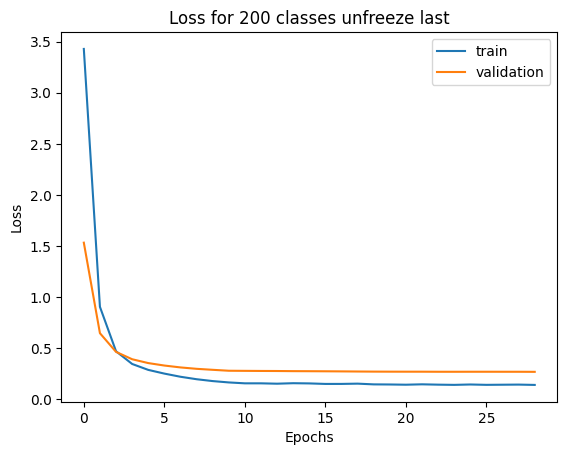

In [90]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze last", "Loss")

In [91]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:1

Test: loss 0.2701018452644348 accuracy 0.9340519905090332


U+5965 1.0 48.0
U+7528 1.0 79.0
U+7DCF 1.0 55.0
U+80FD 1.0 53.0
U+4E16 0.9931506849315068 146.0
U+540D 0.9922480620155039 129.0
U+4E00 0.9886792452830189 530.0
U+91D1 0.9873417721518988 79.0
U+8695 0.9871794871794872 156.0
U+53CA 0.987012987012987 77.0
U+5DE6 0.9868421052631579 76.0
U+795E 0.9868421052631579 76.0
U+716E 0.9863013698630136 73.0
U+7537 0.9857142857142858 70.0
U+7406 0.9855072463768116 69.0
U+5869 0.9850746268656716 67.0
U+4F5C 0.9838709677419355 62.0
U+5375 0.9830508474576272 59.0
U+714E 0.9830508474576272 59.0
U+5C45 0.9826086956521739 115.0
U+601D 0.9826086956521739 115.0
U+5341 0.9813664596273292 161.0
U+6D77 0.9807692307692307 52.0
U+8FD1 0.9803921568627451 51.0
U+52A0 0.9791666666666666 48.0
U+5207 0.9787234042553191 94.0
U+521D 0.9782608695652174 46.0
U+6851 0.9772727272727273 88.0
U+5973 0.9768518518518519 216.0
U+6C41 0.9746835443037974 158.0
U+516B 0.974025974025974 77.0
U+6210 0.9726027397260274 73.0
U+7A0B 0.9726027397260274 73.0
U+4E09 0.9705882352941176 238.

In [93]:
testing_models_metrics(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", train_test_indices_path="/kaggle/working/train_test_indices_200.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 6/6 [00:15

Test: loss 0.2701018452644348 accuracy 0.9340519905090332


Per-class accuracy:
U+5965: 1.00000 
U+7528: 1.00000 
U+7DCF: 1.00000 
U+80FD: 1.00000 
U+4E16: 0.99315 
U+540D: 0.99225 
U+4E00: 0.98868 
U+91D1: 0.98734 
U+8695: 0.98718 
U+53CA: 0.98701 
U+5DE6: 0.98684 
U+795E: 0.98684 
U+716E: 0.98630 
U+7537: 0.98571 
U+7406: 0.98551 
U+5869: 0.98507 
U+4F5C: 0.98387 
U+5375: 0.98305 
U+714E: 0.98305 
U+5C45: 0.98261 
U+601D: 0.98261 
U+5341: 0.98137 
U+6D77: 0.98077 
U+8FD1: 0.98039 
U+52A0: 0.97917 
U+5207: 0.97872 
U+521D: 0.97826 
U+6851: 0.97727 
U+5973: 0.97685 
U+6C41: 0.97468 
U+516B: 0.97403 
U+6210: 0.97260 
U+7A0B: 0.97260 
U+4E09: 0.97059 
U+4EAC: 0.97015 
U+5473: 0.96939 
U+713C: 0.96825 
U+901A: 0.96825 
U+662F: 0.96748 
U+6CBB: 0.96739 
U+6216: 0.96667 
U+5C0F: 0.96654 
U+5DDD: 0.96610 
U+5BB6: 0.96552 
U+4ED8: 0.96512 
U+6238: 0.96460 
U+5730: 0.96364 
U+9593: 0.96341 
U+98DF: 0.96203 
U+547C: 0.96154 
U+5F62: 0.96078 
U+76BF: 0.96078 
U+6771: 0.96032 
U+4E0B: 0.96000 
U+4E5D: 0.96000 
U+9577: 0.95946 
U+7A2E: 0.95890 
U+53C8: 0.9

# Pretrained CASIA-HWDB unfreeze last, 300 classes logic

In [94]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300, train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

/tmp/ipykernel_23/2173897448.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))


In [95]:
# Training loop

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", model_name="300 classes unfreeze last", freeze_base=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:34<00:00,  2.15s/it]

  1%|          | 1/100 [00:52<1:25:51, 52.04s/it]

Epoch: 1
Train: loss 3.5504188537597656 accuracy 0.37325555086135864
Validation: loss 1.5555834770202637 accuracy 0.7336122393608093



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

  2%|▏         | 2/100 [01:42<1:23:27, 51.09s/it]

Epoch: 2
Train: loss 0.8745694756507874 accuracy 0.8401846885681152
Validation: loss 0.6808959245681763 accuracy 0.8586838841438293



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.06s/it]

  3%|▎         | 3/100 [02:32<1:22:02, 50.75s/it]

Epoch: 3
Train: loss 0.4689537584781647 accuracy 0.9049682021141052
Validation: loss 0.5025234222412109 accuracy 0.8899822235107422



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

  4%|▍         | 4/100 [03:22<1:20:48, 50.51s/it]

Epoch: 4
Train: loss 0.3409803509712219 accuracy 0.9305128455162048
Validation: loss 0.43232467770576477 accuracy 0.9030531048774719



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

  5%|▌         | 5/100 [04:13<1:19:48, 50.40s/it]

Epoch: 5
Train: loss 0.2823195159435272 accuracy 0.9451672434806824
Validation: loss 0.3961135447025299 accuracy 0.9089237451553345



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

  6%|▌         | 6/100 [05:02<1:18:34, 50.15s/it]

Epoch: 6
Train: loss 0.23869894444942474 accuracy 0.9568052887916565
Validation: loss 0.3680916428565979 accuracy 0.913703978061676



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.08s/it]

  7%|▋         | 7/100 [05:53<1:17:53, 50.25s/it]

Epoch: 7
Train: loss 0.2150345891714096 accuracy 0.9621412754058838
Validation: loss 0.3468538820743561 accuracy 0.9185519218444824



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.06s/it]

  8%|▊         | 8/100 [06:43<1:17:03, 50.26s/it]

Epoch: 8
Train: loss 0.19267159700393677 accuracy 0.9674830436706543
Validation: loss 0.33403244614601135 accuracy 0.9212395548820496



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

  9%|▉         | 9/100 [07:33<1:16:07, 50.20s/it]

Epoch: 9
Train: loss 0.1684139370918274 accuracy 0.9730866551399231
Validation: loss 0.3224068880081177 accuracy 0.9236450791358948



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

 10%|█         | 10/100 [08:24<1:15:26, 50.29s/it]

Epoch: 10
Train: loss 0.15617796778678894 accuracy 0.9750820994377136
Validation: loss 0.311840683221817 accuracy 0.9263460040092468



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

 11%|█         | 11/100 [09:15<1:14:52, 50.48s/it]

Epoch: 11
Train: loss 0.14981159567832947 accuracy 0.9760808944702148
Validation: loss 0.3106667697429657 accuracy 0.9264814257621765



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.09s/it]

 12%|█▏        | 12/100 [10:05<1:14:02, 50.49s/it]

Epoch: 12
Train: loss 0.143954798579216 accuracy 0.9775304794311523
Validation: loss 0.31006377935409546 accuracy 0.9269502758979797



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:34<00:00,  2.13s/it]

 13%|█▎        | 13/100 [10:56<1:13:31, 50.70s/it]

Epoch: 13
Train: loss 0.14028704166412354 accuracy 0.9784331321716309
Validation: loss 0.3088289797306061 accuracy 0.9269307851791382



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.09s/it]

 14%|█▍        | 14/100 [11:47<1:12:43, 50.74s/it]

Epoch: 14
Train: loss 0.1439618468284607 accuracy 0.9772112369537354
Validation: loss 0.3082711696624756 accuracy 0.9270312190055847



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:35<00:00,  2.23s/it]

 15%|█▌        | 15/100 [12:40<1:12:53, 51.45s/it]

Epoch: 15
Train: loss 0.13700351119041443 accuracy 0.9789260625839233
Validation: loss 0.3072022795677185 accuracy 0.9272446632385254



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.08s/it]

 16%|█▌        | 16/100 [13:31<1:11:43, 51.23s/it]

Epoch: 16
Train: loss 0.13640737533569336 accuracy 0.9796068668365479
Validation: loss 0.3056389391422272 accuracy 0.927364706993103



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.04s/it]

 17%|█▋        | 17/100 [14:21<1:10:29, 50.96s/it]

Epoch: 17
Train: loss 0.137775257229805 accuracy 0.9794085025787354
Validation: loss 0.3045237958431244 accuracy 0.9277134537696838



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.08s/it]

 18%|█▊        | 18/100 [15:12<1:09:33, 50.90s/it]

Epoch: 18
Train: loss 0.13527043163776398 accuracy 0.9794262051582336
Validation: loss 0.30383801460266113 accuracy 0.9278181195259094



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.10s/it]

 19%|█▉        | 19/100 [16:02<1:08:33, 50.79s/it]

Epoch: 19
Train: loss 0.13575713336467743 accuracy 0.9797876477241516
Validation: loss 0.3032279908657074 accuracy 0.9279617071151733



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.09s/it]

 20%|██        | 20/100 [16:53<1:07:40, 50.76s/it]

Epoch: 20
Train: loss 0.1305370032787323 accuracy 0.9810200929641724
Validation: loss 0.30197083950042725 accuracy 0.9279883503913879



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

 21%|██        | 21/100 [17:44<1:06:41, 50.66s/it]

Epoch: 21
Train: loss 0.136010080575943 accuracy 0.9795012474060059
Validation: loss 0.30164477229118347 accuracy 0.9280232191085815



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.06s/it]

 22%|██▏       | 22/100 [18:34<1:05:44, 50.57s/it]

Epoch: 22
Train: loss 0.13273316621780396 accuracy 0.9794625639915466
Validation: loss 0.30134233832359314 accuracy 0.9281975626945496



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

 23%|██▎       | 23/100 [19:24<1:04:43, 50.44s/it]

Epoch: 23
Train: loss 0.1345975697040558 accuracy 0.9795529246330261
Validation: loss 0.30144065618515015 accuracy 0.9281278252601624



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.05s/it]

 24%|██▍       | 24/100 [20:14<1:03:46, 50.35s/it]

Epoch: 24
Train: loss 0.13200023770332336 accuracy 0.9799790382385254
Validation: loss 0.3012390732765198 accuracy 0.9282673597335815



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.07s/it]

 25%|██▌       | 25/100 [21:05<1:02:54, 50.33s/it]

Epoch: 25
Train: loss 0.13235871493816376 accuracy 0.9793804287910461
Validation: loss 0.3014677166938782 accuracy 0.9281821846961975



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.10s/it]

 26%|██▌       | 26/100 [21:55<1:02:08, 50.39s/it]

Epoch: 26
Train: loss 0.1317896842956543 accuracy 0.9801561832427979
Validation: loss 0.3015560507774353 accuracy 0.9280775785446167



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.06s/it]

 27%|██▋       | 27/100 [22:45<1:01:17, 50.38s/it]

Epoch: 27
Train: loss 0.12938621640205383 accuracy 0.9808663725852966
Validation: loss 0.30113276839256287 accuracy 0.9280232191085815



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:33<00:00,  2.06s/it]

 28%|██▊       | 28/100 [23:35<1:00:21, 50.29s/it]

Epoch: 28
Train: loss 0.13030804693698883 accuracy 0.9806104898452759
Validation: loss 0.3013366460800171 accuracy 0.9279729127883911



  0%|          | 0/16 [00:00<?, ?it/s]

Batch is processing: 0



100%|██████████| 16/16 [00:32<00:00,  2.06s/it]

 28%|██▊       | 28/100 [24:26<1:02:50, 52.37s/it]

Epoch: 29
Train: loss 0.13130125403404236 accuracy 0.9803380966186523
Validation: loss 0.3011755347251892 accuracy 0.9280775785446167
Best validation accuracy for 300 classes unfreeze last: 0.9282673597335815 Epoch 24


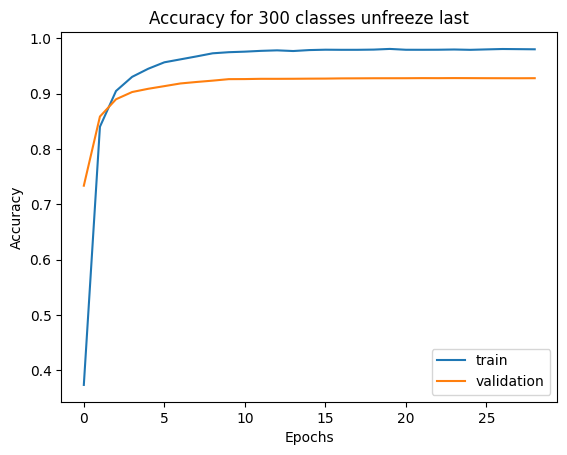

In [96]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze last", "Accuracy")

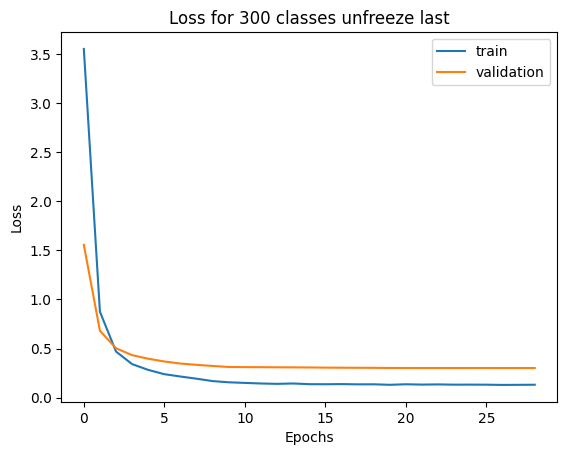

In [97]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze last", "Loss")

In [98]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/332828998.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:1

Test: loss 0.3012390732765198 accuracy 0.9282673597335815


U+4EE3 1.0 40.0
U+52A0 1.0 48.0
U+5357 1.0 40.0
U+5375 1.0 59.0
U+5965 1.0 48.0
U+5BBF 1.0 39.0
U+5F35 1.0 33.0
U+66FF 1.0 34.0
U+6B63 1.0 37.0
U+6BCD 1.0 33.0
U+6CB9 1.0 40.0
U+76BF 1.0 51.0
U+80FD 1.0 53.0
U+8338 1.0 33.0
U+89D2 1.0 35.0
U+9762 1.0 36.0
U+98DF 1.0 79.0
U+6238 0.9911504424778761 113.0
U+4E00 0.9905660377358491 530.0
U+7537 0.9857142857142858 70.0
U+4EAC 0.9850746268656716 67.0
U+751F 0.984375 128.0
U+713C 0.9841269841269841 63.0
U+5F37 0.9830508474576272 59.0
U+5185 0.9811320754716981 106.0
U+5148 0.9795918367346939 49.0
U+4E16 0.9794520547945206 146.0
U+7C89 0.9772727272727273 44.0
U+9152 0.9769230769230769 130.0
U+623F 0.9767441860465116 43.0
U+91CC 0.9767441860465116 43.0
U+7B11 0.9761904761904762 42.0
U+5C71 0.975609756097561 164.0
U+8584 0.975609756097561 41.0
U+4E91 0.9754716981132076 530.0
U+564C 0.975 40.0
U+89AA 0.975 40.0
U+6C5F 0.9747899159663865 119.0
U+5C3E 0.9743589743589743 39.0
U+7136 0.9743589743589743 39.0
U+8695 0.9743589743589743 156.0
U+5BB6 0.974

In [99]:
testing_models_metrics(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", train_test_indices_path="/kaggle/input/kkanji/stuff_for_models/train_test_indices_300.pkl")

/tmp/ipykernel_23/538083956.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
100%|██████████| 7/7 [00:16

Test: loss 0.3012390732765198 accuracy 0.9282673597335815


Per-class accuracy:
U+4EE3: 1.00000 
U+52A0: 1.00000 
U+5357: 1.00000 
U+5375: 1.00000 
U+5965: 1.00000 
U+5BBF: 1.00000 
U+5F35: 1.00000 
U+66FF: 1.00000 
U+6B63: 1.00000 
U+6BCD: 1.00000 
U+6CB9: 1.00000 
U+76BF: 1.00000 
U+80FD: 1.00000 
U+8338: 1.00000 
U+89D2: 1.00000 
U+9762: 1.00000 
U+98DF: 1.00000 
U+6238: 0.99115 
U+4E00: 0.99057 
U+7537: 0.98571 
U+4EAC: 0.98507 
U+751F: 0.98438 
U+713C: 0.98413 
U+5F37: 0.98305 
U+5185: 0.98113 
U+5148: 0.97959 
U+4E16: 0.97945 
U+7C89: 0.97727 
U+9152: 0.97692 
U+623F: 0.97674 
U+91CC: 0.97674 
U+7B11: 0.97619 
U+5C71: 0.97561 
U+8584: 0.97561 
U+4E91: 0.97547 
U+564C: 0.97500 
U+89AA: 0.97500 
U+6C5F: 0.97479 
U+5C3E: 0.97436 
U+7136: 0.97436 
U+8695: 0.97436 
U+5BB6: 0.97414 
U+4E03: 0.97403 
U+53CA: 0.97403 
U+601D: 0.97391 
U+5DE6: 0.97368 
U+60C5: 0.97368 
U+904E: 0.97368 
U+4E0B: 0.97333 
U+4F0A: 0.97297 
U+6210: 0.97260 
U+4F50: 0.97222 
U+5408: 0.97143 
U+767E: 0.97143 
U+79CB: 0.97143 
U+5165: 0.97090 
U+7D30: 0.97059 
U+81B3: 0.9

# CASIA-HWDB logic

In [ ]:
# Getting stuff for training
pathes = create_pathes_vocabulary("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff")

trainloader, testloader, _ = get_dataloaders_CASIA_HWDB(batch_size=4096)

stuff = getting_stuff_for_training(classamount=6764, pathes=pathes)

/tmp/ipykernel_30/4290371203.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.  model.load_state_dict(torch.load(pathes["model"]))/tmp/ipykernel_30/4290371203.py:69: Future

In [ ]:
# Training loop 

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_CASIA_HWDB_stuff", model_name="CASIA_HWDB")

  0%|          | 0/100 [00:00<?, ?it/s]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:23<4:38:25, 23.76s/it]  0%|          | 2/704 [00:24<2:01:36, 10.39s/it]  0%|          | 3/704 [00:25<1:11:31,  6.12s/it]  1%|          | 4/704 [00:26<48:01,  4.12s/it]    1%|          | 5/704 [00:44<1:42:55,  8.83s/it]  1%|          | 6/704 [00:45<1:11:56,  6.18s/it]  1%|          | 7/704 [00:46<52:17,  4.50s/it]    1%|          | 8/704 [00:47<39:25,  3.40s/it]  1%|▏         | 9/704 [01:04<1:28:50,  7.67s/it]  1%|▏         | 10/704 [01:05<1:05:01,  5.62s/it]  2%|▏         | 11/704 [01:06<48:43,  4.22s/it]    2%|▏         | 12/704 [01:07<37:30,  3.25s/it]  2%|▏         | 13/704 [01:26<1:32:17,  8.01s/it]  2%|▏         | 14/704 [01:27<1:07:55,  5.91s/it]  2%|▏         | 15/704 [01:28<50:58,  4.44s/it]    2%|▏         | 16/704 [01:29<39:10,  3.42s/it]  2%|▏         | 17/704 [01:46<1:27:31,  7.64s/it]  3%|▎         | 18/704 [01:47<1:04:42,  5.66s/it]  3%|▎         | 19/704 [01:49<48:45,  4.27s/it]    3%|▎         | 20/704 [01:50<37:37,  3.30s/it]  3%|▎         | 

Batch is processing: 100

 14%|█▍        | 101/704 [08:46<1:14:54,  7.45s/it] 14%|█▍        | 102/704 [08:47<55:29,  5.53s/it]   15%|█▍        | 103/704 [08:48<41:53,  4.18s/it] 15%|█▍        | 104/704 [08:49<32:23,  3.24s/it] 15%|█▍        | 105/704 [09:06<1:12:47,  7.29s/it] 15%|█▌        | 106/704 [09:07<53:58,  5.42s/it]   15%|█▌        | 107/704 [09:08<40:48,  4.10s/it] 15%|█▌        | 108/704 [09:09<31:37,  3.18s/it] 15%|█▌        | 109/704 [09:25<1:11:12,  7.18s/it] 16%|█▌        | 110/704 [09:26<52:50,  5.34s/it]   16%|█▌        | 111/704 [09:28<40:00,  4.05s/it] 16%|█▌        | 112/704 [09:29<31:01,  3.15s/it] 16%|█▌        | 113/704 [09:45<1:09:29,  7.05s/it] 16%|█▌        | 114/704 [09:46<51:37,  5.25s/it]   16%|█▋        | 115/704 [09:47<39:07,  3.99s/it] 16%|█▋        | 116/704 [09:48<30:24,  3.10s/it] 17%|█▋        | 117/704 [10:03<1:06:06,  6.76s/it] 17%|█▋        | 118/704 [10:04<49:14,  5.04s/it]   17%|█▋        | 119/704 [10:05<37:26,  3.84s/it] 17%|█▋        | 120/704 [10:06<29:12,  3.00s/it]

Batch is processing: 200

 29%|██▊       | 201/704 [16:45<56:20,  6.72s/it] 29%|██▊       | 202/704 [16:46<41:58,  5.02s/it] 29%|██▉       | 203/704 [16:47<31:54,  3.82s/it] 29%|██▉       | 204/704 [16:48<24:53,  2.99s/it] 29%|██▉       | 205/704 [17:03<55:11,  6.64s/it] 29%|██▉       | 206/704 [17:04<41:08,  4.96s/it] 29%|██▉       | 207/704 [17:05<31:19,  3.78s/it] 30%|██▉       | 208/704 [17:06<24:27,  2.96s/it] 30%|██▉       | 209/704 [17:22<55:52,  6.77s/it] 30%|██▉       | 210/704 [17:23<41:35,  5.05s/it] 30%|██▉       | 211/704 [17:24<31:37,  3.85s/it] 30%|███       | 212/704 [17:25<24:38,  3.00s/it] 30%|███       | 213/704 [17:41<55:59,  6.84s/it] 30%|███       | 214/704 [17:42<41:39,  5.10s/it] 31%|███       | 215/704 [17:43<31:38,  3.88s/it] 31%|███       | 216/704 [17:44<24:38,  3.03s/it] 31%|███       | 217/704 [17:59<52:32,  6.47s/it] 31%|███       | 218/704 [18:00<39:13,  4.84s/it] 31%|███       | 219/704 [18:01<29:55,  3.70s/it] 31%|███▏      | 220/704 [18:02<23:24,  2.90s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [24:21<43:20,  6.45s/it] 43%|████▎     | 302/704 [24:22<32:20,  4.83s/it] 43%|████▎     | 303/704 [24:23<24:40,  3.69s/it] 43%|████▎     | 304/704 [24:24<19:18,  2.90s/it] 43%|████▎     | 305/704 [24:39<42:46,  6.43s/it] 43%|████▎     | 306/704 [24:40<31:55,  4.81s/it] 44%|████▎     | 307/704 [24:41<24:21,  3.68s/it] 44%|████▍     | 308/704 [24:42<19:03,  2.89s/it] 44%|████▍     | 309/704 [24:56<41:05,  6.24s/it] 44%|████▍     | 310/704 [24:57<30:44,  4.68s/it] 44%|████▍     | 311/704 [24:58<23:29,  3.59s/it] 44%|████▍     | 312/704 [24:59<18:26,  2.82s/it] 44%|████▍     | 313/704 [25:13<40:23,  6.20s/it] 45%|████▍     | 314/704 [25:14<30:13,  4.65s/it] 45%|████▍     | 315/704 [25:16<23:07,  3.57s/it] 45%|████▍     | 316/704 [25:17<18:09,  2.81s/it] 45%|████▌     | 317/704 [25:32<41:59,  6.51s/it] 45%|████▌     | 318/704 [25:33<31:19,  4.87s/it] 45%|████▌     | 319/704 [25:34<23:51,  3.72s/it] 45%|████▌     | 320/704 [25:35<18:39,  2.91s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [31:36<32:16,  6.39s/it] 57%|█████▋    | 402/704 [31:37<24:05,  4.79s/it] 57%|█████▋    | 403/704 [31:38<18:21,  3.66s/it] 57%|█████▋    | 404/704 [31:39<14:22,  2.88s/it] 58%|█████▊    | 405/704 [31:52<30:24,  6.10s/it] 58%|█████▊    | 406/704 [31:53<22:45,  4.58s/it] 58%|█████▊    | 407/704 [31:54<17:25,  3.52s/it] 58%|█████▊    | 408/704 [31:55<13:41,  2.78s/it] 58%|█████▊    | 409/704 [32:09<29:54,  6.08s/it] 58%|█████▊    | 410/704 [32:10<22:23,  4.57s/it] 58%|█████▊    | 411/704 [32:11<17:08,  3.51s/it] 59%|█████▊    | 412/704 [32:12<13:28,  2.77s/it] 59%|█████▊    | 413/704 [32:27<30:18,  6.25s/it] 59%|█████▉    | 414/704 [32:28<22:38,  4.69s/it] 59%|█████▉    | 415/704 [32:29<17:17,  3.59s/it] 59%|█████▉    | 416/704 [32:30<13:33,  2.83s/it] 59%|█████▉    | 417/704 [32:43<28:35,  5.98s/it] 59%|█████▉    | 418/704 [32:44<21:26,  4.50s/it] 60%|█████▉    | 419/704 [32:45<16:25,  3.46s/it] 60%|█████▉    | 420/704 [32:46<12:56,  2.73s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [38:39<20:25,  6.04s/it] 71%|███████▏  | 502/704 [38:40<15:16,  4.54s/it] 71%|███████▏  | 503/704 [38:41<11:41,  3.49s/it] 72%|███████▏  | 504/704 [38:43<09:10,  2.75s/it] 72%|███████▏  | 505/704 [38:56<19:18,  5.82s/it] 72%|███████▏  | 506/704 [38:57<14:28,  4.39s/it] 72%|███████▏  | 507/704 [38:58<11:06,  3.38s/it] 72%|███████▏  | 508/704 [38:59<08:45,  2.68s/it] 72%|███████▏  | 509/704 [39:12<19:06,  5.88s/it] 72%|███████▏  | 510/704 [39:13<14:19,  4.43s/it] 73%|███████▎  | 511/704 [39:14<10:58,  3.41s/it] 73%|███████▎  | 512/704 [39:15<08:38,  2.70s/it] 73%|███████▎  | 513/704 [39:29<19:27,  6.11s/it] 73%|███████▎  | 514/704 [39:30<14:31,  4.59s/it] 73%|███████▎  | 515/704 [39:31<11:06,  3.52s/it] 73%|███████▎  | 516/704 [39:32<08:42,  2.78s/it] 73%|███████▎  | 517/704 [39:45<18:18,  5.87s/it] 74%|███████▎  | 518/704 [39:46<13:42,  4.42s/it] 74%|███████▎  | 519/704 [39:47<10:30,  3.41s/it] 74%|███████▍  | 520/704 [39:48<08:16,  2.70s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [45:29<10:02,  5.85s/it] 86%|████████▌ | 602/704 [45:30<07:29,  4.41s/it] 86%|████████▌ | 603/704 [45:31<05:43,  3.40s/it] 86%|████████▌ | 604/704 [45:32<04:28,  2.69s/it] 86%|████████▌ | 605/704 [45:45<09:41,  5.87s/it] 86%|████████▌ | 606/704 [45:46<07:13,  4.42s/it] 86%|████████▌ | 607/704 [45:47<05:30,  3.41s/it] 86%|████████▋ | 608/704 [45:48<04:18,  2.70s/it] 87%|████████▋ | 609/704 [46:02<09:22,  5.92s/it] 87%|████████▋ | 610/704 [46:03<06:58,  4.45s/it] 87%|████████▋ | 611/704 [46:04<05:18,  3.43s/it] 87%|████████▋ | 612/704 [46:05<04:09,  2.71s/it] 87%|████████▋ | 613/704 [46:18<08:42,  5.74s/it] 87%|████████▋ | 614/704 [46:19<06:29,  4.33s/it] 87%|████████▋ | 615/704 [46:20<04:57,  3.34s/it] 88%|████████▊ | 616/704 [46:21<03:53,  2.65s/it] 88%|████████▊ | 617/704 [46:35<08:41,  5.99s/it] 88%|████████▊ | 618/704 [46:36<06:27,  4.51s/it] 88%|████████▊ | 619/704 [46:37<04:54,  3.47s/it] 88%|████████▊ | 620/704 [46:38<03:49,  2.74s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [52:09<00:15,  5.23s/it]100%|█████████▉| 702/704 [52:10<00:07,  3.97s/it]100%|██████████| 704/704 [52:11<00:00,  4.45s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:25<1:14:32, 25.56s/it]  1%|          | 2/176 [00:26<31:21, 10.82s/it]    2%|▏         | 3/176 [00:26<17:19,  6.01s/it]  2%|▏         | 4/176 [00:26<10:44,  3.75s/it]  3%|▎         | 5/176 [00:49<30:09, 10.58s/it]  3%|▎         | 6/176 [00:49<20:07,  7.10s/it]  4%|▍         | 7/176 [00:49<13:43,  4.87s/it]  5%|▍         | 8/176 [00:50<09:33,  3.41s/it]  5%|▌         | 9/176 [01:14<27:19,  9.81s/it]  6%|▌         | 10/176 [01:14<19:10,  6.93s/it]  6%|▋         | 11/176 [01:14<13:28,  4.90s/it]  7%|▋         | 12/176 [01:15<09:33,  3.50s/it]  7%|▋         | 13/176 [01:38<26:10,  9.64s/it]  8%|▊         | 14/176 [01:39<18:38,  6.91s/it]  9%|▊         | 15/176 [01:39<13:10,  4.91s/it]  9%|▉         | 16/176 [01:40<09:23,  3.52s/it] 10%|▉         | 17/176 [02:03<25:31,  9.63s/it] 10

Epoch: 12Train: loss 0.024677976965904236 accuracy 0.9938468933105469Validation: loss 0.3320419192314148 accuracy 0.932234525680542

  1%|          | 1/100 [1:11:03<117:14:14, 4263.18s/it]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:19<3:49:54, 19.62s/it]  0%|          | 2/704 [00:20<1:41:39,  8.69s/it]  0%|          | 3/704 [00:21<1:00:41,  5.19s/it]  1%|          | 4/704 [00:22<41:28,  3.55s/it]    1%|          | 5/704 [00:37<1:29:42,  7.70s/it]  1%|          | 6/704 [00:38<1:03:13,  5.43s/it]  1%|          | 7/704 [00:39<46:25,  4.00s/it]    1%|          | 8/704 [00:40<35:26,  3.05s/it]  1%|▏         | 9/704 [00:55<1:17:55,  6.73s/it]  1%|▏         | 10/704 [00:56<57:29,  4.97s/it]   2%|▏         | 11/704 [00:57<43:30,  3.77s/it]  2%|▏         | 12/704 [00:58<33:52,  2.94s/it]  2%|▏         | 13/704 [01:13<1:14:45,  6.49s/it]  2%|▏         | 14/704 [01:14<55:42,  4.84s/it]    2%|▏         | 15/704 [01:15<42:27,  3.70s/it]  2%|▏         | 16/704 [01:16<33:12,  2.90s/it]  2%|▏         | 17/704 [01:31<1:14:01,  6.47s/it]  3%|▎         | 18/704 [01:32<55:16,  4.83s/it]    3%|▎         | 19/704 [01:33<42:10,  3.69s/it]  3%|▎         | 20/704 [01:34<33:02,  2.90s/it]  3%|▎         | 21/704 

Batch is processing: 100

 14%|█▍        | 101/704 [07:26<1:02:15,  6.20s/it] 14%|█▍        | 102/704 [07:27<46:37,  4.65s/it]   15%|█▍        | 103/704 [07:28<35:42,  3.56s/it] 15%|█▍        | 104/704 [07:29<28:03,  2.81s/it] 15%|█▍        | 105/704 [07:43<1:00:17,  6.04s/it] 15%|█▌        | 106/704 [07:44<45:13,  4.54s/it]   15%|█▌        | 107/704 [07:45<34:42,  3.49s/it] 15%|█▌        | 108/704 [07:46<27:20,  2.75s/it] 15%|█▌        | 109/704 [07:59<57:16,  5.78s/it] 16%|█▌        | 110/704 [08:00<43:06,  4.35s/it] 16%|█▌        | 111/704 [08:01<33:11,  3.36s/it] 16%|█▌        | 112/704 [08:02<26:17,  2.66s/it] 16%|█▌        | 113/704 [08:15<57:40,  5.85s/it] 16%|█▌        | 114/704 [08:16<43:21,  4.41s/it] 16%|█▋        | 115/704 [08:17<33:21,  3.40s/it] 16%|█▋        | 116/704 [08:18<26:21,  2.69s/it] 17%|█▋        | 117/704 [08:32<59:22,  6.07s/it] 17%|█▋        | 118/704 [08:33<44:32,  4.56s/it] 17%|█▋        | 119/704 [08:34<34:09,  3.50s/it] 17%|█▋        | 120/704 [08:35<26:54,  2.76s/it] 17%|█▋     

Batch is processing: 200

 29%|██▊       | 201/704 [14:22<52:02,  6.21s/it] 29%|██▊       | 202/704 [14:23<38:58,  4.66s/it] 29%|██▉       | 203/704 [14:24<29:49,  3.57s/it] 29%|██▉       | 204/704 [14:25<23:25,  2.81s/it] 29%|██▉       | 205/704 [14:40<53:24,  6.42s/it] 29%|██▉       | 206/704 [14:41<39:54,  4.81s/it] 29%|██▉       | 207/704 [14:42<30:26,  3.68s/it] 30%|██▉       | 208/704 [14:43<23:50,  2.88s/it] 30%|██▉       | 209/704 [14:58<52:18,  6.34s/it] 30%|██▉       | 210/704 [14:59<39:06,  4.75s/it] 30%|██▉       | 211/704 [15:00<29:52,  3.64s/it] 30%|███       | 212/704 [15:01<23:25,  2.86s/it] 30%|███       | 213/704 [15:15<51:13,  6.26s/it] 30%|███       | 214/704 [15:16<38:20,  4.69s/it] 31%|███       | 215/704 [15:17<29:18,  3.60s/it] 31%|███       | 216/704 [15:18<23:00,  2.83s/it] 31%|███       | 217/704 [15:34<53:33,  6.60s/it] 31%|███       | 218/704 [15:35<39:56,  4.93s/it] 31%|███       | 219/704 [15:36<30:24,  3.76s/it] 31%|███▏      | 220/704 [15:37<23:45,  2.95s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [21:30<42:20,  6.30s/it] 43%|████▎     | 302/704 [21:31<31:39,  4.73s/it] 43%|████▎     | 303/704 [21:32<24:11,  3.62s/it] 43%|████▎     | 304/704 [21:33<18:57,  2.84s/it] 43%|████▎     | 305/704 [21:46<39:46,  5.98s/it] 43%|████▎     | 306/704 [21:47<29:51,  4.50s/it] 44%|████▎     | 307/704 [21:48<22:53,  3.46s/it] 44%|████▍     | 308/704 [21:49<18:02,  2.73s/it] 44%|████▍     | 309/704 [22:03<39:34,  6.01s/it] 44%|████▍     | 310/704 [22:04<29:40,  4.52s/it] 44%|████▍     | 311/704 [22:05<22:45,  3.47s/it] 44%|████▍     | 312/704 [22:06<17:55,  2.74s/it] 44%|████▍     | 313/704 [22:21<41:07,  6.31s/it] 45%|████▍     | 314/704 [22:22<30:44,  4.73s/it] 45%|████▍     | 315/704 [22:23<23:28,  3.62s/it] 45%|████▍     | 316/704 [22:24<18:24,  2.85s/it] 45%|████▌     | 317/704 [22:38<40:56,  6.35s/it] 45%|████▌     | 318/704 [22:39<30:35,  4.75s/it] 45%|████▌     | 319/704 [22:41<23:21,  3.64s/it] 45%|████▌     | 320/704 [22:42<18:17,  2.86s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [28:35<30:33,  6.05s/it] 57%|█████▋    | 402/704 [28:36<22:53,  4.55s/it] 57%|█████▋    | 403/704 [28:37<17:31,  3.49s/it] 57%|█████▋    | 404/704 [28:38<13:47,  2.76s/it] 58%|█████▊    | 405/704 [28:51<29:01,  5.82s/it] 58%|█████▊    | 406/704 [28:52<21:47,  4.39s/it] 58%|█████▊    | 407/704 [28:53<16:44,  3.38s/it] 58%|█████▊    | 408/704 [28:54<13:13,  2.68s/it] 58%|█████▊    | 409/704 [29:07<28:01,  5.70s/it] 58%|█████▊    | 410/704 [29:08<21:04,  4.30s/it] 58%|█████▊    | 411/704 [29:09<16:13,  3.32s/it] 59%|█████▊    | 412/704 [29:10<12:49,  2.64s/it] 59%|█████▊    | 413/704 [29:23<28:13,  5.82s/it] 59%|█████▉    | 414/704 [29:24<21:11,  4.39s/it] 59%|█████▉    | 415/704 [29:25<16:17,  3.38s/it] 59%|█████▉    | 416/704 [29:26<12:51,  2.68s/it] 59%|█████▉    | 417/704 [29:40<28:04,  5.87s/it] 59%|█████▉    | 418/704 [29:41<21:04,  4.42s/it] 60%|█████▉    | 419/704 [29:42<16:10,  3.41s/it] 60%|█████▉    | 420/704 [29:43<12:45,  2.70s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [35:31<22:07,  6.54s/it] 71%|███████▏  | 502/704 [35:32<16:27,  4.89s/it] 71%|███████▏  | 503/704 [35:33<12:30,  3.73s/it] 72%|███████▏  | 504/704 [35:34<09:45,  2.93s/it] 72%|███████▏  | 505/704 [35:49<20:52,  6.29s/it] 72%|███████▏  | 506/704 [35:50<15:33,  4.72s/it] 72%|███████▏  | 507/704 [35:51<11:51,  3.61s/it] 72%|███████▏  | 508/704 [35:52<09:16,  2.84s/it] 72%|███████▏  | 509/704 [36:06<20:36,  6.34s/it] 72%|███████▏  | 510/704 [36:07<15:22,  4.75s/it] 73%|███████▎  | 511/704 [36:08<11:42,  3.64s/it] 73%|███████▎  | 512/704 [36:09<09:08,  2.86s/it] 73%|███████▎  | 513/704 [36:25<21:07,  6.64s/it] 73%|███████▎  | 514/704 [36:26<15:41,  4.96s/it] 73%|███████▎  | 515/704 [36:27<11:54,  3.78s/it] 73%|███████▎  | 516/704 [36:28<09:16,  2.96s/it] 73%|███████▎  | 517/704 [36:42<19:34,  6.28s/it] 74%|███████▎  | 518/704 [36:43<14:35,  4.71s/it] 74%|███████▎  | 519/704 [36:44<11:07,  3.61s/it] 74%|███████▍  | 520/704 [36:45<08:42,  2.84s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [42:28<10:18,  6.01s/it] 86%|████████▌ | 602/704 [42:29<07:40,  4.52s/it] 86%|████████▌ | 603/704 [42:30<05:50,  3.47s/it] 86%|████████▌ | 604/704 [42:31<04:34,  2.75s/it] 86%|████████▌ | 605/704 [42:45<09:52,  5.98s/it] 86%|████████▌ | 606/704 [42:46<07:21,  4.50s/it] 86%|████████▌ | 607/704 [42:47<05:35,  3.46s/it] 86%|████████▋ | 608/704 [42:48<04:22,  2.74s/it] 87%|████████▋ | 609/704 [43:00<08:55,  5.64s/it] 87%|████████▋ | 610/704 [43:01<06:40,  4.26s/it] 87%|████████▋ | 611/704 [43:02<05:06,  3.29s/it] 87%|████████▋ | 612/704 [43:03<04:00,  2.62s/it] 87%|████████▋ | 613/704 [43:17<08:54,  5.88s/it] 87%|████████▋ | 614/704 [43:18<06:38,  4.42s/it] 87%|████████▋ | 615/704 [43:19<05:03,  3.41s/it] 88%|████████▊ | 616/704 [43:20<03:57,  2.70s/it] 88%|████████▊ | 617/704 [43:33<08:35,  5.92s/it] 88%|████████▊ | 618/704 [43:34<06:23,  4.46s/it] 88%|████████▊ | 619/704 [43:35<04:51,  3.43s/it] 88%|████████▊ | 620/704 [43:36<03:47,  2.71s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [49:07<00:15,  5.31s/it]100%|█████████▉| 702/704 [49:08<00:08,  4.03s/it]100%|██████████| 704/704 [49:10<00:00,  4.19s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:12<35:00, 12.00s/it]  1%|          | 2/176 [00:12<14:52,  5.13s/it]  2%|▏         | 3/176 [00:12<08:25,  2.92s/it]  2%|▏         | 4/176 [00:12<05:23,  1.88s/it]  3%|▎         | 5/176 [00:23<14:19,  5.02s/it]  3%|▎         | 6/176 [00:23<09:40,  3.42s/it]  4%|▍         | 7/176 [00:24<06:44,  2.39s/it]  5%|▍         | 8/176 [00:24<04:49,  1.72s/it]  5%|▌         | 9/176 [00:34<12:12,  4.39s/it]  6%|▌         | 10/176 [00:35<08:43,  3.16s/it]  6%|▋         | 11/176 [00:35<06:16,  2.28s/it]  7%|▋         | 12/176 [00:35<04:34,  1.67s/it]  7%|▋         | 13/176 [00:46<11:49,  4.35s/it]  8%|▊         | 14/176 [00:46<08:53,  3.29s/it]  9%|▊         | 15/176 [00:47<06:24,  2.39s/it]  9%|▉         | 16/176 [00:47<04:41,  1.76s/it] 10%|▉         | 17/176 [00:57<11:22,  4.29s/it] 10%|█ 

Epoch: 13Train: loss 0.01859004609286785 accuracy 0.9956491589546204Validation: loss 0.33840808272361755 accuracy 0.932299017906189

  2%|▏         | 2/100 [2:08:47<103:15:43, 3793.31s/it]  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:17<3:26:25, 17.62s/it]  0%|          | 2/704 [00:18<1:32:00,  7.86s/it]  0%|          | 3/704 [00:19<55:27,  4.75s/it]    1%|          | 4/704 [00:20<38:17,  3.28s/it]  1%|          | 5/704 [00:33<1:17:29,  6.65s/it]  1%|          | 6/704 [00:34<55:10,  4.74s/it]    1%|          | 7/704 [00:35<41:01,  3.53s/it]  1%|          | 8/704 [00:36<31:45,  2.74s/it]  1%|▏         | 9/704 [00:49<1:08:59,  5.96s/it]  1%|▏         | 10/704 [00:50<51:19,  4.44s/it]   2%|▏         | 11/704 [00:51<39:14,  3.40s/it]  2%|▏         | 12/704 [00:52<30:54,  2.68s/it]  2%|▏         | 13/704 [01:04<1:03:43,  5.53s/it]  2%|▏         | 14/704 [01:05<48:01,  4.18s/it]    2%|▏         | 15/704 [01:06<37:05,  3.23s/it]  2%|▏         | 16/704 [01:07<29:28,  2.57s/it]  2%|▏         | 17/704 [01:20<1:05:00,  5.68s/it]  3%|▎         | 18/704 [01:21<48:59,  4.28s/it]    3%|▎         | 19/704 [01:22<37:46,  3.31s/it]  3%|▎         | 20/704 [01:23<29:57,  2.63s/it]  3%|▎         | 21/704 [01:

Batch is processing: 100

 14%|█▍        | 101/704 [06:48<57:43,  5.74s/it] 14%|█▍        | 102/704 [06:49<43:28,  4.33s/it] 15%|█▍        | 103/704 [06:50<33:29,  3.34s/it] 15%|█▍        | 104/704 [06:51<26:31,  2.65s/it] 15%|█▍        | 105/704 [07:03<54:07,  5.42s/it] 15%|█▌        | 106/704 [07:04<40:55,  4.11s/it] 15%|█▌        | 107/704 [07:05<31:41,  3.19s/it] 15%|█▌        | 108/704 [07:06<25:14,  2.54s/it] 15%|█▌        | 109/704 [07:18<53:50,  5.43s/it] 16%|█▌        | 110/704 [07:19<40:42,  4.11s/it] 16%|█▌        | 111/704 [07:20<31:31,  3.19s/it] 16%|█▌        | 112/704 [07:21<25:06,  2.55s/it] 16%|█▌        | 113/704 [07:34<54:17,  5.51s/it] 16%|█▌        | 114/704 [07:35<41:00,  4.17s/it] 16%|█▋        | 115/704 [07:36<31:43,  3.23s/it] 16%|█▋        | 116/704 [07:37<25:13,  2.57s/it] 17%|█▋        | 117/704 [07:49<54:24,  5.56s/it] 17%|█▋        | 118/704 [07:50<41:04,  4.20s/it] 17%|█▋        | 119/704 [07:51<31:44,  3.26s/it] 17%|█▋        | 120/704 [07:52<25:12,  2.59s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [13:12<44:38,  5.32s/it] 29%|██▊       | 202/704 [13:14<33:47,  4.04s/it] 29%|██▉       | 203/704 [13:15<26:12,  3.14s/it] 29%|██▉       | 204/704 [13:16<20:53,  2.51s/it] 29%|██▉       | 205/704 [13:27<44:12,  5.32s/it] 29%|██▉       | 206/704 [13:28<33:28,  4.03s/it] 29%|██▉       | 207/704 [13:30<25:57,  3.13s/it] 30%|██▉       | 208/704 [13:31<20:43,  2.51s/it] 30%|██▉       | 209/704 [13:43<45:41,  5.54s/it] 30%|██▉       | 210/704 [13:44<34:29,  4.19s/it] 30%|██▉       | 211/704 [13:45<26:39,  3.24s/it] 30%|███       | 212/704 [13:46<21:10,  2.58s/it] 30%|███       | 213/704 [13:58<43:50,  5.36s/it] 30%|███       | 214/704 [13:59<33:10,  4.06s/it] 31%|███       | 215/704 [14:00<25:42,  3.15s/it] 31%|███       | 216/704 [14:01<20:29,  2.52s/it] 31%|███       | 217/704 [14:13<44:08,  5.44s/it] 31%|███       | 218/704 [14:15<33:21,  4.12s/it] 31%|███       | 219/704 [14:16<25:48,  3.19s/it] 31%|███▏      | 220/704 [14:17<20:32,  2.55s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [19:29<34:45,  5.17s/it] 43%|████▎     | 302/704 [19:30<26:21,  3.93s/it] 43%|████▎     | 303/704 [19:31<20:29,  3.06s/it] 43%|████▎     | 304/704 [19:32<16:22,  2.46s/it] 43%|████▎     | 305/704 [19:43<34:35,  5.20s/it] 43%|████▎     | 306/704 [19:44<26:12,  3.95s/it] 44%|████▎     | 307/704 [19:45<20:21,  3.08s/it] 44%|████▍     | 308/704 [19:46<16:16,  2.47s/it] 44%|████▍     | 309/704 [19:58<33:46,  5.13s/it] 44%|████▍     | 310/704 [19:59<25:37,  3.90s/it] 44%|████▍     | 311/704 [20:00<19:55,  3.04s/it] 44%|████▍     | 312/704 [20:01<15:57,  2.44s/it] 44%|████▍     | 313/704 [20:12<32:11,  4.94s/it] 45%|████▍     | 314/704 [20:13<24:30,  3.77s/it] 45%|████▍     | 315/704 [20:14<19:07,  2.95s/it] 45%|████▍     | 316/704 [20:15<15:22,  2.38s/it] 45%|████▌     | 317/704 [20:26<31:58,  4.96s/it] 45%|████▌     | 318/704 [20:27<24:21,  3.79s/it] 45%|████▌     | 319/704 [20:28<19:00,  2.96s/it] 45%|████▌     | 320/704 [20:29<15:15,  2.38s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [25:28<25:56,  5.14s/it] 57%|█████▋    | 402/704 [25:29<19:40,  3.91s/it] 57%|█████▋    | 403/704 [25:30<15:17,  3.05s/it] 57%|█████▋    | 404/704 [25:31<12:13,  2.44s/it] 58%|█████▊    | 405/704 [25:43<26:10,  5.25s/it] 58%|█████▊    | 406/704 [25:44<19:48,  3.99s/it] 58%|█████▊    | 407/704 [25:45<15:21,  3.10s/it] 58%|█████▊    | 408/704 [25:46<12:15,  2.48s/it] 58%|█████▊    | 409/704 [25:57<24:52,  5.06s/it] 58%|█████▊    | 410/704 [25:58<18:52,  3.85s/it] 58%|█████▊    | 411/704 [25:59<14:41,  3.01s/it] 59%|█████▊    | 412/704 [26:00<11:46,  2.42s/it] 59%|█████▊    | 413/704 [26:11<23:57,  4.94s/it] 59%|█████▉    | 414/704 [26:12<18:13,  3.77s/it] 59%|█████▉    | 415/704 [26:13<14:12,  2.95s/it] 59%|█████▉    | 416/704 [26:14<11:24,  2.38s/it] 59%|█████▉    | 417/704 [26:26<23:56,  5.00s/it] 59%|█████▉    | 418/704 [26:27<18:10,  3.81s/it] 60%|█████▉    | 419/704 [26:28<14:09,  2.98s/it] 60%|█████▉    | 420/704 [26:29<11:21,  2.40s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [31:27<17:10,  5.07s/it] 71%|███████▏  | 502/704 [31:28<13:00,  3.86s/it] 71%|███████▏  | 503/704 [31:29<10:06,  3.02s/it] 72%|███████▏  | 504/704 [31:30<08:04,  2.42s/it] 72%|███████▏  | 505/704 [31:43<17:57,  5.42s/it] 72%|███████▏  | 506/704 [31:44<13:32,  4.10s/it] 72%|███████▏  | 507/704 [31:45<10:27,  3.18s/it] 72%|███████▏  | 508/704 [31:46<08:17,  2.54s/it] 72%|███████▏  | 509/704 [31:57<16:24,  5.05s/it] 72%|███████▏  | 510/704 [31:58<12:26,  3.85s/it] 73%|███████▎  | 511/704 [31:59<09:40,  3.01s/it] 73%|███████▎  | 512/704 [32:00<07:43,  2.41s/it] 73%|███████▎  | 513/704 [32:11<15:46,  4.95s/it] 73%|███████▎  | 514/704 [32:12<11:57,  3.78s/it] 73%|███████▎  | 515/704 [32:13<09:18,  2.96s/it] 73%|███████▎  | 516/704 [32:14<07:27,  2.38s/it] 73%|███████▎  | 517/704 [32:26<16:16,  5.22s/it] 74%|███████▎  | 518/704 [32:27<12:18,  3.97s/it] 74%|███████▎  | 519/704 [32:28<09:31,  3.09s/it] 74%|███████▍  | 520/704 [32:29<07:35,  2.47s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [37:28<08:45,  5.11s/it] 86%|████████▌ | 602/704 [37:29<06:36,  3.89s/it] 86%|████████▌ | 603/704 [37:30<05:06,  3.03s/it] 86%|████████▌ | 604/704 [37:31<04:03,  2.43s/it] 86%|████████▌ | 605/704 [37:43<08:37,  5.22s/it] 86%|████████▌ | 606/704 [37:44<06:29,  3.97s/it] 86%|████████▌ | 607/704 [37:45<04:59,  3.09s/it] 86%|████████▋ | 608/704 [37:46<03:57,  2.47s/it] 87%|████████▋ | 609/704 [37:57<08:04,  5.10s/it] 87%|████████▋ | 610/704 [37:58<06:05,  3.88s/it] 87%|████████▋ | 611/704 [37:59<04:41,  3.03s/it] 87%|████████▋ | 612/704 [38:00<03:43,  2.43s/it] 87%|████████▋ | 613/704 [38:12<07:46,  5.13s/it] 87%|████████▋ | 614/704 [38:13<05:51,  3.90s/it] 87%|████████▋ | 615/704 [38:14<04:30,  3.04s/it] 88%|████████▊ | 616/704 [38:15<03:34,  2.44s/it] 88%|████████▊ | 617/704 [38:26<07:15,  5.01s/it] 88%|████████▊ | 618/704 [38:27<05:28,  3.82s/it] 88%|████████▊ | 619/704 [38:28<04:13,  2.99s/it] 88%|████████▊ | 620/704 [38:29<03:21,  2.40s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [43:27<00:13,  4.49s/it]100%|█████████▉| 702/704 [43:28<00:06,  3.45s/it]100%|██████████| 704/704 [43:29<00:00,  3.71s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:13<40:22, 13.84s/it]  1%|          | 2/176 [00:14<17:01,  5.87s/it]  2%|▏         | 3/176 [00:14<09:34,  3.32s/it]  2%|▏         | 4/176 [00:14<06:05,  2.12s/it]  3%|▎         | 5/176 [00:27<16:33,  5.81s/it]  3%|▎         | 6/176 [00:27<11:08,  3.94s/it]  4%|▍         | 7/176 [00:27<07:43,  2.74s/it]  5%|▍         | 8/176 [00:27<05:29,  1.96s/it]  5%|▌         | 9/176 [00:40<14:35,  5.25s/it]  6%|▌         | 10/176 [00:40<10:16,  3.71s/it]  6%|▋         | 11/176 [00:40<07:19,  2.67s/it]  7%|▋         | 12/176 [00:41<05:18,  1.94s/it]  7%|▋         | 13/176 [00:53<13:45,  5.06s/it]  8%|▊         | 14/176 [00:53<09:49,  3.64s/it]  9%|▊         | 15/176 [00:54<07:03,  2.63s/it]  9%|▉         | 16/176 [00:54<05:07,  1.92s/it] 10%|▉         | 17/176 [01:06<13:33,  5.12s/it] 10%|█ 

Epoch: 14Train: loss 0.012146293185651302 accuracy 0.9973730444908142Validation: loss 0.3478907644748688 accuracy 0.9325065612792969

  3%|▎         | 3/100 [3:03:01<95:34:42, 3547.24s/it]   0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:18<3:31:56, 18.09s/it]  0%|          | 2/704 [00:19<1:34:17,  8.06s/it]  0%|          | 3/704 [00:20<56:42,  4.85s/it]    1%|          | 4/704 [00:21<39:03,  3.35s/it]  1%|          | 5/704 [00:34<1:20:55,  6.95s/it]  1%|          | 6/704 [00:35<57:26,  4.94s/it]    1%|          | 7/704 [00:36<42:32,  3.66s/it]  1%|          | 8/704 [00:37<32:46,  2.83s/it]  1%|▏         | 9/704 [00:49<1:06:43,  5.76s/it]  1%|▏         | 10/704 [00:50<49:45,  4.30s/it]   2%|▏         | 11/704 [00:51<38:09,  3.30s/it]  2%|▏         | 12/704 [00:52<30:09,  2.61s/it]  2%|▏         | 13/704 [01:04<1:01:50,  5.37s/it]  2%|▏         | 14/704 [01:05<46:41,  4.06s/it]    2%|▏         | 15/704 [01:06<36:10,  3.15s/it]  2%|▏         | 16/704 [01:07<28:49,  2.51s/it]  2%|▏         | 17/704 [01:21<1:06:31,  5.81s/it]  3%|▎         | 18/704 [01:22<50:01,  4.38s/it]    3%|▎         | 19/704 [01:23<38:31,  3.37s/it]  3%|▎         | 20/704 [01:24<30:28,  2.67s/it]  3%|▎         | 21/704 [01:

Batch is processing: 100

 14%|█▍        | 101/704 [06:43<53:22,  5.31s/it] 14%|█▍        | 102/704 [06:45<41:57,  4.18s/it] 15%|█▍        | 103/704 [06:46<32:56,  3.29s/it] 15%|█▍        | 104/704 [06:47<26:07,  2.61s/it] 15%|█▍        | 105/704 [06:58<49:58,  5.01s/it] 15%|█▌        | 106/704 [06:59<40:48,  4.09s/it] 15%|█▌        | 107/704 [07:01<32:40,  3.28s/it] 15%|█▌        | 108/704 [07:02<25:55,  2.61s/it] 15%|█▌        | 109/704 [07:12<48:35,  4.90s/it] 16%|█▌        | 110/704 [07:15<41:12,  4.16s/it] 16%|█▌        | 111/704 [07:16<33:31,  3.39s/it] 16%|█▌        | 112/704 [07:17<26:29,  2.69s/it] 16%|█▌        | 113/704 [07:27<47:51,  4.86s/it] 16%|█▌        | 114/704 [07:30<40:33,  4.12s/it] 16%|█▋        | 115/704 [07:31<32:06,  3.27s/it] 16%|█▋        | 116/704 [07:32<25:29,  2.60s/it] 17%|█▋        | 117/704 [07:41<44:08,  4.51s/it] 17%|█▋        | 118/704 [07:43<38:12,  3.91s/it] 17%|█▋        | 119/704 [07:45<30:16,  3.11s/it] 17%|█▋        | 120/704 [07:46<24:12,  2.49s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [12:38<39:35,  4.72s/it] 29%|██▊       | 202/704 [12:42<37:28,  4.48s/it] 29%|██▉       | 203/704 [12:43<28:46,  3.45s/it] 29%|██▉       | 204/704 [12:44<22:41,  2.72s/it] 29%|██▉       | 205/704 [12:53<38:11,  4.59s/it] 29%|██▉       | 206/704 [12:56<36:14,  4.37s/it] 29%|██▉       | 207/704 [12:57<27:54,  3.37s/it] 30%|██▉       | 208/704 [12:59<22:04,  2.67s/it] 30%|██▉       | 209/704 [13:07<36:02,  4.37s/it] 30%|██▉       | 210/704 [13:10<34:05,  4.14s/it] 30%|██▉       | 211/704 [13:11<26:22,  3.21s/it] 30%|███       | 212/704 [13:13<20:58,  2.56s/it] 30%|███       | 213/704 [13:21<35:49,  4.38s/it] 30%|███       | 214/704 [13:26<36:01,  4.41s/it] 31%|███       | 215/704 [13:27<27:42,  3.40s/it] 31%|███       | 216/704 [13:28<21:52,  2.69s/it] 31%|███       | 217/704 [13:37<36:50,  4.54s/it] 31%|███       | 218/704 [13:40<34:35,  4.27s/it] 31%|███       | 219/704 [13:41<26:41,  3.30s/it] 31%|███▏      | 220/704 [13:42<21:09,  2.62s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [18:37<29:55,  4.45s/it] 43%|████▎     | 302/704 [18:40<27:44,  4.14s/it] 43%|████▎     | 303/704 [18:41<21:27,  3.21s/it] 43%|████▎     | 304/704 [18:42<17:03,  2.56s/it] 43%|████▎     | 305/704 [18:51<29:21,  4.41s/it] 43%|████▎     | 306/704 [18:55<27:53,  4.21s/it] 44%|████▎     | 307/704 [18:56<21:32,  3.26s/it] 44%|████▍     | 308/704 [18:57<17:05,  2.59s/it] 44%|████▍     | 309/704 [19:06<29:29,  4.48s/it] 44%|████▍     | 310/704 [19:09<27:15,  4.15s/it] 44%|████▍     | 311/704 [19:10<21:03,  3.22s/it] 44%|████▍     | 312/704 [19:11<16:44,  2.56s/it] 44%|████▍     | 313/704 [19:20<29:06,  4.47s/it] 45%|████▍     | 314/704 [19:24<27:24,  4.22s/it] 45%|████▍     | 315/704 [19:25<21:09,  3.26s/it] 45%|████▍     | 316/704 [19:26<16:47,  2.60s/it] 45%|████▌     | 317/704 [19:35<28:34,  4.43s/it] 45%|████▌     | 318/704 [19:38<27:09,  4.22s/it] 45%|████▌     | 319/704 [19:39<20:57,  3.27s/it] 45%|████▌     | 320/704 [19:40<16:37,  2.60s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [24:35<20:49,  4.12s/it] 57%|█████▋    | 402/704 [24:39<21:17,  4.23s/it] 57%|█████▋    | 403/704 [24:40<16:25,  3.27s/it] 57%|█████▋    | 404/704 [24:41<13:00,  2.60s/it] 58%|█████▊    | 405/704 [24:49<20:13,  4.06s/it] 58%|█████▊    | 406/704 [24:54<21:15,  4.28s/it] 58%|█████▊    | 407/704 [24:55<16:22,  3.31s/it] 58%|█████▊    | 408/704 [24:56<12:57,  2.63s/it] 58%|█████▊    | 409/704 [25:03<19:31,  3.97s/it] 58%|█████▊    | 410/704 [25:08<20:26,  4.17s/it] 58%|█████▊    | 411/704 [25:09<15:46,  3.23s/it] 59%|█████▊    | 412/704 [25:10<12:31,  2.57s/it] 59%|█████▊    | 413/704 [25:17<19:35,  4.04s/it] 59%|█████▉    | 414/704 [25:22<20:40,  4.28s/it] 59%|█████▉    | 415/704 [25:23<15:55,  3.31s/it] 59%|█████▉    | 416/704 [25:24<12:36,  2.63s/it] 59%|█████▉    | 417/704 [25:32<19:47,  4.14s/it] 59%|█████▉    | 418/704 [25:36<20:12,  4.24s/it] 60%|█████▉    | 419/704 [25:37<15:34,  3.28s/it] 60%|█████▉    | 420/704 [25:38<12:20,  2.61s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [30:33<13:10,  3.89s/it] 71%|███████▏  | 502/704 [30:39<15:14,  4.53s/it] 71%|███████▏  | 503/704 [30:40<11:39,  3.48s/it] 72%|███████▏  | 504/704 [30:41<09:09,  2.75s/it] 72%|███████▏  | 505/704 [30:48<13:04,  3.94s/it] 72%|███████▏  | 506/704 [30:54<14:41,  4.45s/it] 72%|███████▏  | 507/704 [30:55<11:15,  3.43s/it] 72%|███████▏  | 508/704 [30:56<08:51,  2.71s/it] 72%|███████▏  | 509/704 [31:02<12:39,  3.90s/it] 72%|███████▏  | 510/704 [31:08<14:22,  4.45s/it] 73%|███████▎  | 511/704 [31:09<11:01,  3.43s/it] 73%|███████▎  | 512/704 [31:10<08:40,  2.71s/it] 73%|███████▎  | 513/704 [31:17<12:27,  3.91s/it] 73%|███████▎  | 514/704 [31:23<14:19,  4.52s/it] 73%|███████▎  | 515/704 [31:24<10:57,  3.48s/it] 73%|███████▎  | 516/704 [31:25<08:36,  2.75s/it] 73%|███████▎  | 517/704 [31:32<12:31,  4.02s/it] 74%|███████▎  | 518/704 [31:38<14:44,  4.75s/it] 74%|███████▎  | 519/704 [31:39<11:13,  3.64s/it] 74%|███████▍  | 520/704 [31:40<08:45,  2.86s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [36:33<05:47,  3.37s/it] 86%|████████▌ | 602/704 [36:41<08:08,  4.79s/it] 86%|████████▌ | 603/704 [36:42<06:09,  3.66s/it] 86%|████████▌ | 604/704 [36:43<04:47,  2.88s/it] 86%|████████▌ | 605/704 [36:47<05:17,  3.21s/it] 86%|████████▌ | 606/704 [36:55<07:35,  4.65s/it] 86%|████████▌ | 607/704 [36:57<05:45,  3.57s/it] 86%|████████▋ | 608/704 [36:58<04:29,  2.81s/it] 87%|████████▋ | 609/704 [37:02<05:03,  3.20s/it] 87%|████████▋ | 610/704 [37:10<07:31,  4.81s/it] 87%|████████▋ | 611/704 [37:11<05:41,  3.68s/it] 87%|████████▋ | 612/704 [37:12<04:25,  2.89s/it] 87%|████████▋ | 613/704 [37:16<04:47,  3.16s/it] 87%|████████▋ | 614/704 [37:24<07:04,  4.72s/it] 87%|████████▋ | 615/704 [37:26<05:21,  3.62s/it] 88%|████████▊ | 616/704 [37:27<04:10,  2.84s/it] 88%|████████▊ | 617/704 [37:30<04:29,  3.10s/it] 88%|████████▊ | 618/704 [37:39<06:46,  4.72s/it] 88%|████████▊ | 619/704 [37:40<05:07,  3.62s/it] 88%|████████▊ | 620/704 [37:41<03:58,  2.84s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [42:22<00:08,  2.83s/it]100%|█████████▉| 702/704 [42:29<00:08,  4.34s/it]100%|██████████| 704/704 [42:31<00:00,  3.62s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<34:42, 11.90s/it]  1%|          | 2/176 [00:12<14:42,  5.07s/it]  2%|▏         | 3/176 [00:12<08:19,  2.89s/it]  2%|▏         | 4/176 [00:12<05:19,  1.86s/it]  3%|▎         | 5/176 [00:23<14:01,  4.92s/it]  3%|▎         | 6/176 [00:23<09:28,  3.34s/it]  4%|▍         | 7/176 [00:23<06:36,  2.34s/it]  5%|▍         | 8/176 [00:23<04:43,  1.69s/it]  5%|▌         | 9/176 [00:34<12:10,  4.38s/it]  6%|▌         | 10/176 [00:34<08:36,  3.11s/it]  6%|▋         | 11/176 [00:34<06:11,  2.25s/it]  7%|▋         | 12/176 [00:35<04:31,  1.65s/it]  7%|▋         | 13/176 [00:45<11:37,  4.28s/it]  8%|▊         | 14/176 [00:45<08:18,  3.07s/it]  9%|▊         | 15/176 [00:46<05:59,  2.23s/it]  9%|▉         | 16/176 [00:46<04:23,  1.65s/it] 10%|▉         | 17/176 [00:57<11:46,  4.44s/it] 10%|█ 

Epoch: 15Train: loss 0.01988203637301922 accuracy 0.9956651329994202Validation: loss 0.3538207411766052 accuracy 0.9316055774688721

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:16<3:10:43, 16.28s/it]  0%|          | 2/704 [00:17<1:25:33,  7.31s/it]  0%|          | 3/704 [00:18<51:57,  4.45s/it]    1%|          | 4/704 [00:19<36:10,  3.10s/it]  1%|          | 5/704 [00:30<1:10:32,  6.05s/it]  1%|          | 6/704 [00:31<50:35,  4.35s/it]    1%|          | 7/704 [00:32<37:56,  3.27s/it]  1%|          | 8/704 [00:33<29:39,  2.56s/it]  1%|▏         | 9/704 [00:44<59:11,  5.11s/it]  1%|▏         | 10/704 [00:45<44:34,  3.85s/it]  2%|▏         | 11/704 [00:46<34:33,  2.99s/it]  2%|▏         | 12/704 [00:47<27:38,  2.40s/it]  2%|▏         | 13/704 [00:58<57:10,  4.96s/it]  2%|▏         | 14/704 [00:59<43:27,  3.78s/it]  2%|▏         | 15/704 [01:00<33:54,  2.95s/it]  2%|▏         | 16/704 [01:01<27:14,  2.38s/it]  2%|▏         | 17/704 [01:12<55:35,  4.86s/it]  3%|▎         | 18/704 [01:13<42:24,  3.71s/it]  3%|▎         | 19/704 [01:14<33:11,  2.91s/it]  3%|▎         | 20/704 [01:15<26:44,  2.35s/it]  3%|▎         | 21/704 [01:26<57:28,  

Batch is processing: 100

 14%|█▍        | 101/704 [06:14<49:09,  4.89s/it] 14%|█▍        | 102/704 [06:15<37:28,  3.74s/it] 15%|█▍        | 103/704 [06:16<29:18,  2.93s/it] 15%|█▍        | 104/704 [06:17<23:35,  2.36s/it] 15%|█▍        | 105/704 [06:28<49:38,  4.97s/it] 15%|█▌        | 106/704 [06:29<37:47,  3.79s/it] 15%|█▌        | 107/704 [06:30<29:30,  2.97s/it] 15%|█▌        | 108/704 [06:31<23:42,  2.39s/it] 15%|█▌        | 109/704 [06:42<48:33,  4.90s/it] 16%|█▌        | 110/704 [06:43<37:00,  3.74s/it] 16%|█▌        | 111/704 [06:44<28:56,  2.93s/it] 16%|█▌        | 112/704 [06:45<23:17,  2.36s/it] 16%|█▌        | 113/704 [06:55<47:39,  4.84s/it] 16%|█▌        | 114/704 [06:57<36:21,  3.70s/it] 16%|█▋        | 115/704 [06:58<28:28,  2.90s/it] 16%|█▋        | 116/704 [06:59<22:56,  2.34s/it] 17%|█▋        | 117/704 [07:09<46:54,  4.79s/it] 17%|█▋        | 118/704 [07:10<35:49,  3.67s/it] 17%|█▋        | 119/704 [07:11<28:03,  2.88s/it] 17%|█▋        | 120/704 [07:12<22:38,  2.33s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [12:03<39:34,  4.72s/it] 29%|██▊       | 202/704 [12:04<30:16,  3.62s/it] 29%|██▉       | 203/704 [12:05<23:45,  2.85s/it] 29%|██▉       | 204/704 [12:06<19:11,  2.30s/it] 29%|██▉       | 205/704 [12:17<39:37,  4.76s/it] 29%|██▉       | 206/704 [12:18<30:15,  3.65s/it] 29%|██▉       | 207/704 [12:19<23:43,  2.86s/it] 30%|██▉       | 208/704 [12:20<19:08,  2.32s/it] 30%|██▉       | 209/704 [12:31<39:33,  4.79s/it] 30%|██▉       | 210/704 [12:32<30:12,  3.67s/it] 30%|██▉       | 211/704 [12:33<23:39,  2.88s/it] 30%|███       | 212/704 [12:34<19:04,  2.33s/it] 30%|███       | 213/704 [12:44<38:19,  4.68s/it] 30%|███       | 214/704 [12:45<29:19,  3.59s/it] 31%|███       | 215/704 [12:46<23:01,  2.82s/it] 31%|███       | 216/704 [12:47<18:37,  2.29s/it] 31%|███       | 217/704 [12:58<38:49,  4.78s/it] 31%|███       | 218/704 [12:59<29:38,  3.66s/it] 31%|███       | 219/704 [13:00<23:13,  2.87s/it] 31%|███▏      | 220/704 [13:01<18:44,  2.32s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [17:40<31:00,  4.62s/it] 43%|████▎     | 302/704 [17:41<23:44,  3.54s/it] 43%|████▎     | 303/704 [17:42<18:39,  2.79s/it] 43%|████▎     | 304/704 [17:43<15:38,  2.35s/it] 43%|████▎     | 305/704 [17:53<29:57,  4.51s/it] 43%|████▎     | 306/704 [17:54<22:59,  3.47s/it] 44%|████▎     | 307/704 [17:55<18:06,  2.74s/it] 44%|████▍     | 308/704 [17:56<15:52,  2.40s/it] 44%|████▍     | 309/704 [18:06<30:04,  4.57s/it] 44%|████▍     | 310/704 [18:07<23:02,  3.51s/it] 44%|████▍     | 311/704 [18:08<18:07,  2.77s/it] 44%|████▍     | 312/704 [18:09<14:55,  2.28s/it] 44%|████▍     | 313/704 [18:20<31:04,  4.77s/it] 45%|████▍     | 314/704 [18:21<23:43,  3.65s/it] 45%|████▍     | 315/704 [18:22<18:35,  2.87s/it] 45%|████▍     | 316/704 [18:23<15:41,  2.43s/it] 45%|████▌     | 317/704 [18:34<31:28,  4.88s/it] 45%|████▌     | 318/704 [18:35<23:58,  3.73s/it] 45%|████▌     | 319/704 [18:36<18:44,  2.92s/it] 45%|████▌     | 320/704 [18:37<15:14,  2.38s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [23:13<21:39,  4.29s/it] 57%|█████▋    | 402/704 [23:14<16:40,  3.31s/it] 57%|█████▋    | 403/704 [23:15<13:11,  2.63s/it] 57%|█████▋    | 404/704 [23:19<14:49,  2.96s/it] 58%|█████▊    | 405/704 [23:27<22:41,  4.55s/it] 58%|█████▊    | 406/704 [23:28<17:22,  3.50s/it] 58%|█████▊    | 407/704 [23:29<13:40,  2.76s/it] 58%|█████▊    | 408/704 [23:33<14:37,  2.96s/it] 58%|█████▊    | 409/704 [23:40<21:21,  4.34s/it] 58%|█████▊    | 410/704 [23:41<16:25,  3.35s/it] 58%|█████▊    | 411/704 [23:42<12:58,  2.66s/it] 59%|█████▊    | 412/704 [23:46<13:56,  2.87s/it] 59%|█████▊    | 413/704 [23:53<20:44,  4.28s/it] 59%|█████▉    | 414/704 [23:54<15:58,  3.31s/it] 59%|█████▉    | 415/704 [23:55<12:38,  2.63s/it] 59%|█████▉    | 416/704 [23:59<13:38,  2.84s/it] 59%|█████▉    | 417/704 [24:06<19:53,  4.16s/it] 59%|█████▉    | 418/704 [24:07<15:21,  3.22s/it] 60%|█████▉    | 419/704 [24:08<12:11,  2.57s/it] 60%|█████▉    | 420/704 [24:11<13:42,  2.89s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [28:49<14:41,  4.34s/it] 71%|███████▏  | 502/704 [28:50<11:16,  3.35s/it] 71%|███████▏  | 503/704 [28:51<08:54,  2.66s/it] 72%|███████▏  | 504/704 [28:54<09:58,  2.99s/it] 72%|███████▏  | 505/704 [29:02<14:24,  4.35s/it] 72%|███████▏  | 506/704 [29:03<11:03,  3.35s/it] 72%|███████▏  | 507/704 [29:04<08:43,  2.66s/it] 72%|███████▏  | 508/704 [29:08<10:00,  3.06s/it] 72%|███████▏  | 509/704 [29:15<14:11,  4.37s/it] 72%|███████▏  | 510/704 [29:17<10:53,  3.37s/it] 73%|███████▎  | 511/704 [29:18<08:35,  2.67s/it] 73%|███████▎  | 512/704 [29:22<10:07,  3.16s/it] 73%|███████▎  | 513/704 [29:29<14:11,  4.46s/it] 73%|███████▎  | 514/704 [29:30<10:52,  3.43s/it] 73%|███████▎  | 515/704 [29:31<08:33,  2.71s/it] 73%|███████▎  | 516/704 [29:36<09:49,  3.13s/it] 73%|███████▎  | 517/704 [29:43<13:55,  4.47s/it] 74%|███████▎  | 518/704 [29:44<10:39,  3.44s/it] 74%|███████▎  | 519/704 [29:45<08:22,  2.72s/it] 74%|███████▍  | 520/704 [29:49<09:29,  3.10s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [34:26<07:30,  4.37s/it] 86%|████████▌ | 602/704 [34:28<05:43,  3.37s/it] 86%|████████▌ | 603/704 [34:29<04:29,  2.67s/it] 86%|████████▌ | 604/704 [34:34<05:36,  3.37s/it] 86%|████████▌ | 605/704 [34:40<07:05,  4.30s/it] 86%|████████▌ | 606/704 [34:41<05:25,  3.32s/it] 86%|████████▌ | 607/704 [34:42<04:15,  2.63s/it] 86%|████████▋ | 608/704 [34:47<05:11,  3.24s/it] 87%|████████▋ | 609/704 [34:54<06:56,  4.38s/it] 87%|████████▋ | 610/704 [34:55<05:17,  3.38s/it] 87%|████████▋ | 611/704 [34:56<04:08,  2.67s/it] 87%|████████▋ | 612/704 [35:01<05:14,  3.42s/it] 87%|████████▋ | 613/704 [35:07<06:33,  4.33s/it] 87%|████████▋ | 614/704 [35:09<05:00,  3.34s/it] 87%|████████▋ | 615/704 [35:10<03:55,  2.65s/it] 88%|████████▊ | 616/704 [35:15<05:03,  3.45s/it] 88%|████████▊ | 617/704 [35:21<06:17,  4.34s/it] 88%|████████▊ | 618/704 [35:22<04:48,  3.35s/it] 88%|████████▊ | 619/704 [35:23<03:45,  2.66s/it] 88%|████████▊ | 620/704 [35:29<05:01,  3.59s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [40:02<00:11,  3.76s/it]100%|█████████▉| 702/704 [40:03<00:05,  2.94s/it]100%|██████████| 704/704 [40:04<00:00,  3.42s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:14<41:58, 14.39s/it]  1%|          | 2/176 [00:14<17:40,  6.10s/it]  2%|▏         | 3/176 [00:14<09:55,  3.44s/it]  2%|▏         | 4/176 [00:15<06:18,  2.20s/it]  3%|▎         | 5/176 [00:28<17:30,  6.14s/it]  3%|▎         | 6/176 [00:28<11:46,  4.15s/it]  4%|▍         | 7/176 [00:29<08:13,  2.92s/it]  5%|▍         | 8/176 [00:29<05:49,  2.08s/it]  5%|▌         | 9/176 [00:41<14:44,  5.30s/it]  6%|▌         | 10/176 [00:42<10:22,  3.75s/it]  6%|▋         | 11/176 [00:42<07:24,  2.69s/it]  7%|▋         | 12/176 [00:42<05:21,  1.96s/it]  7%|▋         | 13/176 [00:55<14:05,  5.19s/it]  8%|▊         | 14/176 [00:55<10:00,  3.71s/it]  9%|▊         | 15/176 [00:55<07:12,  2.69s/it]  9%|▉         | 16/176 [00:56<05:14,  1.96s/it] 10%|▉         | 17/176 [01:08<13:30,  5.10s/it] 10%|█ 

Epoch: 16Train: loss 0.018592318519949913 accuracy 0.9960979223251343Validation: loss 0.3647560179233551 accuracy 0.9312732219696045

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:16<3:14:36, 16.61s/it]  0%|          | 2/704 [00:17<1:27:09,  7.45s/it]  0%|          | 3/704 [00:18<52:49,  4.52s/it]    1%|          | 4/704 [00:19<36:43,  3.15s/it]  1%|          | 5/704 [00:30<1:08:02,  5.84s/it]  1%|          | 6/704 [00:31<48:56,  4.21s/it]    1%|          | 7/704 [00:32<36:50,  3.17s/it]  1%|          | 8/704 [00:33<28:55,  2.49s/it]  1%|▏         | 9/704 [00:44<58:47,  5.08s/it]  1%|▏         | 10/704 [00:45<44:17,  3.83s/it]  2%|▏         | 11/704 [00:46<34:21,  2.98s/it]  2%|▏         | 12/704 [00:47<27:31,  2.39s/it]  2%|▏         | 13/704 [00:57<56:21,  4.89s/it]  2%|▏         | 14/704 [00:59<42:53,  3.73s/it]  2%|▏         | 15/704 [01:00<33:30,  2.92s/it]  2%|▏         | 16/704 [01:01<26:58,  2.35s/it]  2%|▏         | 17/704 [01:12<57:37,  5.03s/it]  3%|▎         | 18/704 [01:13<43:48,  3.83s/it]  3%|▎         | 19/704 [01:14<34:10,  2.99s/it]  3%|▎         | 20/704 [01:15<27:25,  2.41s/it]  3%|▎         | 21/704 [01:25<54:12,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:56<46:30,  4.63s/it] 14%|█▍        | 102/704 [05:57<35:37,  3.55s/it] 15%|█▍        | 103/704 [05:58<28:00,  2.80s/it] 15%|█▍        | 104/704 [05:59<22:40,  2.27s/it] 15%|█▍        | 105/704 [06:09<47:05,  4.72s/it] 15%|█▌        | 106/704 [06:10<36:00,  3.61s/it] 15%|█▌        | 107/704 [06:11<28:15,  2.84s/it] 15%|█▌        | 108/704 [06:12<22:51,  2.30s/it] 15%|█▌        | 109/704 [06:22<45:07,  4.55s/it] 16%|█▌        | 110/704 [06:23<34:36,  3.50s/it] 16%|█▌        | 111/704 [06:24<27:16,  2.76s/it] 16%|█▌        | 112/704 [06:25<22:08,  2.24s/it] 16%|█▌        | 113/704 [06:35<44:51,  4.55s/it] 16%|█▌        | 114/704 [06:36<34:24,  3.50s/it] 16%|█▋        | 115/704 [06:37<27:06,  2.76s/it] 16%|█▋        | 116/704 [06:38<21:59,  2.24s/it] 17%|█▋        | 117/704 [06:48<44:31,  4.55s/it] 17%|█▋        | 118/704 [06:49<34:09,  3.50s/it] 17%|█▋        | 119/704 [06:50<26:54,  2.76s/it] 17%|█▋        | 120/704 [06:51<21:50,  2.24s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [11:24<40:35,  4.84s/it] 29%|██▊       | 202/704 [11:25<30:57,  3.70s/it] 29%|██▉       | 203/704 [11:26<24:13,  2.90s/it] 29%|██▉       | 204/704 [11:27<19:31,  2.34s/it] 29%|██▉       | 205/704 [11:37<40:21,  4.85s/it] 29%|██▉       | 206/704 [11:38<30:46,  3.71s/it] 29%|██▉       | 207/704 [11:39<24:05,  2.91s/it] 30%|██▉       | 208/704 [11:41<19:23,  2.35s/it] 30%|██▉       | 209/704 [11:52<40:45,  4.94s/it] 30%|██▉       | 210/704 [11:53<31:02,  3.77s/it] 30%|██▉       | 211/704 [11:54<24:14,  2.95s/it] 30%|███       | 212/704 [11:55<19:29,  2.38s/it] 30%|███       | 213/704 [12:06<42:38,  5.21s/it] 30%|███       | 214/704 [12:07<32:19,  3.96s/it] 31%|███       | 215/704 [12:09<25:07,  3.08s/it] 31%|███       | 216/704 [12:10<20:04,  2.47s/it] 31%|███       | 217/704 [12:21<41:30,  5.11s/it] 31%|███       | 218/704 [12:22<31:31,  3.89s/it] 31%|███       | 219/704 [12:23<24:32,  3.04s/it] 31%|███▏      | 220/704 [12:24<19:38,  2.44s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [17:10<31:36,  4.71s/it] 43%|████▎     | 302/704 [17:11<24:09,  3.61s/it] 43%|████▎     | 303/704 [17:12<18:56,  2.84s/it] 43%|████▎     | 304/704 [17:13<15:18,  2.30s/it] 43%|████▎     | 305/704 [17:23<30:37,  4.60s/it] 43%|████▎     | 306/704 [17:24<23:26,  3.53s/it] 44%|████▎     | 307/704 [17:25<18:25,  2.79s/it] 44%|████▍     | 308/704 [17:26<14:55,  2.26s/it] 44%|████▍     | 309/704 [17:36<29:23,  4.46s/it] 44%|████▍     | 310/704 [17:37<22:33,  3.44s/it] 44%|████▍     | 311/704 [17:38<17:47,  2.72s/it] 44%|████▍     | 312/704 [17:39<14:28,  2.21s/it] 44%|████▍     | 313/704 [17:49<28:37,  4.39s/it] 45%|████▍     | 314/704 [17:50<22:00,  3.39s/it] 45%|████▍     | 315/704 [17:51<17:23,  2.68s/it] 45%|████▍     | 316/704 [17:52<14:09,  2.19s/it] 45%|████▌     | 317/704 [18:02<29:06,  4.51s/it] 45%|████▌     | 318/704 [18:03<22:19,  3.47s/it] 45%|████▌     | 319/704 [18:04<17:35,  2.74s/it] 45%|████▌     | 320/704 [18:05<14:16,  2.23s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [22:40<24:07,  4.78s/it] 57%|█████▋    | 402/704 [22:41<18:23,  3.66s/it] 57%|█████▋    | 403/704 [22:42<14:23,  2.87s/it] 57%|█████▋    | 404/704 [22:43<11:36,  2.32s/it] 58%|█████▊    | 405/704 [22:53<22:59,  4.61s/it] 58%|█████▊    | 406/704 [22:54<17:35,  3.54s/it] 58%|█████▊    | 407/704 [22:55<13:48,  2.79s/it] 58%|█████▊    | 408/704 [22:56<11:10,  2.26s/it] 58%|█████▊    | 409/704 [23:07<23:48,  4.84s/it] 58%|█████▊    | 410/704 [23:08<18:08,  3.70s/it] 58%|█████▊    | 411/704 [23:09<14:10,  2.90s/it] 59%|█████▊    | 412/704 [23:10<11:24,  2.34s/it] 59%|█████▊    | 413/704 [23:20<22:24,  4.62s/it] 59%|█████▉    | 414/704 [23:21<17:08,  3.55s/it] 59%|█████▉    | 415/704 [23:22<13:27,  2.79s/it] 59%|█████▉    | 416/704 [23:23<10:52,  2.27s/it] 59%|█████▉    | 417/704 [23:33<21:52,  4.57s/it] 59%|█████▉    | 418/704 [23:34<16:45,  3.51s/it] 60%|█████▉    | 419/704 [23:35<13:09,  2.77s/it] 60%|█████▉    | 420/704 [23:36<10:39,  2.25s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [28:12<15:39,  4.63s/it] 71%|███████▏  | 502/704 [28:13<11:57,  3.55s/it] 71%|███████▏  | 503/704 [28:14<09:22,  2.80s/it] 72%|███████▏  | 504/704 [28:15<07:34,  2.27s/it] 72%|███████▏  | 505/704 [28:25<15:06,  4.55s/it] 72%|███████▏  | 506/704 [28:26<11:32,  3.50s/it] 72%|███████▏  | 507/704 [28:27<09:04,  2.76s/it] 72%|███████▏  | 508/704 [28:28<07:20,  2.25s/it] 72%|███████▏  | 509/704 [28:37<14:26,  4.45s/it] 72%|███████▏  | 510/704 [28:38<11:04,  3.42s/it] 73%|███████▎  | 511/704 [28:40<08:42,  2.71s/it] 73%|███████▎  | 512/704 [28:41<07:03,  2.21s/it] 73%|███████▎  | 513/704 [28:50<14:14,  4.48s/it] 73%|███████▎  | 514/704 [28:51<10:54,  3.44s/it] 73%|███████▎  | 515/704 [28:52<08:34,  2.72s/it] 73%|███████▎  | 516/704 [28:53<06:56,  2.22s/it] 73%|███████▎  | 517/704 [29:04<14:42,  4.72s/it] 74%|███████▎  | 518/704 [29:05<11:12,  3.61s/it] 74%|███████▎  | 519/704 [29:06<08:45,  2.84s/it] 74%|███████▍  | 520/704 [29:07<07:03,  2.30s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [33:39<07:42,  4.49s/it] 86%|████████▌ | 602/704 [33:40<05:52,  3.45s/it] 86%|████████▌ | 603/704 [33:41<04:35,  2.73s/it] 86%|████████▌ | 604/704 [33:42<03:42,  2.22s/it] 86%|████████▌ | 605/704 [33:51<07:13,  4.38s/it] 86%|████████▌ | 606/704 [33:52<05:30,  3.37s/it] 86%|████████▌ | 607/704 [33:53<04:19,  2.67s/it] 86%|████████▋ | 608/704 [33:55<03:29,  2.18s/it] 87%|████████▋ | 609/704 [34:04<07:05,  4.47s/it] 87%|████████▋ | 610/704 [34:05<05:23,  3.44s/it] 87%|████████▋ | 611/704 [34:06<04:13,  2.72s/it] 87%|████████▋ | 612/704 [34:07<03:23,  2.22s/it] 87%|████████▋ | 613/704 [34:17<06:53,  4.55s/it] 87%|████████▋ | 614/704 [34:18<05:14,  3.49s/it] 87%|████████▋ | 615/704 [34:20<04:05,  2.76s/it] 88%|████████▊ | 616/704 [34:21<03:17,  2.24s/it] 88%|████████▊ | 617/704 [34:30<06:24,  4.42s/it] 88%|████████▊ | 618/704 [34:31<04:52,  3.40s/it] 88%|████████▊ | 619/704 [34:32<03:48,  2.69s/it] 88%|████████▊ | 620/704 [34:33<03:04,  2.20s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [39:07<00:13,  4.44s/it]100%|█████████▉| 702/704 [39:08<00:06,  3.42s/it]100%|██████████| 704/704 [39:09<00:00,  3.34s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<34:31, 11.84s/it]  1%|          | 2/176 [00:12<14:37,  5.04s/it]  2%|▏         | 3/176 [00:12<08:17,  2.87s/it]  2%|▏         | 4/176 [00:12<05:18,  1.85s/it]  3%|▎         | 5/176 [00:23<14:18,  5.02s/it]  3%|▎         | 6/176 [00:23<09:39,  3.41s/it]  4%|▍         | 7/176 [00:23<06:43,  2.39s/it]  5%|▍         | 8/176 [00:24<04:49,  1.72s/it]  5%|▌         | 9/176 [00:34<12:22,  4.44s/it]  6%|▌         | 10/176 [00:34<08:44,  3.16s/it]  6%|▋         | 11/176 [00:35<06:16,  2.28s/it]  7%|▋         | 12/176 [00:35<04:34,  1.68s/it]  7%|▋         | 13/176 [00:45<11:46,  4.33s/it]  8%|▊         | 14/176 [00:46<08:24,  3.11s/it]  9%|▊         | 15/176 [00:46<06:03,  2.26s/it]  9%|▉         | 16/176 [00:46<04:26,  1.67s/it] 10%|▉         | 17/176 [00:57<11:54,  4.49s/it] 10%|█ 

Epoch: 17Train: loss 0.014550569467246532 accuracy 0.9970085620880127Validation: loss 0.3707795739173889 accuracy 0.9314289093017578

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:15<2:57:08, 15.12s/it]  0%|          | 2/704 [00:16<1:19:58,  6.84s/it]  0%|          | 3/704 [00:17<48:55,  4.19s/it]    1%|          | 4/704 [00:18<34:20,  2.94s/it]  1%|          | 5/704 [00:29<1:08:53,  5.91s/it]  1%|          | 6/704 [00:30<49:30,  4.26s/it]    1%|          | 7/704 [00:31<37:12,  3.20s/it]  1%|          | 8/704 [00:32<29:09,  2.51s/it]  1%|▏         | 9/704 [00:43<58:42,  5.07s/it]  1%|▏         | 10/704 [00:44<44:13,  3.82s/it]  2%|▏         | 11/704 [00:45<34:18,  2.97s/it]  2%|▏         | 12/704 [00:46<27:29,  2.38s/it]  2%|▏         | 13/704 [00:56<54:56,  4.77s/it]  2%|▏         | 14/704 [00:57<41:53,  3.64s/it]  2%|▏         | 15/704 [00:58<32:49,  2.86s/it]  2%|▏         | 16/704 [00:59<26:29,  2.31s/it]  2%|▏         | 17/704 [01:10<55:28,  4.85s/it]  3%|▎         | 18/704 [01:11<42:18,  3.70s/it]  3%|▎         | 19/704 [01:12<33:06,  2.90s/it]  3%|▎         | 20/704 [01:13<26:41,  2.34s/it]  3%|▎         | 21/704 [01:24<54:58,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:57<46:52,  4.66s/it] 14%|█▍        | 102/704 [05:58<35:53,  3.58s/it] 15%|█▍        | 103/704 [05:59<28:12,  2.82s/it] 15%|█▍        | 104/704 [06:01<22:49,  2.28s/it] 15%|█▍        | 105/704 [06:11<46:23,  4.65s/it] 15%|█▌        | 106/704 [06:12<35:31,  3.56s/it] 15%|█▌        | 107/704 [06:13<27:55,  2.81s/it] 15%|█▌        | 108/704 [06:14<22:36,  2.28s/it] 15%|█▌        | 109/704 [06:24<45:10,  4.56s/it] 16%|█▌        | 110/704 [06:25<34:39,  3.50s/it] 16%|█▌        | 111/704 [06:26<27:17,  2.76s/it] 16%|█▌        | 112/704 [06:27<22:09,  2.24s/it] 16%|█▌        | 113/704 [06:37<45:20,  4.60s/it] 16%|█▌        | 114/704 [06:38<34:44,  3.53s/it] 16%|█▋        | 115/704 [06:39<27:20,  2.79s/it] 16%|█▋        | 116/704 [06:40<22:09,  2.26s/it] 17%|█▋        | 117/704 [06:50<43:35,  4.46s/it] 17%|█▋        | 118/704 [06:51<33:30,  3.43s/it] 17%|█▋        | 119/704 [06:52<26:27,  2.71s/it] 17%|█▋        | 120/704 [06:53<21:31,  2.21s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [11:21<37:03,  4.42s/it] 29%|██▊       | 202/704 [11:22<28:29,  3.41s/it] 29%|██▉       | 203/704 [11:23<22:30,  2.70s/it] 29%|██▉       | 204/704 [11:24<18:19,  2.20s/it] 29%|██▉       | 205/704 [11:35<38:42,  4.65s/it] 29%|██▉       | 206/704 [11:36<29:37,  3.57s/it] 29%|██▉       | 207/704 [11:37<23:16,  2.81s/it] 30%|██▉       | 208/704 [11:38<18:50,  2.28s/it] 30%|██▉       | 209/704 [11:48<37:28,  4.54s/it] 30%|██▉       | 210/704 [11:49<28:45,  3.49s/it] 30%|██▉       | 211/704 [11:50<22:39,  2.76s/it] 30%|███       | 212/704 [11:51<18:22,  2.24s/it] 30%|███       | 213/704 [12:00<36:02,  4.40s/it] 30%|███       | 214/704 [12:01<27:43,  3.39s/it] 31%|███       | 215/704 [12:02<21:54,  2.69s/it] 31%|███       | 216/704 [12:03<17:50,  2.19s/it] 31%|███       | 217/704 [12:13<36:42,  4.52s/it] 31%|███       | 218/704 [12:14<28:09,  3.48s/it] 31%|███       | 219/704 [12:15<22:11,  2.75s/it] 31%|███▏      | 220/704 [12:16<18:01,  2.23s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [16:38<28:20,  4.22s/it] 43%|████▎     | 302/704 [16:39<21:52,  3.27s/it] 43%|████▎     | 303/704 [16:40<17:21,  2.60s/it] 43%|████▎     | 304/704 [16:43<16:44,  2.51s/it] 43%|████▎     | 305/704 [16:50<27:16,  4.10s/it] 43%|████▎     | 306/704 [16:52<21:06,  3.18s/it] 44%|████▎     | 307/704 [16:53<16:48,  2.54s/it] 44%|████▍     | 308/704 [16:55<16:21,  2.48s/it] 44%|████▍     | 309/704 [17:03<27:16,  4.14s/it] 44%|████▍     | 310/704 [17:04<21:05,  3.21s/it] 44%|████▍     | 311/704 [17:05<16:46,  2.56s/it] 44%|████▍     | 312/704 [17:07<16:16,  2.49s/it] 44%|████▍     | 313/704 [17:15<27:03,  4.15s/it] 45%|████▍     | 314/704 [17:16<20:54,  3.22s/it] 45%|████▍     | 315/704 [17:17<16:37,  2.56s/it] 45%|████▍     | 316/704 [17:20<16:46,  2.59s/it] 45%|████▌     | 317/704 [17:29<28:03,  4.35s/it] 45%|████▌     | 318/704 [17:30<21:35,  3.36s/it] 45%|████▌     | 319/704 [17:31<17:04,  2.66s/it] 45%|████▌     | 320/704 [17:33<17:14,  2.69s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [21:57<20:48,  4.12s/it] 57%|█████▋    | 402/704 [21:58<16:05,  3.20s/it] 57%|█████▋    | 403/704 [21:59<12:46,  2.55s/it] 57%|█████▋    | 404/704 [22:03<14:58,  3.00s/it] 58%|█████▊    | 405/704 [22:10<20:45,  4.17s/it] 58%|█████▊    | 406/704 [22:11<16:01,  3.23s/it] 58%|█████▊    | 407/704 [22:12<12:43,  2.57s/it] 58%|█████▊    | 408/704 [22:17<15:16,  3.10s/it] 58%|█████▊    | 409/704 [22:23<20:24,  4.15s/it] 58%|█████▊    | 410/704 [22:24<15:46,  3.22s/it] 58%|█████▊    | 411/704 [22:25<12:31,  2.56s/it] 59%|█████▊    | 412/704 [22:30<15:40,  3.22s/it] 59%|█████▊    | 413/704 [22:37<20:21,  4.20s/it] 59%|█████▉    | 414/704 [22:38<15:42,  3.25s/it] 59%|█████▉    | 415/704 [22:39<12:27,  2.59s/it] 59%|█████▉    | 416/704 [22:43<14:56,  3.11s/it] 59%|█████▉    | 417/704 [22:49<19:26,  4.06s/it] 59%|█████▉    | 418/704 [22:50<15:02,  3.16s/it] 60%|█████▉    | 419/704 [22:51<11:58,  2.52s/it] 60%|█████▉    | 420/704 [22:56<15:32,  3.28s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [27:21<13:12,  3.90s/it] 71%|███████▏  | 502/704 [27:22<10:14,  3.04s/it] 71%|███████▏  | 503/704 [27:23<08:11,  2.44s/it] 72%|███████▏  | 504/704 [27:30<13:02,  3.91s/it] 72%|███████▏  | 505/704 [27:34<13:12,  3.98s/it] 72%|███████▏  | 506/704 [27:36<10:13,  3.10s/it] 72%|███████▏  | 507/704 [27:37<08:08,  2.48s/it] 72%|███████▏  | 508/704 [27:43<12:24,  3.80s/it] 72%|███████▏  | 509/704 [27:47<12:21,  3.80s/it] 72%|███████▏  | 510/704 [27:48<09:36,  2.97s/it] 73%|███████▎  | 511/704 [27:49<07:41,  2.39s/it] 73%|███████▎  | 512/704 [27:56<11:47,  3.69s/it] 73%|███████▎  | 513/704 [28:00<11:48,  3.71s/it] 73%|███████▎  | 514/704 [28:01<09:12,  2.91s/it] 73%|███████▎  | 515/704 [28:02<07:23,  2.35s/it] 73%|███████▎  | 516/704 [28:09<11:37,  3.71s/it] 73%|███████▎  | 517/704 [28:13<11:52,  3.81s/it] 74%|███████▎  | 518/704 [28:14<09:14,  2.98s/it] 74%|███████▎  | 519/704 [28:15<07:23,  2.40s/it] 74%|███████▍  | 520/704 [28:22<12:09,  3.97s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [32:46<06:06,  3.56s/it] 86%|████████▌ | 602/704 [32:47<04:46,  2.80s/it] 86%|████████▌ | 603/704 [32:48<03:49,  2.27s/it] 86%|████████▌ | 604/704 [32:56<06:42,  4.03s/it] 86%|████████▌ | 605/704 [32:58<05:43,  3.47s/it] 86%|████████▌ | 606/704 [32:59<04:28,  2.74s/it] 86%|████████▌ | 607/704 [33:00<03:36,  2.23s/it] 86%|████████▋ | 608/704 [33:08<06:30,  4.07s/it] 87%|████████▋ | 609/704 [33:10<05:30,  3.48s/it] 87%|████████▋ | 610/704 [33:12<04:18,  2.75s/it] 87%|████████▋ | 611/704 [33:13<03:27,  2.23s/it] 87%|████████▋ | 612/704 [33:21<06:10,  4.03s/it] 87%|████████▋ | 613/704 [33:23<05:20,  3.53s/it] 87%|████████▋ | 614/704 [33:24<04:10,  2.78s/it] 87%|████████▋ | 615/704 [33:25<03:20,  2.26s/it] 88%|████████▊ | 616/704 [33:34<06:13,  4.25s/it] 88%|████████▊ | 617/704 [33:36<05:18,  3.66s/it] 88%|████████▊ | 618/704 [33:37<04:07,  2.88s/it] 88%|████████▊ | 619/704 [33:38<03:17,  2.32s/it] 88%|████████▊ | 620/704 [33:47<05:44,  4.10s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [38:01<00:09,  3.28s/it]100%|█████████▉| 702/704 [38:02<00:05,  2.61s/it]100%|██████████| 704/704 [38:03<00:00,  3.24s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:11<33:55, 11.63s/it]  1%|          | 2/176 [00:11<14:22,  4.96s/it]  2%|▏         | 3/176 [00:12<08:09,  2.83s/it]  2%|▏         | 4/176 [00:12<05:13,  1.82s/it]  3%|▎         | 5/176 [00:23<14:27,  5.08s/it]  3%|▎         | 6/176 [00:23<09:47,  3.46s/it]  4%|▍         | 7/176 [00:23<06:48,  2.42s/it]  5%|▍         | 8/176 [00:24<04:52,  1.74s/it]  5%|▌         | 9/176 [00:34<12:34,  4.52s/it]  6%|▌         | 10/176 [00:35<09:02,  3.27s/it]  6%|▋         | 11/176 [00:35<06:28,  2.36s/it]  7%|▋         | 12/176 [00:35<04:43,  1.73s/it]  7%|▋         | 13/176 [00:46<11:54,  4.38s/it]  8%|▊         | 14/176 [00:46<08:43,  3.23s/it]  9%|▊         | 15/176 [00:47<06:17,  2.34s/it]  9%|▉         | 16/176 [00:47<04:35,  1.72s/it] 10%|▉         | 17/176 [00:57<11:23,  4.30s/it] 10%|█ 

Epoch: 18Train: loss 0.010750296525657177 accuracy 0.9979150891304016Validation: loss 0.38388562202453613 accuracy 0.9309354424476624

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0

  0%|          | 1/704 [00:14<2:54:34, 14.90s/it]  0%|          | 2/704 [00:15<1:18:55,  6.75s/it]  0%|          | 3/704 [00:16<48:21,  4.14s/it]    1%|          | 4/704 [00:18<34:00,  2.92s/it]  1%|          | 5/704 [00:27<1:03:31,  5.45s/it]  1%|          | 6/704 [00:29<45:58,  3.95s/it]    1%|          | 7/704 [00:30<34:50,  3.00s/it]  1%|          | 8/704 [00:31<27:32,  2.37s/it]  1%|▏         | 9/704 [00:41<58:03,  5.01s/it]  1%|▏         | 10/704 [00:42<43:47,  3.79s/it]  2%|▏         | 11/704 [00:43<34:00,  2.94s/it]  2%|▏         | 12/704 [00:45<27:15,  2.36s/it]  2%|▏         | 13/704 [00:55<56:18,  4.89s/it]  2%|▏         | 14/704 [00:56<42:50,  3.73s/it]  2%|▏         | 15/704 [00:57<33:28,  2.92s/it]  2%|▏         | 16/704 [00:58<26:57,  2.35s/it]  2%|▏         | 17/704 [01:08<53:29,  4.67s/it]  3%|▎         | 18/704 [01:09<40:55,  3.58s/it]  3%|▎         | 19/704 [01:10<32:09,  2.82s/it]  3%|▎         | 20/704 [01:12<26:01,  2.28s/it]  3%|▎         | 21/704 [01:22<52:34,  

Batch is processing: 100

 14%|█▍        | 101/704 [05:40<45:16,  4.50s/it] 14%|█▍        | 102/704 [05:41<34:45,  3.46s/it] 15%|█▍        | 103/704 [05:43<27:24,  2.74s/it] 15%|█▍        | 104/704 [05:44<22:16,  2.23s/it] 15%|█▍        | 105/704 [05:54<45:32,  4.56s/it] 15%|█▌        | 106/704 [05:55<34:56,  3.51s/it] 15%|█▌        | 107/704 [05:56<27:30,  2.77s/it] 15%|█▌        | 108/704 [05:57<22:19,  2.25s/it] 15%|█▌        | 109/704 [06:06<44:15,  4.46s/it] 16%|█▌        | 110/704 [06:07<34:00,  3.44s/it] 16%|█▌        | 111/704 [06:08<26:51,  2.72s/it] 16%|█▌        | 112/704 [06:09<21:50,  2.21s/it] 16%|█▌        | 113/704 [06:19<43:46,  4.44s/it] 16%|█▌        | 114/704 [06:20<33:39,  3.42s/it] 16%|█▋        | 115/704 [06:21<26:34,  2.71s/it] 16%|█▋        | 116/704 [06:22<21:37,  2.21s/it] 17%|█▋        | 117/704 [06:31<42:04,  4.30s/it] 17%|█▋        | 118/704 [06:32<32:27,  3.32s/it] 17%|█▋        | 119/704 [06:33<25:43,  2.64s/it] 17%|█▋        | 120/704 [06:34<21:00,  2.16s/it] 17%|█▋        | 121

Batch is processing: 200

 29%|██▊       | 201/704 [10:56<37:08,  4.43s/it] 29%|██▊       | 202/704 [10:57<28:33,  3.41s/it] 29%|██▉       | 203/704 [10:58<22:33,  2.70s/it] 29%|██▉       | 204/704 [10:59<18:20,  2.20s/it] 29%|██▉       | 205/704 [11:09<35:41,  4.29s/it] 29%|██▉       | 206/704 [11:10<27:30,  3.32s/it] 29%|██▉       | 207/704 [11:11<21:48,  2.63s/it] 30%|██▉       | 208/704 [11:12<17:48,  2.15s/it] 30%|██▉       | 209/704 [11:21<34:57,  4.24s/it] 30%|██▉       | 210/704 [11:22<26:59,  3.28s/it] 30%|██▉       | 211/704 [11:23<21:24,  2.61s/it] 30%|███       | 212/704 [11:24<17:30,  2.14s/it] 30%|███       | 213/704 [11:34<36:02,  4.40s/it] 30%|███       | 214/704 [11:35<27:43,  3.39s/it] 31%|███       | 215/704 [11:36<21:54,  2.69s/it] 31%|███       | 216/704 [11:37<17:49,  2.19s/it] 31%|███       | 217/704 [11:46<35:42,  4.40s/it] 31%|███       | 218/704 [11:47<27:28,  3.39s/it] 31%|███       | 219/704 [11:48<21:42,  2.69s/it] 31%|███▏      | 220/704 [11:49<17:40,  2.19s/it] 31%|███▏      | 221

Batch is processing: 300

 43%|████▎     | 301/704 [16:15<29:00,  4.32s/it] 43%|████▎     | 302/704 [16:16<22:20,  3.33s/it] 43%|████▎     | 303/704 [16:17<17:41,  2.65s/it] 43%|████▎     | 304/704 [16:18<14:25,  2.16s/it] 43%|████▎     | 305/704 [16:27<28:55,  4.35s/it] 43%|████▎     | 306/704 [16:28<22:15,  3.36s/it] 44%|████▎     | 307/704 [16:29<17:36,  2.66s/it] 44%|████▍     | 308/704 [16:30<14:20,  2.17s/it] 44%|████▍     | 309/704 [16:40<28:56,  4.40s/it] 44%|████▍     | 310/704 [16:41<22:15,  3.39s/it] 44%|████▍     | 311/704 [16:42<17:35,  2.69s/it] 44%|████▍     | 312/704 [16:43<14:19,  2.19s/it] 44%|████▍     | 313/704 [16:54<30:55,  4.75s/it] 45%|████▍     | 314/704 [16:55<23:37,  3.63s/it] 45%|████▍     | 315/704 [16:56<18:31,  2.86s/it] 45%|████▍     | 316/704 [16:57<14:56,  2.31s/it] 45%|████▌     | 317/704 [17:06<29:04,  4.51s/it] 45%|████▌     | 318/704 [17:07<22:18,  3.47s/it] 45%|████▌     | 319/704 [17:09<17:34,  2.74s/it] 45%|████▌     | 320/704 [17:10<14:15,  2.23s/it] 46%|████▌     | 321

Batch is processing: 400

 57%|█████▋    | 401/704 [21:31<21:25,  4.24s/it] 57%|█████▋    | 402/704 [21:32<16:31,  3.28s/it] 57%|█████▋    | 403/704 [21:33<13:05,  2.61s/it] 57%|█████▋    | 404/704 [21:34<10:41,  2.14s/it] 58%|█████▊    | 405/704 [21:43<21:24,  4.29s/it] 58%|█████▊    | 406/704 [21:44<16:28,  3.32s/it] 58%|█████▊    | 407/704 [21:45<13:02,  2.63s/it] 58%|█████▊    | 408/704 [21:46<10:38,  2.16s/it] 58%|█████▊    | 409/704 [21:56<22:10,  4.51s/it] 58%|█████▊    | 410/704 [21:57<16:59,  3.47s/it] 58%|█████▊    | 411/704 [21:58<13:22,  2.74s/it] 59%|█████▊    | 412/704 [22:00<10:50,  2.23s/it] 59%|█████▊    | 413/704 [22:09<21:34,  4.45s/it] 59%|█████▉    | 414/704 [22:10<16:33,  3.43s/it] 59%|█████▉    | 415/704 [22:11<13:03,  2.71s/it] 59%|█████▉    | 416/704 [22:12<10:36,  2.21s/it] 59%|█████▉    | 417/704 [22:22<21:15,  4.44s/it] 59%|█████▉    | 418/704 [22:23<16:18,  3.42s/it] 60%|█████▉    | 419/704 [22:24<12:51,  2.71s/it] 60%|█████▉    | 420/704 [22:25<10:26,  2.21s/it] 60%|█████▉    | 421

Batch is processing: 500

 71%|███████   | 501/704 [27:03<15:25,  4.56s/it] 71%|███████▏  | 502/704 [27:04<11:47,  3.50s/it] 71%|███████▏  | 503/704 [27:05<09:15,  2.76s/it] 72%|███████▏  | 504/704 [27:06<07:29,  2.25s/it] 72%|███████▏  | 505/704 [27:15<14:29,  4.37s/it] 72%|███████▏  | 506/704 [27:16<11:07,  3.37s/it] 72%|███████▏  | 507/704 [27:17<08:46,  2.67s/it] 72%|███████▏  | 508/704 [27:18<07:07,  2.18s/it] 72%|███████▏  | 509/704 [27:28<14:30,  4.46s/it] 72%|███████▏  | 510/704 [27:29<11:06,  3.44s/it] 73%|███████▎  | 511/704 [27:30<08:44,  2.72s/it] 73%|███████▎  | 512/704 [27:31<07:05,  2.21s/it] 73%|███████▎  | 513/704 [27:41<14:35,  4.58s/it] 73%|███████▎  | 514/704 [27:42<11:08,  3.52s/it] 73%|███████▎  | 515/704 [27:43<08:44,  2.77s/it] 73%|███████▎  | 516/704 [27:44<07:03,  2.25s/it] 73%|███████▎  | 517/704 [27:54<14:18,  4.59s/it] 74%|███████▎  | 518/704 [27:55<10:55,  3.52s/it] 74%|███████▎  | 519/704 [27:56<08:34,  2.78s/it] 74%|███████▍  | 520/704 [27:57<06:55,  2.26s/it] 74%|███████▍  | 521

Batch is processing: 600

 85%|████████▌ | 601/704 [32:32<07:46,  4.53s/it] 86%|████████▌ | 602/704 [32:33<05:55,  3.48s/it] 86%|████████▌ | 603/704 [32:34<04:37,  2.75s/it] 86%|████████▌ | 604/704 [32:35<03:43,  2.24s/it] 86%|████████▌ | 605/704 [32:45<07:33,  4.58s/it] 86%|████████▌ | 606/704 [32:46<05:44,  3.51s/it] 86%|████████▌ | 607/704 [32:47<04:28,  2.77s/it] 86%|████████▋ | 608/704 [32:48<03:36,  2.25s/it] 87%|████████▋ | 609/704 [32:59<07:31,  4.75s/it] 87%|████████▋ | 610/704 [33:00<05:41,  3.64s/it] 87%|████████▋ | 611/704 [33:01<04:25,  2.86s/it] 87%|████████▋ | 612/704 [33:02<03:32,  2.31s/it] 87%|████████▋ | 613/704 [33:12<06:58,  4.60s/it] 87%|████████▋ | 614/704 [33:13<05:18,  3.53s/it] 87%|████████▋ | 615/704 [33:14<04:07,  2.79s/it] 88%|████████▊ | 616/704 [33:15<03:19,  2.26s/it] 88%|████████▊ | 617/704 [33:25<06:30,  4.49s/it] 88%|████████▊ | 618/704 [33:26<04:57,  3.46s/it] 88%|████████▊ | 619/704 [33:27<03:52,  2.73s/it] 88%|████████▊ | 620/704 [33:28<03:06,  2.22s/it] 88%|████████▊ | 621

Batch is processing: 700

100%|█████████▉| 701/704 [37:54<00:11,  3.91s/it]100%|█████████▉| 702/704 [37:55<00:06,  3.05s/it]100%|██████████| 704/704 [37:56<00:00,  3.23s/it]  0%|          | 0/176 [00:00<?, ?it/s]  1%|          | 1/176 [00:14<41:11, 14.13s/it]  1%|          | 2/176 [00:14<17:21,  5.99s/it]  2%|▏         | 3/176 [00:14<09:45,  3.38s/it]  2%|▏         | 4/176 [00:14<06:11,  2.16s/it]  3%|▎         | 5/176 [00:27<16:43,  5.87s/it]  3%|▎         | 6/176 [00:27<11:18,  3.99s/it]  4%|▍         | 7/176 [00:28<07:49,  2.78s/it]  5%|▍         | 8/176 [00:28<05:33,  1.99s/it]  5%|▌         | 9/176 [00:41<14:55,  5.36s/it]  6%|▌         | 10/176 [00:41<10:54,  3.94s/it]  6%|▋         | 11/176 [00:42<07:45,  2.82s/it]  7%|▋         | 12/176 [00:42<05:36,  2.05s/it]  7%|▋         | 13/176 [00:55<14:24,  5.31s/it]  8%|▊         | 14/176 [00:56<10:39,  3.95s/it]  9%|▊         | 15/176 [00:56<07:38,  2.85s/it]  9%|▉         | 16/176 [00:56<05:32,  2.08s/it] 10%|▉         | 17/176 [01:08<13:39,  5.15s/it] 10%|█ 

Epoch: 19Train: loss 0.008474987931549549 accuracy 0.9983562231063843Validation: loss 0.39540472626686096 accuracy 0.9308032989501953Best validation accuracy for CASIA-HWDB: 0.9325065612792969 Epoch 14

Text(0.5, 1.0, 'Accuracy for CASIA-HWDB')

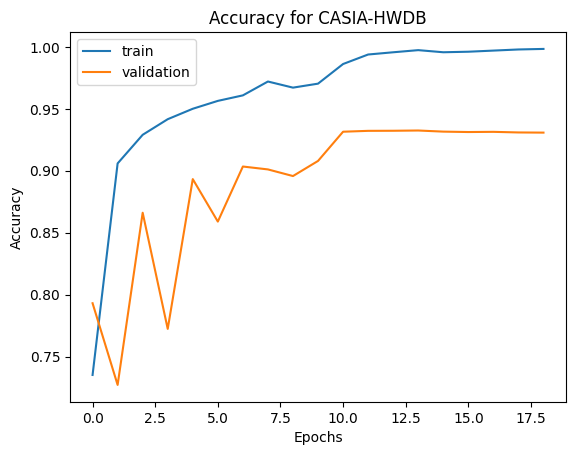

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for CASIA-HWDB", "Accuracy")

Text(0.5, 1.0, 'Loss for CASIA-HWDB')

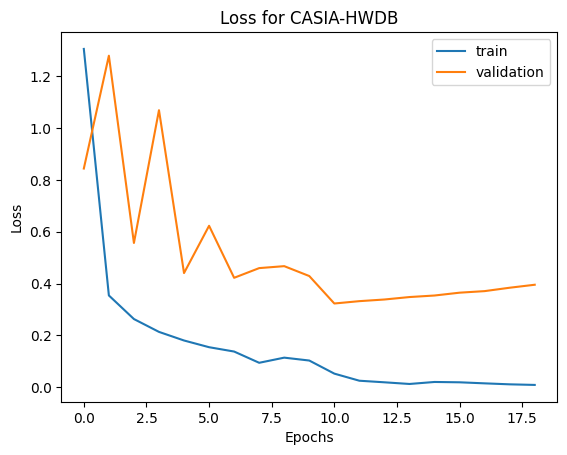

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for CASIA-HWDB", "Loss")

In [23]:
# Testing model

testing_model(class_amount=6764, model_suff_path="/kaggle/working/model_CASIA_HWDB_stuff")

/tmp/ipykernel_30/2314565953.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))  0%|          | 0/176 [00:

Test: loss 0.3478907644748688 accuracy 0.9325065612792969

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers    if w.is_alive():  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive    assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__    Traceback (most recent call last):  File "/opt/conda/lib/python3.10/site-packages/torch/utils

乾 1.0 144.0亵 1.0 58.0仫 1.0 60.0佧 1.0 60.0俎 1.0 59.0俜 1.0 60.0俪 1.0 60.0倏 1.0 60.0傣 1.0 142.0傧 1.0 59.0儇 1.0 58.0兕 1.0 59.0凹 1.0 142.0凿 1.0 145.0剽 1.0 60.0劁 1.0 60.0劐 1.0 60.0劓 1.0 60.0勰 1.0 60.0匏 1.0 60.0卺 1.0 58.0厝 1.0 60.0厣 1.0 59.0咧 1.0 83.0咫 1.0 59.0哿 1.0 59.0唣 1.0 59.0唳 1.0 60.0啊 1.0 142.0啕 1.0 60.0喃 1.0 60.0嗫 1.0 60.0嗲 1.0 60.0嘤 1.0 60.0嘭 1.0 59.0嘶 1.0 143.0噔 1.0 60.0噗 1.0 60.0噤 1.0 60.0噱 1.0 60.0圳 1.0 60.0坩 1.0 59.0垴 1.0 60.0堙 1.0 59.0墁 1.0 59.0夔 1.0 59.0奘 1.0 59.0妤 1.0 59.0妯 1.0 60.0姹 1.0 60.0娉 1.0 60.0婀 1.0 60.0媲 1.0 60.0媾 1.0 60.0嫔 1.0 59.0嫦 1.0 59.0嬗 1.0 59.0嬷 1.0 58.0孀 1.0 59.0孬 1.0 58.0孱 1.0 60.0寰 1.0 60.0屐 1.0 60.0峤 1.0 60.0崂 1.0 60.0崛 1.0 59.0嵇 1.0 60.0嵊 1.0 60.0嵬 1.0 60.0嶙 1.0 60.0嶷 1.0 59.0帼 1.0 60.0幄 1.0 60.0幞 1.0 60.0幡 1.0 60.0庑 1.0 60.0廑 1.0 60.0廨 1.0 60.0弑 1.0 60.0彀 1.0 60.0彘 1.0 59.0徕 1.0 60.0恐 1.0 143.0恸 1.0 60.0恹 1.0 60.0悒 1.0 59.0悖 1.0 60.0悱 1.0 60.0惬 1.0 60.0愆 1.0 60.0愍 1.0 60.0懿 1.0 59.0戟 1.0 60.0戡 1.0 60.0戤 1.0 60.0戬 1.0 60.0揆 1.0 60.0揸 1.0 60.0搋 1.0 60.0搠 1

In [104]:
testing_models_metrics(class_amount=6764, model_suff_path="/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_300_stuff", casia_hwdb=True) 

/tmp/ipykernel_23/2575094430.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/casia-hwdb/train/train'